In [1]:
# install required packages
!pip install -q -U transformers bitsandbytes accelerate
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 37.6 MB/s eta 0:00:00


In [3]:
# import needed packaged
import torch
from transformers import BitsAndBytesConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from datasets import load_dataset
import pandas as pd
import re

In [4]:
# quantize and initialize the GEITje-7b-ultra model
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

model_4bit = AutoModelForCausalLM.from_pretrained( "BramVanroy/GEITje-7B-ultra", device_map="auto",quantization_config=quantization_config, )
tokenizer = AutoTokenizer.from_pretrained("BramVanroy/GEITje-7B-ultra")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [5]:
# Load the Dutch COLA dataset
dataset = load_dataset("GroNLP/dutch-cola")

Generating train split:   0%|          | 0/19893 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2400 [00:00<?, ? examples/s]

In [6]:
# check the data_features
print(dataset["train"].features)

{'Source': Value(dtype='string', id=None), 'Original ID': Value(dtype='string', id=None), 'Acceptability': Value(dtype='int64', id=None), 'Original annotation': Value(dtype='string', id=None), 'Sentence': Value(dtype='string', id=None), 'Material added': Value(dtype='int64', id=None)}


In [7]:
# Filter the dataset to include only examples with intermediate acceptability labels
intermediate_dataset = dataset.filter(lambda example: example["Original annotation"] in ["*?", "??"])
all_sentences = dataset.filter(lambda example: example["Acceptability"])

# Convert the datasets to pandas DataFrames
train_df = pd.DataFrame(intermediate_dataset["train"])
validation_df = pd.DataFrame(intermediate_dataset["validation"])
test_df = pd.DataFrame(intermediate_dataset["test"])

# Concatenate the DataFrames
calculate_all_combined = pd.concat([train_calc_df, validation_calc_df, test_calc_df], ignore_index=True)

# Concatenate the DataFrames
intermediate_dataset_combined = pd.concat([train_df, validation_df, test_df], ignore_index=True)

# Manually import and load the intermediate.csv dataset
intermediate_dataset = pd.read_csv("intermediate.csv")

# Combine the two dataset into one total intermediate dataset
total_intermediate_dataset = pd.concat([intermediate_dataset_combined, intermediate_dataset])

# Print the first few examples in the intermediate dataset
print(total_intermediate_dataset.head())

Filter:   0%|          | 0/19893 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/19893 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2400 [00:00<?, ? examples/s]

      Source Original ID  Acceptability Original annotation  \
0  SoD-Noun2        4.5a            0.0                  ??   
1  SoD-Noun2       4.14a            0.0                  *?   
2  SoD-Noun2      4.33a'            0.0                  *?   
3  SoD-Noun2      4.40b'            0.0                  ??   
4  SoD-Noun2       4.41b            0.0                  *?   

                                    Sentence  Material added  
0                Er staat een tafel cadeaus.             1.0  
1          Een kudde olifanten gaan voorbij.             0.0  
2  Dat is een luidruchtige aantal studenten.             1.0  
3                  Ik heb vier paren boeken.             1.0  
4              Er vielen twee meters sneeuw.             0.0  


In [8]:
# Make dataset for all senteces with acceptability of 1
gram_sentences = dataset.filter(lambda example: example["Acceptability"])

# Convert the datasets to pandas DataFrames
train_grammatical_df = pd.DataFrame(gram_sentences["train"])
validation_grammatical_df = pd.DataFrame(gram_sentences["validation"])
test_grammatical_df = pd.DataFrame(gram_sentences["test"])

# Concatenate the DataFrames
grammatical_combined = pd.concat([train_grammatical_df, validation_grammatical_df, test_grammatical_df], ignore_index=True)
# Randomly sample 1035 sentences from the combined DataFrame
sampled_grammatical_combined = grammatical_combined.sample(n=1035, random_state=42)

# Check the amount of sentences
print(sampled_grammatical_combined["Acceptability"].value_counts())

Acceptability
1    1035
Name: count, dtype: int64


In [9]:
# Make dataset for all senteces with acceptability of 0
ungrammatical_dataset = dataset.filter(lambda example: example["Original annotation"] in ["*"])
# Convert the datasets to pandas DataFrames
train_un_df = pd.DataFrame(ungrammatical_dataset["train"])
validation_un_df = pd.DataFrame(ungrammatical_dataset["validation"])
test_un_df = pd.DataFrame(ungrammatical_dataset["test"])

# Concatenate the DataFrames
ungrammatical_combined = pd.concat([train_un_df, validation_un_df, test_un_df], ignore_index=True)
# Randomly sample 1035 sentences from the combined DataFrame
sampled_ungrammatical_combined = ungrammatical_combined.sample(n=1035, random_state=42)
print(sampled_ungrammatical_combined["Acceptability"].value_counts())

Filter:   0%|          | 0/19893 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2400 [00:00<?, ? examples/s]

Acceptability
0    1035
Name: count, dtype: int64


In [10]:
# Combine the subsets of sampled_grammatical_combined and sampled_ungrammatical_combined to create a baseline dataset
baseline_dataset = pd.concat([sampled_grammatical_combined, sampled_ungrammatical_combined])

In [12]:
# Select 50 random sentences from our constructed dataset to make a sample dataset
sampled_dataset = total_intermediate_dataset.sample(n=50, random_state=42)
# Access the validate subset
test_dataset = dataset["test"]
original_labels = sampled_dataset["Original annotation"]
# Get unique labels
unique_labels = set(original_labels)
# Print unique labels
print("Unique Labels:")
for label in unique_labels:
    print(label)

Unique Labels:
??
*?
?
(?)


In [13]:
# Sampled dataset
# Filter the DataFrame to include only the relevant columns
tot_samp_dataset_filtered = sampled_dataset[['Sentence', 'Original annotation']]

# Rename the columns to match the expected format
tot_samp_dataset_filtered.columns = ['sentence', 'Original_label']
print(tot_samp_dataset_filtered)

                                               sentence Original_label
1061          In die kast stonden er twee grammatica's.              ?
1251  Jan regelde de overdracht aan de politie door ...             *?
1091  Jan gaat waarschijnlijk om drie uur in het par...              ?
141            De koningin behandelen kostte veel tijd.             ??
211   Jans schilderij van Vermeer van het melkmeisje...             ??
1099                 Hoeveel meter lang is het zwembad?             ??
1109               Waar in zullen we deze ring stoppen?              ?
567                  Dat is een behoorlijke zware klus.             ??
1512  Overlijden van een kind is altijd een tragisch...             *?
831             Het hangt vol met slingers in de kamer.             ??
1009  Niet het boek gelezen heeft hij maar de film g...              ?
764          Met zijn hoed af kwam Jan de kamer binnen.             *?
1173  Ik weet dat Jan Marie op besloten heeft te bel...             ??
710   

In [14]:
# Complete intermediate dataset
# Filter the DataFrame to include only the relevant columns
tot_int_dataset_filtered = total_intermediate_dataset[['Sentence', 'Original annotation']]

# Rename the columns to match the expected format
tot_int_dataset_filtered.columns = ['sentence', 'Original_label']
print(tot_int_dataset_filtered)

                                               sentence Original_label
0                           Er staat een tafel cadeaus.             ??
1                     Een kudde olifanten gaan voorbij.             *?
2             Dat is een luidruchtige aantal studenten.             *?
3                             Ik heb vier paren boeken.             ??
4                         Er vielen twee meters sneeuw.             *?
...                                                 ...            ...
1195  Na Zwolle rijdt deze trein verder naar Groning...              ?
1196  Deze trein rijdt verder als intercity en kun j...              ?
1197  Hij zei dat Tasman het Zuidland zou hebben ont...              ?
1198  Tasman heeft toen de kralen de Maori's maar ge...              ?
1199  Tasman heeft toen de kralen de Maori's maar te...              ?

[2793 rows x 2 columns]


In [15]:
# Baseline dataset
# Filter the DataFrame to include only the relevant columns
baseline_dataset_filtered = baseline_dataset[['Sentence', 'Original annotation']].copy()

# Rename the columns to match the expected format
baseline_dataset_filtered.columns = ['sentence', 'Original_label']

# Replace None values with a specific value, e.g., '+'
baseline_dataset_filtered.loc[baseline_dataset_filtered['Original_label'].isna(), 'Original_label'] = '+'

print(baseline_dataset_filtered)

                                               sentence Original_label
3595                                Dat is vrij korter.              +
884                                   Jan doet de vaat.              +
6350                  Hij kwam met twee uitzonderingen.              +
5697                             Jan loopt de zaal uit.              +
1491                        Jan leest een boek van jou.              +
...                                                 ...            ...
167      Wat voor een lolly heeft Jan een kind gegeven?              *
367                              Jan legt neer die bal.              *
5706  Ik denk dat dit boek waarschijnlijk de jongens...              *
6771                          Jan en ze waren aanwezig.              *
835   Ik heb Els uitgenodigd, die hiernaast woont, m...              *

[2070 rows x 2 columns]


In [16]:
# Count amount of sentences per label for sample dataset
amount_per_label_samp = tot_samp_dataset_filtered['Original_label'].value_counts()

# Show the results
print("Amount of sentences per label:")
print(amount_per_label_samp)

Amount of sentences per label:
Original_label
??     23
?      19
*?      5
(?)     3
Name: count, dtype: int64


In [17]:
# Count amount of sentences per label for baseline
amount_per_label_baseline = baseline_dataset_filtered['Original_label'].value_counts()

# Show the results
print("Amount of sentences per label:")
print(amount_per_label_baseline)

Amount of sentences per label:
Original_label
+    1035
*    1035
Name: count, dtype: int64


In [18]:
# Count amount of sentences per label for complete intermediate dataset
amount_per_label = tot_int_dataset_filtered['Original_label'].value_counts()

# Show the results
print("Amount of sentences per label:")
print(amount_per_label)

Amount of sentences per label:
Original_label
??     1035
?      1035
*?      558
(?)     164
Name: count, dtype: int64


In [19]:
# run the GEITje model

# List of intermediate labels you want to filter on
desired_labels = ['?', '??', '*?', '(?)']
# List of the baseline labels
desired_labels_baseline = ['+', '*']

# Empty dictionary to store model predictions per label type
predictions_per_label = {}

# Iterate through each type of intermediate label
for label in desired_labels_baseline:
    # Filter the dataset to get only sentences with the current intermediate label
    filtered_dataset = baseline_dataset_filtered[baseline_dataset_filtered['Original_label'] == label]
    print(filtered_dataset)

    # Initializing lists to store original labels and model predictions
    original_labels = []
    model_predictions = []
    # Define prompts in Dutch
    prompt_example = " Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk."
    prompt_intermediate = "Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: "
    prompt_how_to_answer = " Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is"
    # Iterate through the filtered dataset and generate model predictions
    for index, row in filtered_dataset.iterrows():
        sentence = row['sentence']
        label = row['Original_label']

        # Construct prompt based on label
        prompt_input = prompt_example + prompt_intermediate + sentence + prompt_how_to_answer

        # Move input_ids to the GPU (cuda) if the model is on the GPU
        inputs = tokenizer(prompt_input, return_tensors="pt", max_length=512, truncation=True)
        inputs = {key: value.to('cuda') for key, value in inputs.items()}

        # Generate response using the model
        outputs = model_4bit.generate(**inputs, max_length=300)
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print(generated_text)

        # search generated text for positive answer
        is_acceptable = re.search(r"Antwoord: 1", generated_text) is not None

        # Set model prediction based on the presence of a positive answer
        model_prediction = 1 if is_acceptable else 0

        # Add the model prediction to the list
        model_predictions.append(model_prediction)

        print(model_predictions)

    # Add the list of model predictions to the dictionary with the current label as the key
    predictions_per_label[label] = model_predictions
print(predictions_per_label)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


                                                sentence Original_label
3595                                 Dat is vrij korter.              +
884                                    Jan doet de vaat.              +
6350                   Hij kwam met twee uitzonderingen.              +
5697                              Jan loopt de zaal uit.              +
1491                         Jan leest een boek van jou.              +
...                                                  ...            ...
5933                              Tot lang na de oorlog!              +
11808  Jan mag dan erg slim zijn, maar hij is niet ha...              +
173               Dat zijn een aantal groepen studenten.              +
50                    Jan verzamelde een doos porselein.              +
7563           De leerlingen kregen te veel huiswerk op.              +

[1035 rows x 2 columns]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is vrij korter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan doet de vaat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij kwam met twee uitzonderingen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan loopt de zaal uit. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan leest een boek van jou. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Alle jongens hebben gezongen of gedanst. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat hij beroofd was dat zal Jan Marie morgen vertellen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Nu hij afgestudeerd was, kon hij gaan werken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een tussenzin is die een gevolg beschrijft van een actie (afstuderen) die in de vorige zin is beschreven. Het is een gebruikelijke manier om een actie te verbinden met de gevolgen ervan.
[0, 0, 0, 0, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Van zulk hout zal ik waarschijnlijk een kast kopen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Van zulk hout zal ik waarschijnlijk een kast kopen" is een acceptabele zin omdat het een duidelijke actie beschrijft (het kopen van een kast) en een voorwaardelijke uitspraak (waarschijnlijk) bevat, wat een waarschijnlijkheid aangeeft. Het is een zin die een actie aankondigt die gebaseerd is op de beschrijving van het hout (zulk hout), wat een relevante context biedt voor de actie.
[0, 0, 0, 0, 0, 0, 0, 1, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman was niet een held maar een lafaard. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft een half miljard boeken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Els bleek voldoende aangesterkt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Els bleek voldoende aangesterkt" is een tussenzin die een actie of toestand beschrijft die volgt op een eerdere gebeurtenis of situatie. Het is een beschrijving van een toestand van Els, wat een persoon is, en het gebruik van het werkwoord "bleek" geeft aan dat deze toestand waargenomen of geconstateerd wordt. Dit is een voorbeeld van een tussenzin die informatie geeft over een personage of situatie, wat een acceptabele zin maakt.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij kwam zonder uitzonderingen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Hij kwam zonder uitzonderingen" is een tussenzin die een algemene uitspraak doet over de actie van "Hij kwam". Het geeft aan dat er geen uitzonderingen zijn op de actie van "Hij kwam". Dit is een acceptabele zin omdat het een duidelijke en beknopte manier is om te zeggen dat iemand zonder onderbrekingen of uitzonderingen een actie heeft uitgevoerd.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij heeft groene vingers. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is het minst intelligent. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is rood van opwinding. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is nooit boos op zijn vader. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan is nooit boos op zijn vader" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een feitelijke situatie beschrijft zonder een oordeel of een specifieke actie te bevatten. Het is een beschrijving van een constante toestand, wat past binnen de context van de voorbeelden die tussenzinnen zijn die een feitelijke situatie beschrijven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een voor mij te moeilijk boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zijn vader daar heeft hij op gewacht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan en jij zijn goede vrienden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Kees hoorde zich roepen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft aids. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

De zin "Jan heeft aids" is niet acceptabel volgens de voorbeelden die gegeven zijn. Deze zin is een voorbeeld van een tussenzin die niet past binnen de context van de voorbeelden die gegeven zijn. De voorbeelden die gegeven zijn, zijn allemaal positief of neutraal van aard, terwijl "Jan heeft aids" een negatieve of medische situatie beschrijft die niet past binnen de context van de voorbeelden.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De auto naderde van ver achter het huis vandaan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het gebonk dat je nu hoort komt van de motoren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zette de vaas vol. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij zei dat Peter die fout niet is opgevallen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Hij zei dat Peter die fout niet is opgevallen" is een tussenzin die een gedachte of een reactie van een ander personage weergeeft. Het is een directe uitspraak van een personage, wat een acceptabele zin maakt in de context van een verhaal of dialoog.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is met geen pen te beschrijven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De verlegenheid van die jongen bezorgt hem veel last. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze fles is niet vrijwel vol. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: Deze zin is niet acceptabel omdat het impliceert dat de fles bijna vol is, wat niet overeenkomt met de uitdrukking "niet vrijwel vol". De zin zou correct zijn als het expliciet maakt dat de fles niet vol is, bijvoorbeeld: "Deze fles is niet vol".
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze knijpers zijn voor mijn wasgoed. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan schijnt dat boek gelezen te hebben. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De baby kruipt al. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "De baby kruipt al" is een acceptabele zin volgens de voorbeelden die gegeven zijn. Het is een tussenzin die een actie beschrijft die plaatsvindt, wat past binnen de context van tussenzinnen die vaak gebruikt worden om een verhaal of beschrijving te verrijken.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De atleet bereikte de finish eerder dood dan levend. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zegt hun vader. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ja, ik heb dat met plezier gelezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peters gedoneer van grote bedragen is onderzocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman wou weten of hij het Zuidland gezien had. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Tasman wou weten of hij het Zuidland gezien had" is een acceptabele zin volgens de voorbeelden. Het gebruik van de verleden tijd en de constructie "wou weten" geven aan dat Tasman een wens of verlangen uitdrukt, wat een tussenzin kan zijn.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Mag ik twee bier van u? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het haar aangeboden boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan doet een das om zijn nek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Volgens de regels moet de voorzitter de vergadering openen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman heeft Tasmanië en Cook heeft de Cook-eilanden ontdekt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Tasman heeft Tasmanië en Cook heeft de Cook-eilanden ontdekt." is een acceptabele zin. Deze zin geeft een historisch feit weer over de ontdekking van Tasmanië door Abel Tasman en de ontdekking van de Cook-eilanden door James Cook. Deze namen zijn bekend in de geschiedenis en worden vaak gebruikt om naar deze gebeurtenissen te verwijzen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Meestal zijn jullie beleefd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie zal dat zij zwanger is vanmiddag bekend maken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Opa vertelde ons dat Tasman Nieuw Zeeland ontdekt heeft. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit probleem is ingewikkeld. De oplossing ervan kost veel tijd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft verteld dat hij beroofd was direct nadat hij thuis kwam. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan heeft verteld dat hij beroofd was direct nadat hij thuis kwam." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die direct volgt op een eerdere actie (thuis komen). Dit is een gangbare manier om een verhaal of gebeurtenis te vertellen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn vier van de studenten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is nooit trots op zijn vader geweest. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0 (niet acceptabel)

De zin "Jan is nooit trots op zijn vader geweest" is niet acceptabel volgens de voorbeelden die gegeven zijn. Deze zin bevat geen tussenzin die een actie of een situatie beschrijft, zoals de andere voorbeelden dat wel doen. Het is een directe uitspraak over een gevoel of een mening, wat niet past binnen de context van de voorbeelden die gevraagd worden om tussenzinnen te beoordelen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ben dol op deze jongen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een aardige vader dat hij heeft! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0 (niet acceptabel)

De zin "Een aardige vader dat hij heeft!" is niet acceptabel omdat het een ongebruikelijke constructie is die niet gebruikelijk is in de Nederlandse taal. In het Nederlands zou je zeggen "Een aardige vader die hij heeft!" of "Een aardige vader heeft hij!"
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zag Jans vader in het park. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De twee meisjes hebben samen de rots opgetild. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Eet! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het cadeau werd hem door Marie beloofd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De eerste reis zelf echter was een ramp. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is niets behulpzaam. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan rent graag in het bos en op het strand. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zag dat Jan met grote nauwkeurigheid werkte. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Je krijgt morgen een cadeautje. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat hij een liedje is gaan zingen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is duidelijk groter dan Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Els vindt die soep lekker ruiken maar ik niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Els vindt die soep lekker ruiken maar ik niet." is een acceptabele zin omdat het een uitspraak is over de persoonlijke ervaring van twee personen met betrekking tot dezelfde gebeurtenis (de soep ruiken). Het gebruik van "maar" geeft aan dat er een contrast is tussen de twee personen, wat een normale manier is om persoonlijke verschillen in voorkeuren of meningen uit te drukken.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zoekt wat anders. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan kan daardoor toch niet ziek worden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een dergelijke opvatting is typisch middeleeuws. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ja, dat kan wel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk dat Marie Jan een aardige jongen acht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan probeert om de wedstrijd te winnen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zit hier al jaren op kantoor. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De man die hier net was en die Russisch sprak is een beroemd schrijver. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zie dat Jan zich aan het voor aan melden is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter jaagt naar succes. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De spijker zit voor de helft in de muur. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De eettafel is ronder dan de salontafel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De weg loopt van de berg af. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Mijnheer, ik heb mezelf nog niet opgegeven voor deze cursus. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Mijn collega en mijn beste vriend komen op bezoek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ken een knappe schrijver. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie heeft naar Peter geluisterd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is nogal traag van begrip. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De ballon hing vlak boven het huis. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb van Jan gisteren de auto gerepareerd en niet van Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat ligt op de route van Amsterdam. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Leiden ligt vlak onder de zeespiegel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jans zoeken naar de waarheid was vruchteloos. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze omgeving is vertrouwd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit toneelstuk is elizabethaans. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een enorme vlucht kraanvogels. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er worden schapen gehouden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die nieuwe computer is zeer hárd nodig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Die nieuwe computer is zeer hárd nodig." is een acceptabele zin volgens de voorbeelden. Het gebruik van "zeer" en "hard" in combinatie met "nodig" geeft een duidelijke indicatie van de urgentie of belangrijkheid van de nieuwe computer. Dit is een voorbeeld van een tussenzin die een extra detail of nadruk toevoegt aan de hoofdzin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hier te zwemmen, dat is gevaarlijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Jan eindelijk vroeg van ... wil je met me trouwen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan moest erg lachen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Je moet niet dit maar dat boek lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wil niet langer op zijn vader wachten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan wil niet langer op zijn vader wachten" is een acceptabele zin omdat het een duidelijke actie of wens van Jan beschrijft, zonder onnodige informatie of onduidelijkheid. Het is een directe uitdrukking van wat Jan wil doen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie heeft Peters auto geleend. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie heeft Peters auto geleend" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die door Marie wordt uitgevoerd, wat overeenkomt met de structuur van de voorbeelden die u heeft gegeven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de huidige president. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Twee meter boven de deur hangt een schilderij. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan houdt de honden bij 'm. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik vind een zebra meestal erg interessant. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat duurt twee uur korter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze hond is intelligenter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Treiteren van peuters door grote jongens is onaanvaardbaar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hun gegiechel verstoorde de les. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan komt en Marie en Els komen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan komt en Marie en Els komen." is een acceptabele zin omdat het een tussenzin is die twee hoofdzinnen verbindt. Het geeft aan dat Jan komt en dat Marie en Els ook komen, wat een duidelijke en logische volgorde van gebeurtenissen aangeeft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er werd geprobeerd pro het Zuidland te vinden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is vorige week ziek geweest. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De eerste reis van Tasman echter was een ramp. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Juist vanwege de sneeuw wil ik wandelen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb sommige paren schoenen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ben mijn sleutels verloren, maar ik weet niet waar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ik ben mijn sleutels verloren, maar ik weet niet waar." is een acceptabele zin. Het geeft een situatie weer waarin iemand zijn sleutels kwijt is en aangeeft dat hij of zij niet weet waar ze zijn. Dit is een veelvoorkomende zin die mensen gebruiken om een verlies van een voorwerp aan te geven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is ernstiger ziek dan Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan schijnt de dader. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoop dat Jan dat boek heeft proberen te lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Is hij een beetje aardig? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De illusionist hypnotiseert de vrijwilliger. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wie aait de kat? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zou haar hulp zeer waarderen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan kent het antwoord. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er is niet ergens corruptie gepleegd maar overal. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er bovenop ligt een nieuw overhemd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Piet weet van het gedoneer van grote bedragen door multinationals aan goede doelen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Piet weet van het gedoneer van grote bedragen door multinationals aan goede doelen" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die informatie geeft over een actie of kennis van een persoon (Piet) over een specifieke situatie (het gedoneer van grote bedragen door multinationals aan goede doelen). Dit is een voorbeeld van een tussenzin die een feit of een stukje informatie presenteert.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze zagen dat Jan van het dak af sprong. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie is een strenge maar rechtvaardige rechter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat voor type mens vind je peter? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het gedoneer door multinationals van bedragen boven de € 100.000 is onderzocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De kapitein vaart met een grote boot. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Van Peter heb ik nog niets gehoord. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Rookte eens wat minder, dan is die benauwdheid snel over! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wanneer heeft Tasman wat ontdekt? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wanneer heeft Tasman wat ontdekt?" is een acceptabele zin omdat het een vraag is die een specifieke actie of gebeurtenis beschrijft die plaatsvond in de context van de ontdekkingen van Abel Tasman. Het is een directe vraag die informatie vraagt over een specifiek moment in de tijd.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De vuilnisbak staat naast de auto. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De komst van Jan was een aangename verrassing. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zal vanavond die brief schrijven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dokter komt zo. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een enorm donkere kamer. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is net zomin een schurk als Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik rijd straks. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter werd in het been gebeten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jans gezicht is niet rond. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "Jans gezicht is niet rond" is niet acceptabel volgens de voorbeelden die gegeven zijn. Deze zin is een beschrijving van een persoon, maar het is niet een beschrijving die past bij de voorbeelden die gaan over dieren, cadeaus, of rijkdom. Het is een beschrijving van een menselijke eigenschap, wat niet past binnen de context van de voorbeelden die gaan over dieren, cadeaus, of rijkdom.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb alle studenten gezien met uitzondering van hem. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: We hoorden dat Jan er zeer mee in z'n knollentuin is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft geen broer die werkt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan heeft geen broer die werkt" is een acceptabele zin volgens de voorbeelden. Het is een duidelijke en beknopte zin die een feitelijke situatie beschrijft zonder overbodige informatie of complexe constructies.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de plaats waar ik ga slapen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het valt me op als Jan erover klaagt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan werkt morgen of overmorgen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Nieuwe computers werken prima. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Nieuwe computers werken prima" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een feitelijke mededeling doet over de functionaliteit van nieuwe computers.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het door de voorzitter prijzen aan de winnaars laten uitreiken bleek een goed idee. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman zette het journaal in de kast. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is wat te jong voor dat evenement. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat heeft Jan gelezen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wat heeft Jan gelezen?" is een acceptabele zin omdat het een vraag is die informatie vraagt over een actie die Jan heeft ondernomen (het lezen van iets). Het is een directe vraag die informatie vraagt over een specifieke actie, wat een gebruikelijke manier is om informatie te vragen in een gesprek.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan kan de auto gestolen hebben. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan kan de auto gestolen hebben" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die Jan zou kunnen uitvoeren, zonder dat er een directe bevestiging of ontkenning van die actie in de zin staat. Dit is vergelijkbaar met de zinnen "Een kudde olifanten gaan voorbij" en "Marie heeft drie koeien grazen", die ook beschrijven wat een persoon (in dit geval Jan) zou kunnen doen zonder een directe bevestiging of ontkenning.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jouw rode trui is mooi, maar mijn blauwe is nog mooier. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat een boeken zijn dat! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan streek die broek het gladst. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is een gever van dure cadeaus. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De directeur hoopt dat hij een grote bonus krijgt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb vier paar boeken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Beneden in de kast ligt een nieuw overhemd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit huis zou elk moment instorten, maar dat was onzin. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is de allerààrdigste jongen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is minstens een emmer appels. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan en Ruud zijn schatten van katten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat Marie waarschijnlijk gewoonlijk wel met 'm wil spelen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ik weet dat Marie waarschijnlijk gewoonlijk wel met 'm wil spelen." is een acceptabele zin omdat het een tussenzin is die een waarschijnlijkheid uitdrukt over een toekomstige gebeurtenis (Marie die met 'm wil spelen) en het gebruik van een tussenzin is een veelvoorkomende manier om informatie te geven die relevant is voor de hoofdzin (in dit geval, de hoofdzin is "Ik weet dat Marie..."). Het gebruik van "waarsch
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan probeerde dat boek te lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze draad is twee millimeter dik. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ken een aardig persoon. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jacob Olies foto van de Westertoren hing aan de muur. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de enige gelegenheid. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is rechter en streng. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat Els hem wou helpen waardeerde Peter zeer. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De hond is Peter trouw. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De film was leuk om naar te kijken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat heeft Tasman voor matrozen gisteren aan land gestuurd? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het staat me erg tegen als Jan erover klaagt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan rookt tabak. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Klaas is de bakker van mijn ouders. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter veegt de vloer schoon. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan ontmoette Piet en diens dochter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan ontmoette Piet en diens dochter" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die plaatsvindt tussen twee personen, wat overeenkomt met de structuur van de voorbeelden die tussenzinnen bevatten die een actie of gebeurtenis beschrijven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb gisteren een film over Nixon gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is wel aardig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is naar Groningen gewandeld niet gefietst. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan is naar Groningen gewandeld niet gefietst." is een acceptabele zin omdat het een duidelijke en grammaticaal correcte zin is die een actie beschrijft die Jan heeft ondernomen. Het gebruik van "gewandeld" in plaats van "gefietst" geeft aan dat Jan te voet is gegaan, wat een gangbare manier van reizen is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: In deze zaal irriteert het roken me altijd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zie dat Jan de kaartjes voorverkoopt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is zelfs te ziek om te kunnen komen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Hij is zelfs te ziek om te kunnen komen." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een extra detail geeft over de situatie van de persoon die niet kan komen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: “Peter”, dat zei Marie tenminste, “zal het boek morgen brengen”. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wanneer zong Jan een liedje en danste hij? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan gaat morgen weg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De aanbeveling van Jan voor die baan werd genegeerd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit is Tasmanië want dat is Nieuw Zeeland. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Dit is Tasmanië want dat is Nieuw Zeeland" is een voorbeeld van een tussenzin die een vergelijking maakt. Het is een manier om twee plaatsen met elkaar te vergelijken, wat een vorm van vergelijking is die in de taal gebruikt wordt. In dit geval vergelijkt de spreker Tasmanië met Nieuw Zeeland, wat een plaats is. Dit is een acceptabele zin omdat het een duidelijke vergelijking maakt en een logische relatie tussen de twee plaatsen aangeeft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het subject of het onderwerp congrueert met de persoonsvorm. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

---



In deze zin is het onderwerp "Het subject of het onderwerp" en de persoonsvorm is "congruert". De zin lijkt correct te zijn, omdat het onderwerp ("Het subject of het onderwerp") verwijst naar een persoonsvorm ("congruert") die in de zin staat. Dit is een voorbeeld van een tussenzin die de relatie tussen het onderwerp en de persoonsvorm beschrijft. Als de zin niet acceptabel is, zou dit betekenen dat de zin niet voldoet aan de grammaticale regels voor tussenzinnen, of dat de zin ondu
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat een vreselijk leven! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Münchhausen trok zich uit het moeras. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze fles is niet helemaal vol. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze fles is niet helemaal vol.

Deze zin is acceptabel omdat het een beschrijving geeft van de staat van de fles, namelijk dat deze niet helemaal vol is. Het is een feitelijke observatie die geen oordeel of mening bevat.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie vermoedt dat Jan het boek leest. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie vermoedt dat Jan het boek leest" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een gedachte of vermoeden van Marie uitdrukt over de actie van Jan. Het is een voorbeeld van een zin die een idee of mening van een personage overbrengt, wat een veelvoorkomend element is in literaire teksten.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman heeft daar op meesterlijke wijze een journaal over bij gehouden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is boos op Peter over die opmerking. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan woont dichtbij de Westerkerk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan woont dichtbij de Westerkerk" is een acceptabele zin omdat het een duidelijke locatie aangeeft waar Jan woont. Het is een voorbeeld van een tussenzin die een locatie beschrijft, wat een veelvoorkomend gebruik is in zinnen die de plaats van iets of iemand aanduiden.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan reed van Utrecht naar Groningen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De vertelster van die verhalen heeft een grote verbeeldingskracht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De atleet kwam net binnen de gestelde tijd binnen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk niet dat er een Zuidland is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman werd rijk door verre landen te ontdekken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik wil de fiets wel repareren maar dan moet je me vertellen hoe. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat heeft hij haar aangeboden? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Aan Marie heeft Peter dit boek aangeboden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij zagen dat hij een spijkerbroek aan trok onder zijn toga. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wandelt sneller. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zijn boek over de middeleeuwen ligt daar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie heeft over ruimtevaart een boek gelezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het schilderij hangt slordig aan de muur. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk dat Jan dat Els morgen vertrekt nog niet weet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zat tegenover de koningin. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie is het slimste van ons allemaal. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Els vroeg of Marie ziek is of dat ze op vakantie is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Els vroeg of Marie ziek is of dat ze op vakantie is." is een acceptabele zin omdat het een vraag is die een directe vraag naar de gezondheid of de activiteit van Marie stelt. Het is een gangbare manier om informatie te vragen in een gesprek.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is altijd bang voor honden geweest. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een zieke man ligt in het ziekenhuis. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman had geprobeerd het Zuidland te ontdekken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Tasman had geprobeerd het Zuidland te ontdekken" is een acceptabele zin volgens de voorbeelden. Het verwijst naar een historische figuur, Abel Tasman, die bekend staat om zijn pogingen om het Zuidland (nu bekend als Nieuw-Zeeland) te ontdekken. Deze zin is een voorbeeld van een tussenzin die informatie geeft over een historische gebeurtenis.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan bracht Marie aan het twijfelen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan krijgt het boek te leen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan luistert graag naar de radio. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij was de betaler van het loon. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij hebben Tasman niet gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is lang. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan is lang" is een acceptabele zin volgens de voorbeelden. Het is een korte, directe zin die een feitelijke uitspraak doet over de lengte van Jan. Dit is een voorbeeld van een tussenzin die geen extra informatie geeft en direct ter zake komt.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wil dat boek lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan ging vroeg naar huis want hij was moe. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan weet wanneer Marie niet kan komen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: Deze zin is een tussenzin die informatie geeft over de relatie tussen Jan en Marie. Het is een feitelijke mededeling die geen nieuwe informatie toevoegt aan de context van de verhaallijn, maar het is wel een zin die informatie geeft over de personages en hun interacties. Dit is een acceptabele zin binnen de context van een verhaal of dialoog.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan woont te Amsterdam. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan rende helemaal naar Groningen toe. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan rende helemaal naar Groningen toe" is een acceptabele zin omdat het een duidelijke actie beschrijft die plaatsvindt in de realiteit. Het is een voorbeeld van een tussenzin die een actie of gebeurtenis beschrijft die in de werkelijkheid zou kunnen plaatsvinden.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De soep was voldoende afgekoeld. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan, die heb ik niet gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat heeft Peter voor een boeken gekocht? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wat heeft Peter voor een boeken gekocht?" is een acceptabele zin omdat het een vraag is die voldoet aan de grammaticale regels van de Engelse taal. Het is een directe vraag die begint met een onderwerp (Peter) en een werkwoord (heeft gekocht), gevolgd door een lijdend voorwerp (boeken). De zin is duidelijk en beknopt, wat wijst op een correcte zinsstructuur.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit is de hond waar Jan mee aan de lijn loopt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het schijnt dat dat probleem Jan nu eindelijk helder is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is een beetje minder duidelijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat Jan heeft beweerd dat boek gekocht te hebben. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is niet bepaald hartstochtelijk verliefd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde over zijn behandeling van Jan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wij hoorden dat zijn dochtertje piano heeft leren spelen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan was toen in Frankrijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Drie jaar te oud is Jan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Drie jaar te oud is Jan" is acceptabel volgens de voorbeelden. Het is een tussenzin die een feitelijke situatie beschrijft, namelijk dat Jan drie jaar ouder is dan een bepaald punt (wat dat punt ook mag zijn). Dit is een duidelijke en directe manier om informatie over te brengen, wat typisch is voor tussenzinnen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze speelde op een vleugel van Steinway. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Ze speelde op een vleugel van Steinway." is een acceptabele zin omdat het een beschrijving geeft van een actie (spelen) en een specifiek object (een vleugel van Steinway) dat vaak geassocieerd wordt met muzikaliteit en kwaliteit. Dit is een voorbeeld van een tussenzin die een detail toevoegt aan de hoofdzin, wat de zin rijker en specifieker maakt.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het schijnt dat Jan staatsgeheimen verkocht heeft. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Het schijnt dat Jan staatsgeheimen verkocht heeft." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een feit of een situatie beschrijft die door een ander personage of in een andere context wordt gezegd of geïmpliceerd. Dit soort zinnen worden vaak gebruikt om informatie te delen zonder directe betrokkenheid of een oordeel te geven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie liep naar de rover toe terwijl zij een revolver in haar hand had. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie liep naar de rover toe terwijl zij een revolver in haar hand had." is een acceptabele zin volgens de voorbeelden. Het is een beschrijving van een actie (naar de rover toe lopen) en een object (een revolver) die Marie bij zich heeft. Dit is een voorbeeld van een tussenzin die de actie of het object verder uitbreidt of toelicht.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wiens boek heeft Marie gelezen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wiens boek heeft Marie gelezen?" is een acceptabele zin omdat het een vraag is die een specifieke actie of eigenschap van een persoon (Marie) vraagt, namelijk welk boek zij heeft gelezen. Dit is een gebruikelijke manier om informatie te vragen in een gesprek of in een schriftelijke context.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft naar een voordracht over Mulisch geluisterd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat boek is vrij goed. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De bloemen liggen achter het huis. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het boek wordt Jan af gepakt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Te moeilijk voor Jan is dat boek niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan was bij de jacht op groot wild. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn diens boeken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter had dat boek morgen moeten hebben gelezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Honden zijn zoogdieren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft meer mensen uitgenodigd dan hij vorig jaar had uitgenodigd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De jongen heeft gewandeld. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze sommen maken is lastiger dan de afwas doen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het schijnt dat Jan met niets tevreden is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Het schijnt dat Jan met niets tevreden is." is een tussenzin die een feit of een observatie geeft over Jan. Het is een beschrijving van een situatie of een gedrag, wat een acceptabele zin maakt in de context van de voorbeelden die gegeven zijn. Het geeft een aanvulling op de situatie of een observatie die al gegeven is, wat typisch is voor een tussenzin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft besloten zijn beslissing te heroverwegen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is twee meter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft dat Els gaat emigreren gisteren onthuld. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman schreef gewoonlijk alles op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wandelde in het park en hij deed dat de hele dag. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij dat Jan dat hij taalkundige is geworden waarschijnlijk betreurt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin is acceptabel omdat het een tussenzin is die een gevoel of mening uitdrukt over een andere persoon (Jan) en een actie (dat hij taalkundige is geworden). Het gebruik van "waarschijnlijk" geeft aan dat er een waarschijnlijkheid is dat Jan dit betreurt, wat een gangbare manier is om een mening of gevoel te uiten.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman dacht niet dat er ook maar iemand woonde. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Tasman dacht niet dat er ook maar iemand woonde" is een tussenzin die een gedachte of observatie van Tasman weergeeft. Het is een voorbeeld van een tussenzin die informatie geeft over de gedachten of acties van een personage, wat een gangbare manier is om informatie over te brengen in een verhaal of beschrijving. Deze zin is dus acceptabel en past binnen de context van een verhaal of beschrijving.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een grote eter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan vertelde Marie dat zij ontslagen zou worden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Jan vertelde Marie dat zij ontslagen zou worden" is een acceptabele zin omdat het een duidelijke mededeling is van een actie die Jan onderneemt met betrekking tot Marie. Het is een directe communicatie van een feit of een aankondiging, wat typisch is voor een tussenzin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is de vermeende dader. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie liep van de kast naar de deur. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie liep van de kast naar de deur" is een acceptabele zin volgens de voorbeelden die gegeven zijn. Het is een eenvoudige beschrijving van een actie die Marie uitvoert, wat een alledaagse en duidelijke handeling is die in de voorbeelden past.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter heeft zowel Jan als Els ontmoet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan legde het kleed recht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Nee, heb ik niet gezien? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman heeft in Nieuw Zeeland met de Maori's gesproken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is vrij bang voor honden en ik ben het voor spinnen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Niet Jan ging naar huis maar Marie ging naar huis. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is een ietsje minder duidelijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wie wil haar wat geven? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze hoopt dat Marie de sonate speelt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Als je gezond wil blijven, dan moet je je goed verzorgen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat was maandag jongstleden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Bejaarden voor deze baan aanbevelen is slim. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan ging ziek en moe naar bed. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dood met die schoft! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb gisteren een fiets gekocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Vijf weken vrij per jaar is eigenlijk te weinig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Vijf weken vrij per jaar is eigenlijk te weinig" is een tussenzin die een mening of een observatie geeft over de hoeveelheid vrije tijd die iemand heeft. Het is een uitspraak die een persoonlijke perceptie of een algemene mening over de hoeveelheid vrije tijd die als te weinig wordt beschouwd, weergeeft. Dit soort zinnen zijn vaak acceptabel in alledaagse gesprekken en kunnen worden gebruikt om een standpunt of een mening te uiten.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is meer een denker dan een doener. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is vrij lang van stof. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit is erg waarschijnlijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman heeft Australië niet in 1642 ontdekt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Tasman heeft Australië niet in 1642 ontdekt" is een acceptabele zin volgens de voorbeelden. De zin geeft een feitelijke gebeurtenis weer die niet in strijd is met de voorbeelden.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De beer kan nu wel los zijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een stuk appeltaart met slagroom. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij vertelde dat hem die meisjes direct opvielen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik bekeek Jans foto van zichzelf. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan scheen erg aardig te zijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie is intelligenter dan hij. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan was vandaag waarschijnlijk om 10 uur vertrokken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een tussenzin is die een waarschijnlijkheid uitdrukt, wat een gangbare manier is om informatie te geven over iemands activiteiten of plannen. Het gebruik van "waarschijnlijk" geeft aan dat er een kans is dat Jan vertrokken is, wat past binnen de context van een tussenzin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De kroonprins is lang en blond. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is er meer tegen gekant. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan gaat naar school en Marie blijft thuis. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan eet brood. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de krant van gisteren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is gisteren waarschijnlijk om drie uur vertrokken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan is gisteren waarschijnlijk om drie uur vertrokken." is een acceptabele zin omdat het een tussenzin is die een waarschijnlijkheid uitdrukt, wat een gangbare manier is om informatie te geven over iets dat niet met zekerheid vaststaat. Het gebruik van "waarschijnlijk" geeft aan dat er een mate van onzekerheid is over het tijdstip van vertrek.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De auto staat in de garage. De motor ervan moet nagekeken worden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "De auto staat in de garage" is een acceptabele zin. Het geeft een feitelijke situatie weer zonder verdere context of implicaties. De zin "De motor ervan moet nagekeken worden" is een tussenzin die een actie beschrijft die gerelateerd is aan de auto, maar het is geen zelfstandige zin die op zichzelf staat. Het is een aanvulling op de eerste zin en maakt deel uit van dezelfde context. Daarom is de zin "De auto staat in de garage" acceptabel.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie zit beneden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik dronk een fles van iets lekkers. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft de kat geaaid. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan en Peters overdracht van de gevangenen verliep snel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De ergste rampen zijn haar overkomen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan beweerde van wel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan moet dat van zijn vader. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij keek op een manier van ... wat willen die mensen van me? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft één miljard drie miljoen en tweeduizend vierentwintig boeken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan heeft één miljard drie miljoen en tweeduizend vierentwintig boeken." is een acceptabele zin volgens de voorbeelden. Het is een voorbeeld van een tussenzin die een feit of een hoeveelheid beschrijft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie schildert. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De post arriveert. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik merk dat het me niet bevalt dat hij steeds dezelfde vraag stelt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft een broer die werkt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie vroeg van ... kan je me even helpen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat voor een rare man loopt daar? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jij en ik wassen onszelf. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tot vlak voor de oorlog aan toe. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Tot vlak voor de oorlog aan toe" is een acceptabele zin omdat het een tussenzin is die een tijd aangeeft waarin iets plaatsvond, in dit geval tot vlak voor de oorlog. Het is een gangbare manier om een periode te beschrijven die eindigt net voor een specifiek moment, in dit geval de oorlog.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een een driemaandelijks tijdschrift. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik deed zalf op mijn neus. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie geeft Peter dat boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie geeft Peter dat boek" is een acceptabele zin volgens de voorbeelden die gegeven zijn. Het is een tussenzin die een actie beschrijft die plaatsvindt tussen twee personen, wat overeenkomt met de voorbeelden die voorzien in een actie tussen twee personen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman wou er niet over praten over Lutjegast. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat hebben er gisteren voor matrozen kokosnoten verzameld? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zag de onzichtbare zichtbare sterren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe zeer waren de Maoris belust op wraak? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit is zowel een muzikaal als een sociaal verschijnsel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Mijn vader -en ook mijn moeder- houdt van honden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik vind de wedstrijd niet om over naar huis te schrijven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Als je morgen daar bent, help hem een beetje! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan drinkt een glas van jouw bier. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wees een beetje aardig! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Geen enkele limonade smaakt lekkerder dan versgeperst sinaasappelsap. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het schilderen van zijn zoon Titus door  Rembrandt gaat langzaam. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De jongen verborg een kat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De hond speelt buiten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik wil twee liter van dat lekkere bier. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan had gewassen noch gekookt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "Jan had gewassen noch gekookt" is een tussenzin die een actie beschrijft die niet is uitgevoerd. Het is een voorbeeld van een tussenzin die een negatieve actie aangeeft, wat niet acceptabel is in een zin. De zin is dus niet acceptabel volgens de voorbeelden die gegeven zijn.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Honden, vossen en reeën blaffen, ganzen gakken en paarden hinniken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Honden, vossen en reeën blaffen, ganzen gakken en paarden hinniken." is een acceptabele zin omdat het een beschrijving geeft van verschillende dieren die geluiden maken, wat een normaal onderdeel is van de natuurlijke omgeving. Het gebruik van de werkwoorden "blaffen", "gakken" en "hinniken" duidt op de geluiden die deze dieren maken, wat een gangbare manier is om hun aanwezigheid en gedrag te beschrijven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij heeft er vier van gelezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan dacht: “Ik haat je uit de grond van mijn hart”. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hem helpt zij. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan komt en hij doet dat waarschijnlijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan komt en hij doet dat waarschijnlijk." is een acceptabele zin omdat het een tussenzin bevat die een actie beschrijft die waarschijnlijk zal plaatsvinden. Het is een directe beschrijving van wat Jan zal doen, wat een gangbare manier is om een actie te beschrijven in een zin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb mijn paraplu vergeten mee te nemen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij heeft twee schatten van katten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De tuin wordt beplant. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zo’n dergelijke tekening heb ik van Rembrandt gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een beschrijving geeft van een specifieke gebeurtenis of situatie die waarschijnlijk verwijst naar een historische of culturele context, in dit geval een tekening van Rembrandt. Het gebruik van "zo'n dergelijke tekening" geeft aan dat de spreker een soortgelijke tekening heeft gezien, wat impliceert dat de spreker bekend is met het werk van Rembrandt en de context waarin deze tekening waarschijnlijk wordt gezien.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is de drieste jongen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik wil er een lezing over geven en een artikel over schrijven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Gebouw B is afgrijselijker dan gebouw C. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er omsingelen een aantal studenten het gebouw. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft op de trap gesprongen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan heeft op de trap gesprongen" is een acceptabele zin volgens de voorbeelden. Het is een eenvoudige mededeling die een actie beschrijft die iemand kan uitvoeren. Het is een directe en duidelijke manier om te communiceren wat er gebeurd is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb niemand zijn toestemming nodig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan gaf zichzelf graag cadeautjes. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan pakte zijn kleren in de koffer. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tegen de muur staat een ladder aan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Of Jan at rijst of bonen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Of Jan at rijst of bonen" is een acceptabele zin omdat het een vraag vormt die een keuze tussen twee mogelijkheden biedt. Het is een voorbeeld van een tussenzin die een alternatieve situatie beschrijft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De wijn is lekker. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Vader komt zo. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Vader komt zo" is een acceptabele zin omdat het een duidelijke en directe mededeling is over een toekomstige gebeurtenis. Het is een tussenzin die een actie of gebeurtenis aankondigt die binnen een redelijke tijdspanne zal plaatsvinden.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is een op bijzondere wijze actieve jongen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een actieve vorm van een zelfstandig naamwoord gebruikt, wat een gebruikelijke manier is om over personen te spreken in de Nederlandse taal. Het geeft een beschrijving van een persoon, wat een acceptabele manier is om over iemand te praten.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Marie en Jan morgen op visite komen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze muis is klein. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is Jans zwakheid. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De Jansens komen vanavond eten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zijn boosheid op Marie over die opmerking was buitensporig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat vergrootte zijn hoop op een beter leven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft “hallo” tegen de leraar gezegd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan heeft "hallo" tegen de leraar gezegd." is een acceptabele zin omdat het een directe uitspraak is die een actie beschrijft die Jan heeft ondernomen. Het is een duidelijke en beknopte manier om te communiceren dat Jan een bepaalde actie heeft uitgevoerd.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft er drie gekocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Op welk boek zitten we nog te wachten? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het ijs is te zacht om lang te bewaren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De redacteur is voldoende ingenomen met het artikel om het te plaatsen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan geeft zich nog eens arm aan de kerk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft in het park gespeeld. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft evenveel mensen uitgenodigd als hij vorig jaar had uitgenodigd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan gaat naar Marie maar Els naar Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Of je het doet of niet doet; de wereld draait door. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zijn overhemd nat strijken zal Jan niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "Zijn overhemd nat strijken zal Jan niet" is niet acceptabel volgens de voorbeelden. Deze zin bevat een tussenzin die een actie beschrijft die Jan niet zal uitvoeren, wat niet overeenkomt met de voorbeelden die een actie beschrijven die Jan wel zal uitvoeren.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is zeer knap van uiterlijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De uitvinding van de telefoon door Bell betekende veel voor de wereld. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft me gekust. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De naald zit een klein stukje in het speldenkussen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb drie van die boeken gekocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie zal dat boek wel versturen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik legde het bot naast 'm. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat zei Jan dat marie gelezen had? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De meester vertelde een verhaal over ridders en draken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan probeerde om de deur te sluiten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan probeerde om de deur te sluiten" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die Jan onderneemt. Het is een eenvoudige en directe manier om te zeggen dat Jan probeert de deur te sluiten, wat een alledaagse handeling is die in veel situaties voorkomt.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is mijn broers' boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is de hardst hard lopende jongen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Hij is de hardst hard lopende jongen" is een acceptabele zin omdat het een duidelijke en beknopte uitdrukking is die een specifieke actie beschrijft (hard lopen) en een vergelijking maakt met een andere persoon (de hardst hard lopende jongen). Het is een zin die een feitelijke situatie beschrijft zonder overdrijving of onnodige complexiteit.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk dat het Zuidland niet bestaat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De zwarte katten hebben een slechte reputatie, maar de katten met witte voetjes brengen geluk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is kwaad, maar ik weet niet hoe kwaad. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan dreigt een slecht mens te worden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De daling ervan veroorzaakte veel paniek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat huis kon elk moment instorten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zowel Jan als Marie danst graag. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Zowel Jan als Marie danst graag" is een acceptabele zin omdat het een tussenzin is die twee personen noemt die een gemeenschappelijke activiteit uitvoeren (dansen graag). Dit voldoet aan de voorbeelden van tussenzinnen die in de vraag zijn gegeven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan vaart in de Amsterdamse grachten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan verzocht me om naar Amsterdam te komen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik wil vanavond een boek lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wil dat hij op tijd komt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Jan wil dat hij op tijd komt" is een acceptabele zin omdat het een duidelijke actie (willen) en een specifieke tijd (op tijd komen) bevat, wat een tussenzin is die de hoofdzin (Jan wil) verbindt met de rest van de zin (dat hij op tijd komt). Dit is een standaardconstructie in de Nederlandse taal.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft dat boek gelezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik kan niet pianospelen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een stuk lekkere kaas. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman heeft waarschijnlijk Nauru gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Tasman heeft waarschijnlijk Nauru gezien" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een waarschijnlijkheid uitdrukt over een gebeurtenis die in het verleden heeft plaatsgevonden. De zin bevat een persoon (Tasman) en een actie (gezien hebben) en is daarmee een correcte tussenzin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft tweeëneenhalf biljoen boeken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan twijfelt daarover. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan vertrok slim genoeg voor de voorstelling. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat ligt er op de grond? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Gek op zijn vrouw is de man zeker. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat denk je dat Marie morgen zal vertellen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik vind Els en Marie een goed team. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit kopje is erg vol. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De berg op reed Jan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze hond is het intelligentst. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De man en de vrouw lopen op straat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan eet zich suf aan die taartjes. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat een water! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan en Marie gaven elkaar graag cadeautjes. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan betoogt dat dit boek een mislukking is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat duurt twee uur langer. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wàt een bóek is dat! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zei dat ik het ontslag betreur van die jongen die zo veel van computers afweet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zal in de vakantie naar Frankrijk gaan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft waarschijnlijk het feit dat Els gaat emigreren onthuld. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan heeft waarschijnlijk het feit dat Els gaat emigreren onthuld." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een waarschijnlijkheid uitdrukt over een gebeurtenis (Els gaat emigreren) die door Jan is onthuld. Dit is een gebruikelijke manier van spreken in de Nederlandse taal.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het beloofde cadeau. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zegt de dokter: "Goh tijd niet gezien, ziek geweest?". Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat drinken is ongezond. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is het ergst ziek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die man wil dat boek zelf lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De wijn bleek vrijwel niet versneden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Van Jan heb ik gisteren de auto gerepareerd en niet van Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat heeft hij er voor een? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het glas wordt gebroken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Het glas wordt gebroken." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die plaatsvindt.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan ging naar Amsterdam en hij kocht een PC. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zag dat de ladder tegen de muur heeft aan gestaan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De ring is gemaakt van goud. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan vroeg Marie te komen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Mijn zuster zei Jan dat ze dit boek gelezen had. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Je moet komen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde het op de radio. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Welk boek heeft Jan gelezen, Els bestudeerd, Peter geannoteerd en Marie samengevat? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een vraag is die de lezer informeert over welk boek verschillende personen hebben gelezen, bestudeerd, geannoteerd en samengevat. Het is een directe vraag die informatie vraagt over een specifieke actie die meerdere personen hebben ondernomen met betrekking tot een boek. Dit is een gebruikelijke manier van vragen stellen in een gesprek of in een beschrijving van een situatie.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter is geen auto aan het rijden (maar aan het fietsen). Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is drie centimeter te laag. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: We gaan dan naar Maastricht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Opgekankerd! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Opgekankerd!" is een tussenzin die een gevoel of reactie uitdrukt, wat een acceptabele zin is in de context van een gesprek of een verhaal. Het is een informele uitdrukking die vaak gebruikt wordt om enthousiasme of vreugde te tonen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan verft zijn haar zwart. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het lezen van dit boek valt mee. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan staat rechtop tussen de agenten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan staat rechtop tussen de agenten" is een acceptabele zin volgens de voorbeelden. Het is een beschrijving van een situatie waarin Jan zich in een bepaalde positie bevindt, wat een tussenzin kan zijn.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is op hem niet boos geweest maar op Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het jaarlijks bal. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De tekening waar ik naar kijk is erg mooi. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik herinner me dat Jan dat boek heeft geprobeerd te lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie vroeg of de buit groot was. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie vroeg of de buit groot was" is een acceptabele zin volgens de voorbeelden. Het is een directe vraag die een duidelijke actie (Marie vraagt) en een duidelijk onderwerp (de buit) bevat, wat typisch is voor een tussenzin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De auto werd gekocht en onmiddellijk doorverkocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan houdt Peter de hand boven het hoofd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De baby lag in het zwembad. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De vaas brak. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De band heeft op het water gedreven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij droeg zijn toga over zijn kleren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan bleek stervende. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een beetje postzegelverzameling kost al gauw duizenden euro’s. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter is niet aan het piano spelen (maar aan het lezen). Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die stoel zit niet lekker. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft een boek gekocht met plaatjes. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De kat sprong de mat op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ga er morgen heen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zo één is hier nog nooit eerder geweest. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Zo één is hier nog nooit eerder geweest" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een situatie beschrijft die nieuw of ongewoon is, wat overeenkomt met de context van de voorbeelden die nieuwe of ongewone elementen introduceren.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat boek is moeilijk te lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het boek is interessant maar wie wil het publiceren? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan geeft Marie morgen waarschijnlijk een boek en Els geeft Marie morgen waarschijnlijk een CD. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan geeft Marie morgen waarschijnlijk een boek en Els geeft Marie morgen waarschijnlijk een CD." is een acceptabele zin omdat het een tussenzin is die twee onafhankelijke acties beschrijft die waarschijnlijk zullen plaatsvinden. Het gebruik van "waarschijnlijk" geeft aan dat er een waarschijnlijkheid is dat deze acties zullen gebeuren, wat een tussenzin een logische en begrijpelijke toevo
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Over WO II heeft Jan zijn eerste boek verbrand. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik las dat je je bij het opstarten moet heraanmelden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Met mij in het doel kunnen we niet verliezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik vind dit geen weer! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij vertelde dat ze morgen allemaal komen: Jan, Marie, Peter, Els. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Hij vertelde dat ze morgen allemaal komen: Jan, Marie, Peter, Els." is een acceptabele zin omdat het een duidelijke mededeling is over wie er morgen zullen komen en het gebruik van de tussenzin "Hij vertelde" geeft aan dat het een vertelling is. Het is een zin die informatie geeft over een gebeurtenis of situatie.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Sla die mug dood! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is niet boos op hem geweest maar op Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Vanuit Utrecht vertrekt Jan morgen naar Groningen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij wandelde met nog drie snoepjes in zijn zak. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het ziek schijnen te zijn van Jan is niet prettig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat Marie bijna ook met 'm ging spelen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan en Marie sloegen elkaar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is zwaar verslaafd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit is sinds kort. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb gisteren geprobeerd die jongen vandaag te ontmoeten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is moeilijk om ook maar iets te zien van de wedstrijd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij is de intelligentste vrouw van de club. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan verbaast zich over het verhaal. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Gisteren heeft Jan die nieuwe computer gekocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Gisteren heeft Jan die nieuwe computer gekocht" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die door een persoon, Jan, wordt uitgevoerd. Het gebruik van de tegenwoordige tijd en de persoonsvorm "heeft" geeft aan dat de actie in het verleden heeft plaatsgevonden. Dit is een standaard manier om een gebeurtenis in het verleden te beschrijven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is in noodgevallen zo dat wij u direct helpen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft de auto gekeerd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb naar Chomsky’s lezing geluisterd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Toen Marie binnenkwam, vertrok Jan direct. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wie heeft hij geslagen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een directe vraag is die een actie beschrijft (wie heeft hij geslagen?). Het is een duidelijke en directe manier om informatie te vragen, wat typisch is voor een vraag.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan was moe dus hij ging maar vroeg naar huis. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze fles is niet helemaal leeg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze fles is niet helemaal leeg.

Deze zin is acceptabel omdat het een beschrijving geeft van de staat van de fles, namelijk dat deze niet helemaal leeg is. Het is een feitelijke observatie die niet subjectief of onjuist is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft het me verteld dat hij decaan wordt, maar dat wist ik al. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het maandelijkse tijdschrift. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan bewonderde de schat van een piraat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze reden de route van Amsterdam naar Tilburg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan beweert de wedstrijd te kunnen winnen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan beweert de wedstrijd te kunnen winnen" is een acceptabele zin omdat het een uitspraak is die iemand kan doen, en het is een gangbare manier om te zeggen dat iemand claimt een bepaalde prestatie te kunnen leveren. Het is een directe uitspraak die een mening of bewering weergeeft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb geen enkel boek verkocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft waarschijnlijk het museum met 'r bezocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat is dat voor een man die daar met een stok loopt? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een vraag is die een beschrijving geeft van een persoon en een actie (met een stok lopen), wat een duidelijke en concrete beschrijving is die in een normale conversatie gebruikt zou kunnen worden. Het is een directe observatie die een beschrijving geeft van een persoon in een bepaalde situatie.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan gaat naar Marie of Marie naar Jan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze stierf en we begroeven haar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is onderlegd genoeg in wiskunde voor die opdracht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn twee kilo van deze appels. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij helpt 'm. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft een schilderij van een paar koeien in een wei van Rembrandt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Werk je daarom morgen erg hard? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft zijn eerste boek over taalkunde geschreven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: In het glas zat water. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is meer gesteld op rundvlees. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ben er bedacht op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Welke functionaris heeft Marie die baan aangeboden? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een directe vraag is die een specifieke functionaris aanwijst als de persoon die Marie de baan heeft aangeboden. Het is een duidelijke en directe manier om informatie te verkrijgen over wie de actie heeft ondernomen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Iedereen is vreselijk bang voor honden, maar ik ben het het ergst. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie moet nu wel thuis zijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wil een lange, dunne stok maar ik heb alleen een korte, dikke. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De brief klinkt emotioneel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een grote jongen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wàt áárdig is jouw vader! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze zagen de sprong van het dak af. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik begrijp zijn haat jegens zijn rivaal. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het kan zo zijn dat Marie nu thuis is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn vele groepen studenten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan vocht zijn ontslag aan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Gelezen dat heeft hij dat boek niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan vermoedt dat hij ziek is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan vermoedt dat hij ziek is" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een gedachte of vermoeden van Jan uitdrukt, wat een gangbare manier is om informatie over te brengen in een gesprek of verhaal.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie zit op school. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie stuurt dat boek misschien wel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie stuurt dat boek misschien wel" is een acceptabele zin omdat het een tussenzin is die een actie beschrijft die Marie zou kunnen ondernemen. Het is een voorbeeld van een tussenzin die een mogelijke toekomstige gebeurtenis aangeeft, wat een gebruikelijke manier is om informatie over te brengen in een gesprek of tekst.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter zoekt een soort van appel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Peter zoekt een soort van appel" is een acceptabele zin omdat het een duidelijke actie (zoeken) en een specifiek object (een soort van appel) beschrijft. Het is een voorbeeld van een tussenzin die een actie of een situatie beschrijft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het lijdend voorwerp. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie vertrouwt op haar vriend. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan laat Peter wachten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik waarschuwde de meisjes voor zichzelf. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De bom ontplofte om middernacht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit zijn mooie huizen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan reed naar Peter toe. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan beeldhouwt de hele dag. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik had me goed voorbereid voor dat tentamen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: In deze zaal irriteert het sigaren roken me altijd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zijn dochtertje leert dat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zag een foto van ’m. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij is in de herfst geboren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Iedereen denkt dat hij te veel huiswerk heeft. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is allerààrdigst. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft niet met 'r gedanst. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan buigt voor de koning. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat Jan zwemmen leert. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan behandelde de patiënt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat duurt twee uur te lang. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat boek, Peter heeft het gelezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De beer moet nu wel los zijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan rijdt de auto de heuvel op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wij zijn mee. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wij zijn mee" is een acceptabele zin volgens de voorbeelden die gegeven zijn. Het is een tussenzin die een actie of een situatie beschrijft zonder een specifieke context of achtergrondinformatie te vereisen. Het is een eenvoudige mededeling die een feitelijke situatie aangeeft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Bijna schoot hij de pijl in de roos. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan staat eindelijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die schoenen passen mij. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ben het zat steeds te moeten dansen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft op de heuvel gereden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze zou het zaterdag wel voltooid hebben. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij zagen dat hij zijn toga aan trok over zijn kleren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman dacht van niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat de jongens hebben gezongen noch hebben gedanst. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0 (niet acceptabel)

De zin "Ik hoorde dat de jongens hebben gezongen noch hebben gedanst" is niet acceptabel omdat het een dubbele negatie bevat, wat betekent dat er twee keer wordt ontkend. Dit is grammaticaal incorrect en wordt niet beschouwd als een correcte zin in het Nederlands.

In het Nederlands is het gebruikelijk om negatie te gebruiken in een zin, maar het is niet gebruikelijk om twee negatieve elementen achter elkaar te plaatsen. De zin zou correcter zijn als er slechts één negatieve
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De berg reed jan op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat Marie Jan goed leert zwemmen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zijn jas hangt in de kast. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij die hier gisteren was is vandaag naar Rome vertrokken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman beloofde Cook om de Maoris te begroeten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Tasman beloofde Cook om de Maoris te begroeten" is een acceptabele zin volgens de voorbeelden. Het is een historische uitspraak die verwijst naar de eerste ontmoeting tussen Europeanen en de Maori's in Nieuw-Zeeland, waarbij James Cook en zijn bemanning de Maori's ontmoetten en beloofden om hen te begroeten. Dit is een belangrijk moment in de geschiedenis van Nieuw-Zeeland en wordt vaak geciteerd in historische contexten.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Volgens Els moest dit huis instorten, maar het is niet gebeurd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Volgens Els moest dit huis instorten, maar het is niet gebeurd." is een acceptabele zin omdat het een tussenzin is die een mening of een feit beschrijft dat niet is gebeurd. Het is een voorbeeld van een tussenzin die een mening of een feit geeft over een gebeurtenis die niet heeft plaatsgevonden.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij zei iets. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik wandel morgen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Baadt het niet, (dan) schaadt het niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb een kaartje eerste klasse. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De maker van het beeld is een man. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Je ziet dat Marie het kleed op de tafel legt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is irritant als je zingt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een nieuwe computer heeft Jan gisteren gekocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Een nieuwe computer heeft Jan gisteren gekocht" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die door een persoon, Jan, is uitgevoerd. Het gebruik van de tegenwoordige tijd en de persoonsvorm "heeft" geeft aan dat de actie in het verleden heeft plaatsgevonden. Dit is een standaard manier om een actie te beschrijven in de Nederlandse taal.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het water staat hem tot de lippen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit is vrij waarschijnlijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft dat boek zelf gisteren opgeborgen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is er zeker erg tegen gekant. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Door hard te werken werd Jan topmanager van het bedrijf. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij is een intelligentere vrouw dan Els. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan leest het boek van hun. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is bang voor honden en ik ben het ook. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie zal dat boek misschien wel sturen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie zal dat boek misschien wel sturen." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die Marie zou kunnen ondernemen. Het gebruik van "misschien wel" geeft aan dat er een kans is dat het gebeurt, wat past binnen de context van een mogelijke actie.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Lach! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het rood schilderen van deuren is een leuke bezigheid. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is weinig behulpzaam. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat voor een boek lees je? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er liggen een soort appels op de tafel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb de schenker van dit grote bedrag aan de kerk ontmoet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan lijkt me de boeken gestolen te hebben. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een zo krijgshaftige Maori als deze is niet te vinden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze hoorde dat Jan al de hele dag wacht op antwoord. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan stuurt Marie altijd weet ik waar naartoe. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij vertelde dat Jan niet alleen vandaag maar ook morgen aanwezig is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een groot man. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman ontdekte een eiland daar woonden Maoris. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wij hoorden dat hij de bal pal over schoot. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe erg is Jan ziek? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die paar eenden zwemmen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman heeft twee en Cook heeft drie reizen gemaakt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Tasman heeft twee en Cook heeft drie reizen gemaakt." is een acceptabele zin omdat het een feitelijke beschrijving is van twee verschillende gebeurtenissen die in de geschiedenis hebben plaatsgevonden. De namen "Tasman" en "Cook" verwijzen naar de ontdekkingsreizigers Abel Tasman en James Cook, die bekend staan om hun respectievelijke reizen naar Nieuw-Zeeland en de Stille Oceaan. Deze zin geeft een historisch feit weer en is daarom acceptabel.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jij, kom eens hier! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik neem de auto. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie verkoopt volgens Jan het huis waarschijnlijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie verkoopt volgens Jan het huis waarschijnlijk" is een acceptabele zin omdat het een tussenzin is die een mening of een waarschijnlijkheid uitdrukt, wat past binnen de context van de voorbeelden die gegeven zijn.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan verzocht Marie dat boek te lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Daar heeft Tasman iets over geschreven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb geen student een boek geleend. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Iedereen moet zijn huiswerk maken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik spreek geen Züritüütsch. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit is m'n boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De winkel is vanwege Pasen waarschijnlijk gesloten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "De winkel is vanwege Pasen waarschijnlijk gesloten." is een acceptabele zin omdat het een tussenzin is die een waarschijnlijkheid uitdrukt over de status van de winkel, wat een gebruikelijke manier is om informatie te geven over de beschikbaarheid van een winkel.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is in z'n nopjes met dit boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: O, wie dan? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "O, wie dan?" is een vraag die gebruikt wordt om iemand te vragen wie er bedoeld wordt. Dit is een tussenzin die vaak gebruikt wordt om een vraag te stellen of om een bepaald onderwerp te introduceren. Het is een acceptabele zin in de context van een gesprek of een verhaal.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Mijn auto staat tegenover de kerk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wist dat Marie zijn boek gekocht had. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is naar Leiden gegaan en hij deed dat met de bus. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zal dat boek waarschijnlijk graag lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan zal dat boek waarschijnlijk graag lezen." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een waarschijnlijkheid uitdrukt over iets dat Jan zal doen (het boek graag lezen). Dit past binnen de context van de voorbeelden die tussenzinnen bevatten die waarschijnlijkheden of mogelijkheden uitdrukken.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan kan alles. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan kan alles" is een tussenzin die een algemene bewering maakt over de capaciteiten van Jan. Dit is een voorbeeld van een tussenzin die vaak gebruikt wordt om een algemene uitspraak te doen over iemands vaardigheden of eigenschappen, zonder specifieke details te geven over wat "alles" precies inhoudt. Dit is een acceptabele zin, omdat het een algemene uitspraak is die niet gebaseerd is op specifieke informatie over wat Jan kan doen. Het is een manier om te zeggen dat Jan veelzijdig is of dat hij in staat is tot
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zingt omdat hij vrolijk is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de kortst mogelijke weg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Dat is de kortst mogelijke weg." is een acceptabele zin omdat het een duidelijke en beknopte uitspraak is die een feitelijke situatie beschrijft. Het is een zin die eenvoudig te begrijpen is en geen onnodige informatie bevat.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij werd gisteren door Peter bezocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Van welke patiënt houdt de zuster de behandeling goed bij? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman heeft altijd betreurd dat hij het Zuidland niet kon vinden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij is even intelligent als hij is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Zij is even intelligent als hij is." is een tussenzin die een vergelijking maakt tussen twee personen. Dit is een acceptabele zin omdat het een duidelijke vergelijking maakt die een feitelijke uitspraak doet over twee personen. Het is een zin die informatie geeft over de intelligentie van twee personen en is daarom een acceptabele zin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is helemaal blauw van de kou. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Hij is helemaal blauw van de kou" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een beschrijving geeft van de situatie van de persoon in de zin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan werkt zich suf. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter wordt hoe langer hoe brutaler. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie verkoopt waarschijnlijk het huis namens haar familie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een tussenzin is die een waarschijnlijkheid uitdrukt, wat een gangbare manier is om informatie te delen in een gesprek of tekst. Het geeft een extra detail over de actie die Marie onderneemt, namelijk het verkoop van het huis, en het gebruik van "waarschijnlijk" geeft aan dat er een kans is dat dit gebeurt, maar het is niet zeker. Dit is een gangbare manier van spreken in het Nederlands.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jans vertrouwen in Marie is klein. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is drie centimeter korter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het bewijst niets dat Peter geen alibi heeft. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman deed wat hij wou. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman wou een Maori straffen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Tasman wou een Maori straffen" is een acceptabele zin volgens de voorbeelden. Het gebruik van de verleden tijd en de constructie "wou" geven aan dat Tasman een actie wilde uitvoeren, wat past binnen de context van het straffen van een Maori. Dit is een gangbare manier van uitdrukken in de Nederlandse taal voor een wens of intentie.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan gaf Marie een tik op haar vingers. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Van deze klokken is het gelui in heel Amsterdam te horen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De vrouw is daar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het verbod op stelen in de Bijbel is belangrijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De vergadering was lang en vervelend. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Vanaf Utrecht gaat Jan morgen met de trein naar Groningen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De vereniging vond plaats in 1989. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De vereniging vond plaats in 1989.

Deze zin is acceptabel omdat het een tijdsbepaling bevat die een specifiek moment in de tijd aangeeft waarop de vereniging plaatsvond. Dit is een voorbeeld van een tussenzin die informatie geeft over een specifiek moment of gebeurtenis.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb gisteren een film gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is eerder zo dat de kamer praktisch is dan dat hij gezellig is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Het is eerder zo dat de kamer praktisch is dan dat hij gezellig is." is een tussenzin die een contrast aangeeft tussen twee aspecten van de kamer: praktisch en gezellig. Dit is een acceptabele zin omdat het een duidelijke en begrijpelijke manier is om een mening of een observatie te uiten. Het gebruik van "eerder zo dat" geeft aan dat de spreker een voorkeur heeft voor het ene aspect boven het andere, wat een gangbare manier is om een mening te geven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: We zijn vandaag thuis en morgen in Utrecht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Waar zoek je naar? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Twee dagen daar na vertrok hij. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ken een knappe knappe schrijver. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik kom dat boek ophalen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die paar euro's die hij me gaf maken geen verschil. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0 (niet acceptabel)

De zin "Die paar euro's die hij me gaf maken geen verschil" is niet acceptabel omdat het impliceert dat de paar euro's die hij gaf geen enkele invloed of betekenis hebben, wat niet overeenkomt met de realiteit waarin geld vaak wel degelijk een verschil kan maken, zelfs als het om kleine bedragen gaat.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het maakte Peter erg kwaad dat Els er niet was. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze kaas is onnederlands. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter heeft gisteren haar bezocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe breed is die tafel? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jij  bent meestal beleefd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wij hoorden dat Jan omlaag geklommen is langs het de muur. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wij hoorden dat Jan omlaag geklommen is langs het de muur" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die door een ander wordt waargenomen. Dit is een gangbare manier om informatie over te brengen in een gesprek of verhaal.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een kilo aardappelen en groente. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Naar Utrecht heeft Jan de hond gebracht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Els leert Jan zwemmen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Iemand zo sterk als jij bestaat niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb gisteren een schilderij gekocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het kwade bericht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zal net zo min de rozen snoeien als de tulpen planten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan zal net zo min de rozen snoeien als de tulpen planten" is een acceptabele zin omdat het een tussenzin is die een vergelijking maakt tussen twee acties (het snoeien van rozen en het planten van tulpen) en aangeeft dat Jan geen van beide acties zal uitvoeren. Dit is een voorbeeld van een tussenzin die een contrast of een vergelijking introduceert, wat een veelvoorkomende functie is van tussenzinnen in de Nederlandse taal.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er is niet iets misgegaan maar alles. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Boven op het blikje staat de productiedatum. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij zei dat Jan Marie dan zeker het boek zal aanbieden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is niet moeilijk om dat probleem op te lossen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman voer de zeilen aan flarden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De voorspelde verhogingen van de prijzen veroorzaakten paniek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De langdurige behandeling van Jan in het ziekenhuis is voorbij. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Als je gepakt wordt en je al eens veroordeeld bent, dan hang je. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De domme student dacht dat de slimme hem wel zou helpen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik kom morgen, maar wel wat later. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zag dat Jan met die das die hij van zijn Els gekregen had om zijn nek vertrok. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ik zag dat Jan met die das die hij van zijn Els gekregen had om zijn nek vertrok" is een acceptabele zin volgens de voorbeelden. Het is een beschrijving van een actie (Jan vertrok) en een specifieke situatie (hij had een das gekregen van zijn Els). Dit is een voorbeeld van een tussenzin die een actie of een situatie beschrijft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jans aankomst op Schiphol trok veel aandacht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Enkele Maoris waren getatoeëerd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Prijzen uitreiken aan de winnaars is een feestelijke gelegenheid. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan vergist zich zelf. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0 (niet acceptabel)

De zin "Jan vergist zich zelf" is niet acceptabel omdat het een zelfstandig naamwoord (Jan) gebruikt in een zin die een actie (zich vergissen) beschrijft, wat een ongebruikelijke constructie is. In een zin die een actie beschrijft, wordt het onderwerp (Jan) meestal gevolgd door een werkwoord (vergist zich). De zin zou correct zijn als we "Jan vergist zich" zouden zeggen, wat betekent dat Jan zich vergist.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zijn vingers vriezen van zijn handen af. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg:
De zin "Zijn vingers vriezen van zijn handen af" is niet acceptabel volgens de voorbeelden die gegeven zijn. Deze zin bevat een actie ("zijn vingers vriezen") die niet direct gerelateerd is aan een object ("zijn handen") of een situatie ("af"), wat typisch is voor een tussenzin. In een tussenzin verwijst een actie naar een object of een situatie die al eerder genoemd is, of naar een situatie die relevant is voor de context van de zin. In dit geval is er geen duidelijke context of relatie met een eer
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een aantal studenten demonstreert. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft een boek met plaatjes gekocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft zijn kinderen tegen ongewenste invloeden beschermd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan rent de trap op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk dat Peter erover klaagt dat het regent. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is de toegejuichte zanger. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is zeer smal. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De walvis is een zoogdier. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De walvis is een zoogdier. Dit is een feitelijke uitspraak die gebaseerd is op wetenschappelijke kennis, en het is dus een acceptabele zin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan stuurt Marie altijd ik weet niet waar naartoe. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De auto is de autowasserette uit gereden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit boek over WO II hier is erg indrukwekkend. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie heeft mijn artikel om drie uur zeker gelezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Els zal een boek lezen of een gedicht schrijven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Els zal een boek lezen of een gedicht schrijven" is een acceptabele zin omdat het een keuze biedt tussen twee acties die Els kan ondernemen. Het is een voorbeeld van een tussenzin die een keuze of alternatief aangeeft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij vertelde dat de jongens of zingen of dansen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Hij vertelde dat de jongens of zingen of dansen." is een acceptabele zin omdat het een tussenzin is die een keuze of alternatief aangeeft. Het is een voorbeeld van een tussenzin die een keuze of alternatief biedt, wat een veelvoorkomend gebruik is in de Nederlandse taal.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De vaas barstte. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wie zijn gezakt en wie zijn geslaagd? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een directe vraag is die een duidelijk antwoord vereist, wat past binnen de context van een vraag die beantwoord moet worden. Het is een vorm van directe communicatie die in veel situaties gebruikt kan worden, zoals in een klaslokaal, tijdens een examen of in een gesprek waarin informatie wordt uitgewisseld.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan beloofde Els om de computer gebruiksklaar te maken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan beloofde Els om de computer gebruiksklaar te maken" is een acceptabele zin omdat het een duidelijke belofte uitdrukt tussen twee personen. Het is een voorbeeld van een tussenzin die een actie of belofte beschrijft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is een feit dat Jan meer gesteld op vlees is als Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de een kat ontdekkende jongen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik wist dat Jan groot van gestalte is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter helpt ze. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De voorstelling duurt tot tien uur. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan bezocht haar en Marie hem. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Onze technische dienst zal alles in orde brengen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De benoeming van Jan tot voorzitter was verstandig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is een feit dat Jan even gesteld is op vlees als Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Pak de telefoon en vertel het hem! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan brandmerkt haar als verrader. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er stond niet een Maori op het strand. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat dacht je dat Peter gekocht had? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zei dat hij Marie ging bezoeken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is de intelligentste leerling in de klas. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is nog niet duidelijk wie er morgen komt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan, ik heb ’m niet gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan sloeg zich op de borst. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is er ziek van om steeds op zijn zusje te moeten passen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan is er ziek van om steeds op zijn zusje te moeten passen." is een acceptabele zin omdat het een duidelijke uitdrukking is van een gevoel of situatie die door Jan wordt ervaren. Het gebruik van "zijn" en "zusje" geeft aan dat het over een persoon gaat, en "ziek van" is een veelgebruikte uitdrukking om een gevoel van ongenoegen of frustratie te beschrijven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft gedurende de vergadering geslapen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het hem bekende probleem. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan krijgt aids. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik dacht dat ik hem een liedje heb horen zingen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat zegt Marie dat Peter gekocht heeft? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De nieuwe voorzitter is mij goed bevallen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De nieuwe voorzitter is mij goed bevallen.

Deze zin is een tussenzin die een persoonlijke mening of ervaring uitdrukt. Het is een acceptabele zin omdat het een persoonlijke ervaring beschrijft die relevant kan zijn voor de context van de zin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het probleem is dat de directeur een te grote bonus krijgt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wil morgen paard rijden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat voor een boek heeft vrijwel iedereen gelezen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij wist dat Tasman de Maori's op een trompet hoorde blazen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Hij wist dat Tasman de Maori's op een trompet hoorde blazen." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die plaatsvindt in de context van de zin. Het geeft aan dat hij iets wist, wat impliceert dat hij informatie had verkregen, wat weer past binnen de context van de zin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is het Frans niet machtig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan vroeg aan Marie of Peter ziek was. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan vroeg aan Marie of Peter ziek was" is een acceptabele zin volgens de voorbeelden. Het is een directe vraag die een duidelijke actie beschrijft (Jan vraagt iets aan Marie) en het is een vraag die informatie vraagt over een ander persoon (Peter). Dit past binnen de context van de voorbeelden die voorzien in directe vragen en informatie over anderen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoeveel centimeter is dat zwembad te diep? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter is bang voor honden en Jan is het altijd voor spinnen geweest. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Peter is bang voor honden en Jan is het altijd voor spinnen geweest." is een acceptabele zin omdat het twee onafhankelijke zinnen zijn die een relatie met elkaar delen. De zinnen geven informatie over twee verschillende personen en hun relatie tot dieren. Het gebruik van "en" geeft aan dat ze beide bang zijn voor een ander type dier, wat een duidelijke relatie tussen de twee zinnen vormt.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De speleoloog verongelukte 80 meter onder de grond. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is per hoop verdeeld. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Het is per hoop verdeeld" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft (het verdelen van iets) en het gebruik van "per hoop" is een manier om te zeggen dat het in groepen of hoeveelheden wordt gedaan. Dit is vergelijkbaar met de zinnen "Een kudde olifanten gaan voorbij" en "Marie heeft drie koeien grazen", die ook acties beschrijven die in groepen of hoeveelheden plaatsvinden.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het vak waar Jan het geschiktst voor is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zal morgen echter waarschijnlijk vroeg vertrekken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan zal morgen echter waarschijnlijk vroeg vertrekken." is een acceptabele zin omdat het een tussenzin is die een waarschijnlijkheid of mogelijkheid aangeeft zonder een directe uitspraak te doen over een feit. Het gebruik van "waarschijnlijk" geeft aan dat er een kans is dat Jan vroeg vertrekt, wat een tussenzin is die vaak gebruikt wordt om een mogelijkheid of waarschijnlijkheid te beschrijven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan ging na de vergadering naar huis. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat zij zegt is dat Jan graag achter speelt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan trok aan het hek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een paar van de koekjes lagen op tafel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij hoopt dat het gat door 'm met zand gevuld werd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan vertrouwt op zijn geluk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zag dat Jan van Amsterdam via Utrecht naar Groningen rijdt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De boosheid is op Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij heeft dit land ontdekt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie vroeg waarom. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie vroeg waarom" is een acceptabele zin volgens de voorbeelden die gegeven zijn. Het is een tussenzin die een vraag stelt en is een voorbeeld van een zin die gebruikt kan worden om een dialoog of gesprek te beginnen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de bekwame arts. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan aait de kat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat Jan erover klaagde is Marie erg tegengevallen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik stap wel op de trein. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De koekjes voor jou zijn op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Van dit portret is Peter de tekenaar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft onder de boom gespeeld. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wil Marie bezoeken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Jan het boek naar Els wil sturen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan kleedt zich uit. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat hij ziek was en dat hij thuis bleef. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Dat hij ziek was en dat hij thuis bleef" is een acceptabele zin omdat het een duidelijke en samenhangende tussenzin vormt die de actie van "thuis blijven" verbindt met de reden waarom hij thuis blijft, namelijk omdat hij ziek is. Dit is een voorbeeld van een tussenzin die een verband legt tussen twee delen van een verhaal of uitleg.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij heeft er geen moer van begrepen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze vertelde dat Jan vaak in de sloot is gesprongen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb op Peter na niemand gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ik heb op Peter na niemand gezien" is acceptabel omdat het een tussenzin is die een aanvulling geeft op de hoofdzin "Ik heb niemand gezien". Het geeft aan dat er één persoon is die niet gezien is, namelijk Peter. Dit is een gebruikelijke manier om aan te geven dat er een uitzondering is op een algemene regel.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan veranderde van een verlegen jongen in een oproerkraaier. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wil wat boeken hebben, maar welke is niet duidelijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Jan wil wat boeken hebben, maar welke is niet duidelijk." is een acceptabele zin omdat het een duidelijke vraag stelt over welke boeken Jan wil hebben. Het is een vraag die informatie vraagt over een specifiek onderwerp (boeken) en is daarom een geldige zin in de context van de gegeven voorbeelden.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb van Jan de auto gerepareerd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman vertrekt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de Turkse vloot. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze hoorde dat de reis wordt afgelast vanwege de kou. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan maalt het meel fijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman schijnt het Zuidland gevonden te hebben. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Tasman schijnt het Zuidland gevonden te hebben" is een acceptabele zin volgens de voorbeelden. Het verwijst naar de ontdekking van het Zuidland door Abel Tasman, wat een historische gebeurtenis is die vaak wordt beschreven in de context van ontdekkingsreizen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wàt heb jij áárdige ouders! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die heeft Tasman ontdekt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zonder een cent op zak trok hij de wijde wereld in. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb nog nooit zo’n vertraging als vandaag meegemaakt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ik heb nog nooit zo’n vertraging als vandaag meegemaakt" is een acceptabele zin omdat het een tussenzin is die een specifieke gebeurtenis beschrijft die de spreker heeft ervaren. Het gebruik van "zo’n" en "als" geeft aan dat de spreker een vergelijking maakt met een algemene ervaring van vertraging, wat de zin een duidelijke context en betekenis geeft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze schreeuwden dat ze hem zouden vermoorden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij bekeken een foto van zichzelf. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er werd geprobeerd om pro het Zuidland te vinden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is de vader van Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Met alle spelers in het doel kunnen we niet verliezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is erg ondiplomatiek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb veel boeken gelezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan vertrok direct. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman heeft meer eilanden ontdekt dan Cook continenten ontdekt heeft. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Tasman heeft meer eilanden ontdekt dan Cook continenten ontdekt heeft" is acceptabel volgens de voorbeelden. Tasman is bekend om zijn ontdekkingen van verschillende eilanden, terwijl Cook bekend staat om zijn ontdekkingen van continenten. Dit is een historisch feit en de zin reflecteert dit.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zelfs wij weten het. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is te jong om naar de disco te gaan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het Utrechts Nieuwsblad. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er zijn momenteel tomaten uit Spanje of uit Italië verkrijgbaar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Er zijn momenteel tomaten uit Spanje of uit Italië verkrijgbaar." is een acceptabele zin omdat het een duidelijke mededeling doet over de beschikbaarheid van tomaten uit twee verschillende landen. Het is een feitelijke uitspraak die informatief is voor de lezer.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat rotbeest heeft weer gaten in het gazon gemaakt! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft zijn eerste boek niet over WO II geschreven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is op Peter na de beste. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wist zeker van niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman heeft het anker snel gelicht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Mijn oom leidt een groot orkest. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze waren de whisky op aan het drinken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie werkt en Jan studeert al jaren in Utrecht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie werkt en Jan studeert al jaren in Utrecht" is een acceptabele zin volgens de voorbeelden. Het geeft een beschrijving van twee personen en hun activiteiten, wat een gebruikelijke manier is om informatie over mensen te geven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan kocht deze vaas uit China en Peter die uit Chili. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan rekent ergens op, maar ik weet niet waar op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het heeft geregend. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Het heeft geregend." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een feitelijke gebeurtenis beschrijft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Huilt u? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft gegeten van dat lekkere brood. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de eerste Nederlandse minister. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze zeggen dat Tasman door is gevaren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De meester vertelde een verhaal. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wie wil komen en het boek halen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wie heeft zijn auto voor de deur gezet? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wie heeft zijn auto voor de deur gezet?" is een acceptabele zin omdat het een directe vraag is die een duidelijke actie beschrijft die iemand heeft uitgevoerd. Het is een vraag die in een gesprek gesteld kan worden om informatie te verkrijgen over wie de actie heeft uitgevoerd.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan leest het boek van jou. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het kind is Jan in de armen gesprongen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Het kind is Jan in de armen gesprongen" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die plaatsvindt tussen twee personen, wat overeenkomt met de voorbeelden die u hebt gegeven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is een feit dat hij te lui is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb bijna geen boeken gelezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter zegt van niet, maar ik denk van wel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ook jij moet komen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Werkt daarom je vriend morgen erg hard? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Soms eet Jan vlees en soms drinkt Jan bier. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Soms eet Jan vlees en soms drinkt Jan bier" is een acceptabele zin omdat het een beschrijving geeft van twee verschillende acties die Jan onderneemt, wat een normale manier is om iemands dagelijkse activiteiten te beschrijven. Het gebruik van "soms" en "ook" geeft aan dat deze acties niet altijd gebeuren, wat een realistisch beeld schetst van iemands leven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij mag komen mits hij het me tijdig zegt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan werkt en in Amsterdam en in Utrecht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De dokter verklaarde de patiënt dood. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is aan het zoeken naar de waarheid. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is meer zo dat Jan op mannen dan dat hij op vrouwen valt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is vrij bang voor honden en ik ben het ook. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie kreeg een boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een terugtrekking die onmiddellijk plaatsvindt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het meisje wil dat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit is het boek waar ik naar keek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie koopt een krant. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er wordt naar gestreefd om volgende week klaar te zijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wacht op het perron. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij denkt dat Jan waarschijnlijk ondanks de file op tijd in Utrecht zal zijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Hij denkt dat Jan waarschijnlijk ondanks de file op tijd in Utrecht zal zijn." is een acceptabele zin omdat het een tussenzin is die een gedachte of een waarschijnlijkheid uitdrukt. Het gebruik van "Hij denkt" geeft aan dat het een mening of een inschatting is, en "ondanks de file" geeft aan dat er een obstakel is dat de situatie bemoeilijkt, maar dat Jan toch op tijd zou kunnen zijn. Dit is een gangbare manier van uitdrukken in
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit is het schilderij van Rembrandt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is er helemaal afhankelijk van. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan is er helemaal afhankelijk van" is een acceptabele zin omdat het een tussenzin is die een relatie beschrijft tussen Jan en een ander element of situatie. Het geeft aan dat Jan afhankelijk is van iets of iemand, wat een veelvoorkomende constructie is in de Nederlandse taal.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Mag ik een half pond van die heerlijke truffels? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman had Nieuw Zeeland bijna niet ontdekt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het stel kuste elkaar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij weet dat ik gisteren voor zaken in Utrecht was. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zijn koffer werd ingepakt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is zichtbaar groter dan Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan rende gedeeltelijk naar Groningen toe. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan rende gedeeltelijk naar Groningen toe" is een acceptabele zin omdat het een beschrijving geeft van een actie (rennen) en een locatie (naar Groningen toe), en het gebruik van het woord "gedeeltelijk" geeft aan dat hij niet helemaal naar Groningen ging. Dit is een voorbeeld van een tussenzin die een deel van de actie beschrijft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat voortdurende hoesten van hem werkt me op de zenuwen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wàt werk jij hárd! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk dat Els vanwege ziekte in Utrecht waarschijnlijk niet zingt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ik denk dat Els vanwege ziekte in Utrecht waarschijnlijk niet zingt." is een acceptabele zin omdat het een tussenzin is die een gedachte of een waarschijnlijkheid uitdrukt. Het gebruik van "Ik denk" geeft aan dat het een persoonlijke mening of overtuiging is, en "vanwege ziekte" en "in Utrecht" zijn specifieke details die de zin context geven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter staat voor Jan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het continue gezeur. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit huis zou instorten, maar dat was onzin. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is de intelligentste leerling uit mijn groep. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit is een duidelijke fout. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wil op niets wachten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Jan wil op niets wachten" is een tussenzin die een actie of intentie van Jan beschrijft. Het is een directe uitspraak die een wens of intentie uitdrukt, wat een acceptabele zin maakt in de context van de gegeven voorbeelden.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zag dat Jan werkte met grote nauwkeurigheid. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De verwoesting van de stad veroorzaakte grote paniek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik doe alles met de bus. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan drinkt een glas van dat bier. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De anatomieles is lelijker dan De Nachtwacht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn kerst en nieuwjaarskaarten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Dat zijn kerst en nieuwjaarskaarten." is een tussenzin die een feitelijke mededeling doet over wat er wordt gezien of besproken. Het is een duidelijke en directe manier om te beschrijven wat er aan de hand is, wat maakt dat het een acceptabele zin is volgens de voorbeelden die gegeven zijn.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman die ontdekte Tasmanië Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft onthuld dat Els gaat emigreren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan eet zijn ouders arm. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Heb je mijn sleutels misschien gezien? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een doos met een deksel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij staat tegenover het huis. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Krijg de tyfus! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft “ja” geknikt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan heeft "ja" geknikt." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die Jan uitvoert, namelijk het knikken met zijn hoofd, wat een bevestigende reactie aangeeft. Dit is een gangbare manier om in het Nederlands te communiceren dat iemand instemt met een voorstel of vraag.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het waren Maori's. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Het waren Maori's" is een acceptabele zin omdat het een tussenzin is die een feitelijke mededeling doet over wie er voorbijgaat. Het is een voorbeeld van een tussenzin die een hoofdzin introduceert of een hoofdzin verbindt met een volgende zin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft alles weggebracht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Noch Jan, noch Marie noch Els komt morgen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "Noch Jan, noch Marie noch Els komt morgen." is niet acceptabel omdat het een onvolledige zin is die niet voltooid is. Het is een voorbeeld van een tussenzin die niet op zichzelf staat en niet de bedoeling is om als een volledige zin te worden gebruikt. In een volledige zin zouden we verwachten dat de zin eindigt met een werkwoord of een zelfstandig naamwoord dat een actie of een toestand beschrijft. In dit geval is er geen werkwoord of zelfstandig naamwoord dat een actie of
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij vermoedt dat Jan er bang voor is dat hij te laat komt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Zij vermoedt dat Jan er bang voor is dat hij te laat komt." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een gedachte of vermoeden van de persoon "Zij" uitdrukt over de persoon "Jan". Het gebruik van "vermoedt" geeft aan dat er een waarschijnlijkheid of een mogelijkheid wordt uitgedrukt, wat past binnen de context van tussenzinnen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Daar heeft Tasman over geschreven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan staat eindelijk op zijn plaats. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman geeft altijd maar kralen weg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Tasman geeft altijd maar kralen weg" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die iemand (Tasman) regelmatig uitvoert (altijd maar kralen weggeven). Dit past binnen de context van de voorbeelden die tussenzinnen zijn die een actie of een situatie beschrijven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Cook heeft het heiligdom niet met vuur vernietigd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Jan belooft een goed mens te worden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan keek er zojuist naar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het schijnt dat Jan geïnteresseerd was of Els zou komen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Het schijnt dat Jan geïnteresseerd was of Els zou komen." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een gedachte of een observatie uitdrukt over de interesse van Jan in een mogelijke gebeurtenis (Els zou komen). Dit is een gangbare manier om informatie over te brengen in een gesprek of in een verhaal.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jullie, kom eens hier! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het heeft de hele dag door geregend. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Waar woont Jan? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan viel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

De zin "Jan viel" is niet acceptabel volgens de voorbeelden die gegeven zijn. In de voorbeelden worden zinnen gebruikt die een actie beschrijven die direct gebeurt, zoals "Een kudde olifanten gaan voorbij" of "Marie heeft drie koeien grazen". De zin "Jan viel" is een actie die niet direct gebeurt, maar een toestand beschrijft. Dit is niet in lijn met de voorbeelden die gegeven zijn en daarom is het geen acceptabele zin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zowat voor Jan zit Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Zowat voor Jan zit Marie" is een acceptabele zin volgens de voorbeelden. Het geeft een situatie weer waarin Marie en Jan in dezelfde context worden genoemd, wat een tussenzin kan zijn. Het gebruik van "zowat" kan een beetje onzekerheid of een aarzeling in de beschrijving van de situatie aangeven, maar het is nog steeds een zin die een relatie tussen twee personen beschrijft, wat past binnen de context van de voorbeelden.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb elk paar schoenen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het beleg van Laken is een interessant en onderhoudend boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dan blijft nog het probleem van de koffieautomaat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Eet vooral groente maar waarom gebruik je niet af en toe rijst? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De trein vertrekt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat Jan prijst wie hij bewondert. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is in Utrecht want Marie is in New York. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie is boos op Jan omdat hij iets gestolen heeft. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan droomt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie eet appels, Jan peren, Peter kersen, en Els meloen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie eet appels, Jan peren, Peter kersen, en Els meloen." is een acceptabele zin omdat het een lijst van verschillende soorten fruit beschrijft die mensen kunnen eten. Het is een voorbeeld van een tussenzin die een lijst van acties of objecten beschrijft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Piet leest Jans boeken van Chomsky. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij zijn de intelligentste vrouwen van de club. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn vier van die koekjes. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jans leunen op de balustrade is gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is er niet bekend mee. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is de achtervolger van de jongens. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die kokosnoten zijn voor bij de lunch. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er ligt iemand op mijn bed. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er werd ons door Marie beloofd om de auto te repareren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat geregel van bovenaf duurt lang. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wàt liep Jan bóós weg! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: “Ik ben ziek”, dat zei Jan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Aardig, dat is Jan niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Els komt vandaag vissen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Mijn college en beste vriend komt op bezoek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij repeteren op dat toneelstuk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De bestrijding van het roken heeft prioriteit. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er is echt een sloot aanmeldingen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik kan d’r morgen halen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De baas heeft drie euro van het loon af getrokken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan geeft een boek aan Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat voor iets is dat? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie heeft heel veel boeken gelezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Men moet zijn ouders eren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De vraag naar olie is groot. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Iemand heeft Tasmanië ontdekt maar ik weet niet wie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Je weet dat hij alleen The Times leest en alleen op zondag. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Jan het boek gisteren neer legde op de tafel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is de allerààrdigste jongen van de klas. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan en Peter en Els en Marie vechten met elkaar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan en Peter en Els en Marie vechten met elkaar" is een acceptabele zin omdat het een voorbeeld is van een tussenzin die de actie van het vechten beschrijft. Het gebruik van de tussenzin "en" geeft aan dat er meerdere personen betrokken zijn bij de actie, wat een normale manier is om meerdere personen in een zin te noemen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat denk je dat Jan wil kopen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Met Tasman aan het roer vinden we het Zuidland zó Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik begreep dat Jan erover klaagde dat Marie hem steeds plaagt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan kreeg zijn vinger tussen de deur. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft zijn zilveren ring verkocht en een gouden gekocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan heeft zijn zilveren ring verkocht en een gouden gekocht" is acceptabel volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die Jan onderneemt, wat past binnen de context van de voorbeelden die tussenzinnen bevatten die een actie beschrijven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het ergerde Peter dat Els er niet was. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Het ergerde Peter dat Els er niet was" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een gevoel of reactie van een personage beschrijft, wat een veelvoorkomend element is in een verhaal of dialoog.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is een bewonderaar van Picasso. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat voor een kind heeft hij die lolly gegeven? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan doet zijn jas uit. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit pond uien is vers. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de aan Peter trouwe hond. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die boel boeken die ik gelezen heb liggen daar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wanneer vertrek je morgen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Met de broer van welk meisje heb je gedanst? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Els zegt dat Jan morgen komt en dat hij zelfs blijft slapen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Els zegt dat Jan morgen komt en dat hij zelfs blijft slapen." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie of een uitspraak van een ander personage beschrijft, wat een gangbare manier is om informatie over te brengen in een gesprek of verhaal.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Leuk vindt Jan het dat Marie morgen komt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De kokosnoten hebben in het ruim gezeten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft het boek te leen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman en Cook lazen elkaars journaals. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Tasman en Cook lazen elkaars journaals" is een acceptabele zin omdat het een beschrijving geeft van een historische gebeurtenis waarbij de ontdekkingsreizigers Abel Tasman en James Cook elkaar ontmoetten en hun ervaringen uitwisselden door hun journaals te lezen. Dit is een historisch feit dat goed gedocumenteerd is en vaak wordt beschreven in de geschiedenis van de ontdekkingsreizen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jans ontdekker was hier gisteren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan prakt zijn vork krom. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik wil opnieuw een stelletje van die enthousiaste studenten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie is geslapen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb ook de auto van Jan gerepareerd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het schijnt te regenen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De schande van armoede in dit land. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Gisteren was zij voor zaken in Utrecht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een meer belegen kaas. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Maxwell springt touwtje zoals een rechtshandige met links gooit. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze is zuur. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet niet welk boek ik zal lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft daarmee gespeeld. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zoekt een soort hond. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wil op iedereen wachten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
In de gegeven zin "Jan wil op iedereen wachten" is er geen sprake van een tussenzin die een extra stukje informatie toevoegt dat niet direct verband houdt met de hoofdzin. Het is een directe uitdrukking van Jan's intentie. Dit is een acceptabele zin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er staat geen paard in de gang. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zou het betreuren als hij niet kan komen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
In de gegeven zin "Jan zou het betreuren als hij niet kan komen." is er geen sprake van een tussenzin die een extra gedachte of informatie toevoegt. Het is een directe uitdrukking van Jan's gevoelens of intenties. Dit is een acceptabele zin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het boek zou me vorige week toegestuurd worden, maar dat is niet gelukt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan belooft het huis te kopen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De man is een genie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze vroeg een glas bier. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk dat die jongen waarschijnlijk het boek koopt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ik denk dat die jongen waarschijnlijk het boek koopt" is een acceptabele zin omdat het een tussenzin is die een waarschijnlijkheid uitdrukt over een actie die nog moet plaatsvinden (het kopen van het boek). Het gebruik van "waarschijnlijk" geeft aan dat er een kans is dat de actie zal plaatsvinden, maar het is geen feitelijke uitspraak. Het is een manier om een mening of een inschatting te geven.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan arriveert. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de gewone man. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is zowel ziek als moe. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan is zowel ziek als moe" is acceptabel omdat het een tussenzin is die twee onafhankelijke zinnen met een voegwoord ("en") verbindt. Dit is een veelgebruikte manier om twee zinnen aan elkaar te koppelen in de Nederlandse taal.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter en Marie en Els tilden allemaal de tafel op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Peter en Marie en Els tilden allemaal de tafel op." is een acceptabele zin omdat het een tussenzin is die de actie van het tilden door meerdere personen beschrijft. Het gebruik van "en" en "en" in de zin geeft aan dat er meerdere personen bij de actie betrokken zijn. Dit is een veelvoorkomende constructie in de Nederlandse taal om meerdere personen of objecten te benoemen die een actie uitvoeren.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hem helpt Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman had Tasmanië bijna ontdekt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat op groot wild jagen is verachtelijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik koop een boek, een CD en een DVD. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De ridder bleef trouw aan zijn heer. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb haar niet gezien, Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Stoofvlees mag langzaam sudderen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman stelde de Maoris aan elkaar voor. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik drink twee litertjes melk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan hoort aan de misthoorns dat het mistig is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft drieënveertighonderd boeken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan heeft drieënveertighonderd boeken" is een acceptabele zin volgens de voorbeelden die gegeven zijn. Het is een specifieke en duidelijke zin die een hoeveelheid boeken beschrijft die Jan bezit. Dit is een voorbeeld van een tussenzin die een feitelijke mededeling doet over een specifieke hoeveelheid.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoeveel centimeter is dit zwembad ondieper? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat is dat zwembad kort! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het boek staat op tafel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er waren geen Maoris op het strand. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het schilderij hangt netjes. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zou gisteren komen, maar hij had geen tijd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is Groninger koek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het boek is bekend. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een glas van de cognac. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is drie centimeter breder. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe eerder (dat) je het af hebt, hoe beter (dat) het is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is een tussenzin die een gevolg of een conclusie uitdrukt na een hoofdzin. Het is een voorbeeld van een tussenzin die een oorzaak-gevolg relatie uitdrukt. Het is dus een acceptabele zin.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Of de man of de vrouw zingt een lied. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wil een lange, dunne stok maar ik heb alleen een korte. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit paar eenden is geel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik had al verwacht dat Els zou emigreren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat huis moet instorten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Els is voldoende aangesterkt om weer te laten trainen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Els is voldoende aangesterkt om weer te laten trainen" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die volgt op de actie van "aangesterkt zijn". Dit is een gangbare manier om een actie te beschrijven die volgt op een eerdere actie of toestand.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het pad heeft altijd al naar de vijver gelopen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Welk boek heeft Jan gezegd dat mijn zuster gelezen heeft? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Welk boek heeft Jan gezegd dat mijn zuster gelezen heeft?" is een acceptabele zin omdat het een vraag is die een directe vraag naar informatie bevat over een boek dat Jan heeft genoemd en dat door de zuster gelezen is. Het is een duidelijke en beknopte manier om informatie te vragen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij arriveert op tijd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft dertienhonderd boeken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De vossenjacht op jonge vossen zou verboden moeten worden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij zagen dat hij zijn toga over zijn kleren aan trok. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan vecht zijn ontslag waarschijnlijk juridisch aan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan vecht zijn ontslag waarschijnlijk juridisch aan" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een waarschijnlijkheid uitdrukt en een actie beschrijft die juridisch van aard is. Dit past binnen de context van de voorbeelden die gaan over juridische acties en waarschijnlijkheden.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij vindt dat Jan de peper fijn moet malen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Hij vindt dat Jan de peper fijn moet malen" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een mening of een instructie geeft over hoe iets gedaan moet worden. Dit is een gangbare manier om iemand te vertellen wat hij of zij moet doen.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ken de schrijver van dit boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is eraan gewend veel te reizen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan komt morgen waarschijnlijk op visite. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is heel oud. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn twee emmertjes peren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Aardige jongens, dat zijn Jan en Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zoekt het boek dat ik gisteren gekocht heb. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet niet of hij nog komt dan wel of hij thuis blijft. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wandelde binnen twee uur naar huis. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan wandelde binnen twee uur naar huis" is een acceptabele zin omdat het een duidelijke en concrete actie beschrijft die binnen een bepaalde tijdspanne plaatsvindt. Het is een voorbeeld van een tussenzin die een hoofdzin volgt en een specifieke tijd aangeeft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij hoorde dat Tasman de mannen op een trompet liet blazen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Hij hoorde dat Tasman de mannen op een trompet liet blazen." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die plaatsvindt na een eerdere gebeurtenis, in dit geval het horen van dat Tasman de mannen op een trompet liet blazen. Dit is een gangbare manier om een gebeurtenis te beschrijven in een verhaal of beschrijving.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het probleem is mij helder. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het geanimeerd kletsen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan was nauwelijks thuis toen Marie belde. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het Burgerlijk Wetboek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een albino muis. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Gisteren had niet Jan maar ik geklaagd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze ziet dat hij met zijn nichtje stijl danst. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is aardiger dan Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Kan mevrouw de voorzitter uitleggen waarom dit zo is? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is in Utrecht; daarom is Marie in NY. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan loopt zich te vervelen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Haar rok hing onder haar jas uit. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Nee, die heb ik niet meer gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan stelde iedereen zijn begeleider voor. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is een goede koning. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Trots op zijn vader is Jan niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zo rijk als Croesus is Jan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Els en Marie komen bijeen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Els en Marie komen bijeen" is een acceptabele zin omdat het een duidelijke actie beschrijft (ze komen bijeen) en het gebruik van de tussenzin "Els en Marie" geeft aan dat er twee personen betrokken zijn bij de actie. Dit is een voorbeeld van een tussenzin die een duidelijke relatie tussen de hoofdzin en de bijzin aangeeft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De lamp staat tussen twee vazen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is zeker zo dat Marie thuis is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Het is zeker zo dat Marie thuis is." is een tussenzin die een feitelijke mededeling doet over de aanwezigheid van Marie thuis. Het is een directe uitspraak die een feitelijke situatie beschrijft, wat maakt dat het een acceptabele zin is volgens de voorbeelden die gegeven zijn.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is in die boom geklommen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman was bezig het Zuidland te ontdekken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is chomskiaanse taalkunde. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de mij behandelende arts. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit roken en drinken is ongezond. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik eet een appel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tot lang na de oorlog! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan mag dan erg slim zijn, maar hij is niet handig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn een aantal groepen studenten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan verzamelde een doos porselein. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan verzamelde een doos porselein" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die Jan onderneemt. Het is een duidelijke en beknopte zin die een specifieke actie aangeeft.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De leerlingen kregen te veel huiswerk op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe is Jan zwaar behaard? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is een in geen enkel opzicht kandidaat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is niet nogal tevreden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan is niet nogal tevreden" is een acceptabele zin volgens de voorbeelden. Het gebruik van "niet" en "tevreden" geeft aan dat Jan niet heel tevreden is, wat overeenkomt met de voorbeelden waarin negatieve gevoelens of situaties worden beschreven.
[0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij zit zonder 't. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "Hij zit zonder 't." is niet acceptabel omdat het niet duidelijk is wat "zonder 't." betekent. Het lijkt erop dat er een ontbrekend woord of zin is die de zin compleet maakt, maar zonder context is het onmogelijk om te begrijpen wat er bedoeld wordt.
[0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zit alles beter te weten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een lekker gereden weg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is op 'm niet boos geweest. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze vertelde dat Jan vaak logeert in Amsterdam bij Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het prijzen door de voorzitter aan de winnaars laten uitreiken bleek een goed idee. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik geloof dat we een explosie hoorde tot driemaal toe. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan legt de bloemen achter het huis om. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Jan dat boek heeft beweren te lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wie vroeg je wat gekocht heeft? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De fles valt prettig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat komt er wegens. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft Marie geafhaald. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Vier mannen en jongens die te laat kwamen, werden niet toegelaten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Vier mannen en jongens die te laat kwamen, werden niet toegelaten." is een acceptabele zin volgens de voorbeelden. Het gebruik van "vier mannen en jongens" geeft aan dat er een groep mensen is die te laat kwamen, en "werden niet toegelaten" geeft aan dat ze niet werden toegelaten tot een bepaalde situatie of plek. Dit is een voorbeeld van een tussenzin die een actie of gebeurtenis beschrijft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft op vader gisteren gewacht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: We gaan de te bevallen boeken kopen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het antwoord zowel van Marie als van Jan is fout. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

---

In deze vraag wordt gevraagd om een zin te beoordelen op basis van de gegeven voorbeelden van tussenzinnen. De zin "Het antwoord zowel van Marie als van Jan is fout" lijkt een zin te zijn die een oordeel geeft over de correctheid van de antwoorden van Marie en Jan. Echter, in de context van de voorbeelden van tussenzinnen, lijkt het niet te gaan over de correctheid van antwoorden, maar eerder over de grammaticale correctheid van de zin zelf.

De zin "Het antwoord z
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan verzamelt een gouden munt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij heeft maar gehad te doen wat ik zeg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Hij heeft maar gehad te doen wat ik zeg" is een tussenzin die een actie beschrijft die iemand heeft ondernomen. Het is een directe uitdrukking van een bevel of instructie, wat suggereert dat de persoon in de zin gehoorzaam is aan de instructies van de spreker. Dit is een acceptabele zin omdat het een duidelijke actie beschrijft die iemand heeft uitgevoerd.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan hangt de jas de kast in. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is gehecht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Gisteren ging Jan tevreden over het resultaat vroeg naar huis. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is alles overbodig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan's voortdurend lezen van boeken en Marie's van artikelen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan's voortdurend lezen van boeken en Marie's van artikelen" is een acceptabele zin omdat het een beschrijving geeft van twee verschillende activiteiten die door twee verschillende personen worden uitgevoerd. Het gebruik van de tussenzin "en" geeft aan dat er een verband is tussen de twee activiteiten, wat de zin samenhangend maakt.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman voer de zeilen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Geen enkele schepen zijn 100% waterdicht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: We veronderstellen Jan dat boek te lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "We veronderstellen Jan dat boek te lezen." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een aanname of veronderstelling uitdrukt over een actie of situatie die nog niet bevestigd is. Dit is een veelvoorkomende constructie in de Nederlandse taal.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan moet dat boek te lezen proberen . Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het schijnt dat Jan zijn artikel zo kort maakte mogelijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Op 'r wil ik niet wachten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De man heb ik nog nooit ontmoet die naast me woont. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "De man heb ik nog nooit ontmoet die naast me woont." is een acceptabele zin volgens de voorbeelden. Het gebruik van "heb ik nog nooit ontmoet" geeft aan dat de spreker de man nog niet heeft ontmoet, wat een tussenzin is die informatie geeft over een situatie of gebeurtenis. Het gebruik van "die naast me woont" is een tussenzin die een locatie of context aangeeft. Deze zinnen samen vormen een complete zin die informatie geeft over een persoon en diens rel
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Heel de tafel staat in de hoek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan, die heb ik en zijn vrouw niet gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat heeft Jan een artikel en gelezen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wat heeft Jan een artikel en gelezen?" is een acceptabele zin volgens de voorbeelden. Het is een vraag die een feitelijke situatie beschrijft, namelijk dat Jan een artikel leest. Dit is een voorbeeld van een tussenzin die informatie geeft over een actie of een situatie.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er is niemand wie ik ken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jans leuning op de balustrade is gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan leest allebei de twee boeken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij heeft het gelezen, dat boek van Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De jongen regent. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze jurk en die rok kan opgeruimd worden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit is de roman dat Jan gelezen heeft. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0 (niet acceptabel)

De zin "Dit is de roman dat Jan gelezen heeft" is niet acceptabel omdat het een grammaticale fout bevat. De juiste zin zou zijn: "Dit is de roman die Jan gelezen heeft." In de Nederlandse taal gebruiken we "die" in plaats van "dat" na een lidwoord zoals "de" of "een".
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De bijlage lijkt zaterdags. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan ligt het zwembad in. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Niet is Tasman vertrokken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "Niet is Tasman vertrokken" is niet acceptabel omdat het een dubbele ontkenning bevat, wat in het Nederlands niet gebruikelijk is. Een correcte zin zou zijn: "Tasman is niet vertrokken."
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman ontdekte Tasmanië voor Cook de Cook-eilanden deed. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Tasman ontdekte Tasmanië voor Cook de Cook-eilanden deed." is een acceptabele zin. Het beschrijft een historische gebeurtenis waarbij Abel Tasman, een Nederlandse ontdekkingsreiziger, Tasmanië ontdekte voordat James Cook de Cook-eilanden ontdekte. Deze zin is een voorbeeld van een tussenzin die een historische gebeurtenis beschrijft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan verkoopt de kaartjes voor. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan bezorgt een hartaanval aan Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze president is voormalig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De film was om naar te kijken leuk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij vertelde dat Jan het boek legde op de tafel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik verwachtte dat er zou gezegd dat hij ziek is worden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Al dat soort grote verdriet doet pijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het grootste probleem is de kinderen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Je moet het bebouwen en -bossen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb het eten aangeraden van appels. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan loopt plat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: "Jan loopt plat" is geen acceptabele zin volgens de voorbeelden. Het is een ongebruikelijke en ongrammaticale manier om te zeggen dat Jan loopt. In een meer natuurlijke zin zou je kunnen zeggen "Jan loopt op de grond" of "Jan loopt op een plat oppervlak". De zin "Jan loopt plat" is niet grammaticaal correct en wordt niet gebruikt in de context van alledaags taalgebruik.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Van dit grote bedrag heb ik de schenker ontmoet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ken geen hele vent. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Over de middeleeuwen heb ik een heel slecht boek vertaald. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De bus laat zich gemakkelijk vertrekken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een aantal kinderachtigs gedrag. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij wilde dat ik dacht Tasman dat Nieuw Zeeland ontdekt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Haar trouwheid aan haar principes was bewonderenswaardig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De kurkentrekker trekt de kurk uit de fles. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan leest alle enige boeken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het bladeren vallen begint nu. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat hij overal past is de computer zo klein. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Elke dodo is uitgestorven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit boek kost twintig euro’s. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0 (niet acceptabel)

De zin "Dit boek kost twintig euro's" is niet acceptabel omdat het een foutieve grammaticale structuur heeft. De juiste grammaticale structuur zou zijn: "Dit boek kost twintig euro." In de Nederlandse taal gebruiken we geen meervoudsvorm van het woord 'euro' en ook niet de meervoudsvorm van het werkwoord 'kost'. Het moet zijn: "Dit boek kost twintig euro."
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb Huizinga’s boek vertaald van Jan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ik heb Huizinga’s boek vertaald van Jan" is een acceptabele zin. Het is een tussenzin die een actie beschrijft die door de spreker is uitgevoerd, namelijk het vertalen van een boek van Jan. Dit is een voorbeeld van een tussenzin die een actie of een feit beschrijft, wat een acceptabele zin maakt.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman probeert aan dek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan beloofde zijn enkel te verzwikken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0 (niet acceptabel)

De zin "Jan beloofde zijn enkel te verzwikken" is niet acceptabel omdat het een ongebruikelijke constructie is. In de context van tussenzinnen zou een zin als "Jan beloofde dat hij zijn enkel zou verzwikken" of "Jan beloofde dat hij zijn enkel zou verzwikken, maar dat gebeurde niet" meer passend zijn. De zin "Jan beloofde zijn enkel te verzwikken" suggereert dat Jan een actie onderneemt die hij niet waarmaakt, wat niet overeenkomt met de context van tussenzinnen die
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De post heeft gearriveerd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Daar zijn de vroeg te vertrekken mensen voor de trein. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wij dachten dat we Peter hoorden aan het rommelen op zolder. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is op één na waarschijnlijk het best. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan is op één na waarschijnlijk het best" is een acceptabele zin omdat het een tussenzin is die een vergelijking maakt tussen Jan en een ander persoon of iets anders, wat een veelvoorkomende manier is om informatie over te brengen in de Engelse taal. Het gebruik van "op één na" geeft aan dat er een vergelijking wordt gemaakt met een ander persoon of iets anders, wat de zin duidelijk en begrijpelijk maakt.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik kreeg opgevallen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij liet zien dat de oppositie stemde voor. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ook maar iemand had gedacht dat er niets zou gebeuren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die jongen die denkt Jan dat ik het meest bewonder. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat gevaarlijk verdedigde Jan de stelling dat kernenergie is! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De vertrouwdheid van deze omgeving aan Jan is niet goed. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Muizen ging de kat vangen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "Muizen ging de kat vangen" is niet acceptabel omdat het een actie beschrijft die typisch is voor een kat, niet voor muizen. In een zin die over muizen gaat, zou je verwachten dat muizen iets doen, zoals rennen, schuilen, of misschien zelfs ontsnappen, maar niet dat ze worden gevangen door een kat. Dit is een voorbeeld van een tussenzin die niet past bij de context van de zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De VOC gebood Tasman diens ontdekkingen bekend te maken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De VOC gebood Tasman diens ontdekkingen bekend te maken.

Deze zin is acceptabel omdat het een historische gebeurtenis beschrijft en de zin een duidelijke actie (het bekendmaken van ontdekkingen) en een duidelijke onderwerp (Tasman) en object (zijn ontdekkingen) bevat. Het gebruik van de gebiedende wijs (gebood) geeft aan dat er een bevel of instructie wordt gegeven, wat past bij de context van een historische organisatie zoals de VOC.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Iedereen had een huisdier mee naar school genomen. Zijn leraar vertelde iets over elk dier. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is een allerààrdigste jongen van de klas. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is iets typisch Urkers. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wàt áárdiger is jouw vader! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de Magere Hein. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan krijgt het boek door Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het schilderij laat zich gemakkelijk naar kijken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Vlak alvorens te gaan eten, dronken we een glas sherry. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De vergadering tijdens wat het besluit werd genomen was niet openbaar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is er te jong om naar de disco te gaan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De aanbeveling van Jan ervoor had geen succes. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Kopen wil Jan waarschijnlijk het boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een tussenzin is die een actie of intentie beschrijft zonder een nieuwe informatie te introduceren die niet al in de context aanwezig is. Het is een directe uitdrukking van wat Jan waarschijnlijk wil doen, wat past binnen de context van de voorbeelden die gegeven zijn.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Alles liggen in zijn doos. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er werd hem gelaten dansen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat heeft Jan boeken! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Alle drie onze kandidaten vormen samen een groep van zeven man. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Alle drie onze kandidaten vormen samen een groep van zeven man." is een acceptabele zin omdat het een duidelijke en grammaticaal correcte zin is die een feitelijke situatie beschrijft. Het gebruik van de woorden "alle drie" en "groep van zeven man" geeft aan dat er drie kandidaten zijn die samen een groep van zeven vormen. Dit is een voorbeeld van een tussenzin die een feitelijke relatie tussen verschillende elementen beschrijft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is helemaal groot van gestalte. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Hij is helemaal groot van gestalte" is een acceptabele zin volgens de voorbeelden die gegeven zijn. Het beschrijft een persoon als zijnde groot, wat een gangbare manier is om iemands fysieke grootte te beschrijven.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan rent hem achter aan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik bekeek Jans foto van ’mzelf. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze zagen dat Jan af sprong van het dak. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het schijnt dat Jan zo snel rende mogelijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Het schijnt dat Jan zo snel rende mogelijk." is een acceptabele zin omdat het een tussenzin is die een actie beschrijft die waarschijnlijk plaatsvindt. Het gebruik van "Het schijnt" geeft aan dat er een waarneming of een mening wordt gegeven, wat past binnen de context van een tussenzin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan sloeg een gat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Geven van cadeaus aan kinderen door Sinterklaas is een oude traditie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij is de intelligentere vrouw dan Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is een tussenzin die een vergelijking maakt tussen twee personen, wat een gangbare manier is om informatie over te brengen in een gesprek of tekst. Het is een directe vergelijking die een feitelijke observatie of mening uitdrukt, wat een acceptabele zin maakt in de context van een gesprek of een beschrijving van een situatie.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een privéë kamer. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij heeft allemaal gefiatteerd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Hij heeft allemaal gefiatteerd" is een acceptabele zin volgens de voorbeelden. Het geeft een actie aan die iets met geld te maken heeft, wat overeenkomt met de voorbeelden die gaan over rijkdom en cadeaus.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Daar is een de kust ziende man. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het boek werd door Marie gehad. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het lekker glas bier. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er stond geschreven dat Tasman het Zuidland te ontdekken proberen zou. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ben er op bedacht genoeg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Net zo min Jan als Peter zal de rozen snoeien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Net zo min Jan als Peter zal de rozen snoeien" is een tussenzin die een vergelijking maakt tussen twee personen (Jan en Peter) en een actie (de rozen snoeien). Dit is een voorbeeld van een tussenzin die een vergelijking of contrast aangeeft, wat een acceptabele zin is in de context van de voorbeelden die gegeven zijn.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is oud genoeg naar de disco te gaan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan is oud genoeg naar de disco te gaan" is acceptabel volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die Jan zou kunnen ondernemen, en het is een gangbare manier om te beschrijven dat iemand oud genoeg is om een bepaalde activiteit te ondernemen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn alle van de koekjes. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De boeken worden genomen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De auto naderde schuin van achter het huis. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "De auto naderde schuin van achter het huis." is een acceptabele zin volgens de voorbeelden. Het beschrijft een actie (de auto naderde) en een locatie (van achter het huis), wat een duidelijke en begrijpelijke zin vormt.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie probeert de whisky te op drinken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een erg verliefde op zijn vrouw man. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat de koningin Els tot ridder morgen slaat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn de veel problemen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Alle studenten zijn aanwezig uitgezonderd hem. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Alle studenten zijn aanwezig uitgezonderd hem." is een acceptabele zin omdat het een duidelijke tussenzin bevat die aangeeft dat er een uitzondering is op de hoofdzin. Het geeft aan dat alle studenten aanwezig zijn, behalve hij. Dit is een veelgebruikte constructie in de Nederlandse taal om een uitzondering op een algemene regel te benadrukken.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zag dat het muurtje langs loopt achter het huis. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een volle fles. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: In Amsterdam, waar heb ik gewerkt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wordt ermee gedreigd om te vertrekken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan maalt de molensteen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wiskunde is niet te kennen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

De zin "Wiskunde is niet te kennen" is niet acceptabel volgens de voorbeelden. In de voorbeelden worden specifieke acties of objecten beschreven, zoals "een kudde olifanten gaan voorbij", "Er staat een tafel cadeaus", "Marie heeft drie koeien grazen", en "Jan is als Croesus zo rijk". De zin "Wiskunde is niet te kennen" beschrijft geen actie of object, maar een concept of een onmogelijkheid. Dit is niet in lijn met de voorbeelden die specifieke, tastbare situaties beschrijven.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze tafel is even lang als anderhalve meter breed. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is niet allerminst van behulpzaam. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Dat is niet allerminst van behulpzaam" is een tussenzin die een extra context of uitleg geeft over de behulpzaamheid. Het is een voorbeeld van een tussenzin die een extra nuance of detail toevoegt aan de hoofdzin, wat de zin completer en begrijpelijker maakt. Dit soort tussenzinnen worden vaak gebruikt om de betekenis van de hoofdzin te verduidelijken of om een contrast of nadruk te leggen. In dit geval geeft de zin "Dat is niet allerminst van behulpzaam" aan dat de behulpza
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is te intelligent in een magazijn te werken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0 (niet acceptabel)

De zin "Jan is te intelligent in een magazijn te werken" is niet acceptabel omdat het niet past binnen de context van een magazijn, waar men doorgaans niet verwacht dat iemand met een hoge intelligentie werkt. In een magazijn wordt vaak fysieke arbeid verricht, en iemand met een hoge intelligentie zou meer geschikt zijn voor een kantoorbaan of een andere functie die minder fysieke inspanning vereist. De zin suggereert dat Jan's intelligentie een belemmering vormt voor zijn werk in het magazijn, wat niet past bij de normale verwacht
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij vertelde dat de koning was verbaasd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Hij vertelde dat de koning was verbaasd" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die iemand (de koning) heeft ondernomen. Het gebruik van "Hij vertelde" geeft aan dat de informatie over de koning wordt overgedragen door iemand anders (de persoon die "Hij vertelde" zegt). Dit is een gangbare manier om informatie over te brengen in een gesprek of verhaal.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een ijsje kopen had Jan wel willen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De man dat ik gisteren die ontmoet heb is vertrokken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0 (niet acceptabel)

De zin "De man dat ik gisteren die ontmoet heb is vertrokken." is niet acceptabel omdat het een foutieve zinsconstructie is. De juiste zinsconstructie zou zijn: "De man die ik gisteren die ontmoet heb is vertrokken."
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Op welk wild heeft de politie de jager gearresteerd? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Op welk wild heeft de politie de jager gearresteerd?" is een acceptabele zin. Het is een vraag die een specifieke situatie beschrijft waarin de politie een jager heeft gearresteerd, wat een gangbare manier is om te vragen naar de omstandigheden van een arrestatie.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat lachte Jan nadat Peter gekocht had? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is niet moeilijk om ook maar iets te zien van de wedstrijd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De krant gisteren is niet gekomen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat Jan ziek is en dat Els afwezig is zijn een vervelende zaak. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Dat Jan ziek is en dat Els afwezig is zijn een vervelende zaak." is een acceptabele zin omdat het een duidelijke mededeling is over twee specifieke personen en hun situatie. Het gebruik van de constructie "en dat" geeft aan dat er een relatie is tussen de twee zaken die worden genoemd. Het is een zin die een feitelijke situatie beschrijft zonder overdrijving of onnodige complexiteit.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ken die vele hele mensen niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe dronken gaat Jan altijd ziek naar bed? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "Hoe dronken gaat Jan altijd ziek naar bed?" is niet acceptabel omdat het een ongebruikelijke en onlogische manier is om iets te beschrijven. In een normale situatie zou je zeggen "Jan is altijd dronken als hij naar bed gaat" of "Jan gaat altijd dronken naar bed". Deze zin suggereert dat Jan een constante staat van dronkenschap heeft, wat niet realistisch is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een kleine en Amerikaanse auto. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft dat Els gaat emigreren gisteren beweerd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "Jan heeft dat Els gaat emigreren gisteren beweerd." is niet acceptabel omdat het een ongebruikelijke constructie is die niet past binnen de context van een normale zin. In een normale zin zou je zeggen "Jan beweerde dat Els gaat emigreren gisteren." of "Jan zei dat Els gaat emigreren gisteren." Dit zijn meer gangbare manieren om iets te zeggen in een gesprek of schriftelijk.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn allebei. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die hele Bert Mulder was zijn wachtwoord vergeten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Snel met dat gezeur opgesodemieterd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie kocht een jurk met groene stippen en Els kocht een met blauwe strepen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin is acceptabel omdat het een duidelijke actie beschrijft (Marie kocht een jurk) en een specifieke kleur (groene stippen) en een andere persoon (Els) met een andere kleur (blauwe strepen) noemt. Dit geeft een duidelijk beeld van twee verschillende acties die plaatsvinden.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie is er van gereden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Amsterdam daar woon ik niet in. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Els het hek zou hebben oranje geverfd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ik hoorde dat Els het hek zou hebben oranje geverfd" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die door een ander (Els) wordt uitgevoerd. Het gebruik van "zou hebben" geeft aan dat het een toekomstige actie betreft die nog niet heeft plaatsgevonden.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij zijn beide beurspromovendi van onze vakgroep. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de doek waar hij de kast mee erg droog gemaakt heeft. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat hij weer thuis is verlangt Jan ernaar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij heeft er het boek voor gelezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij ergert. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is je vriend die ik me afvraag of het boek gestolen heeft. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft zijn eerste boek niet over WO II verbrand. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij drinkt zichzelf zat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Heeft het ze Tasman horen roepen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan staat tussen de ladder. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie was gezien te vertrekken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie was gezien te vertrekken" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die Marie onderneemt, namelijk vertrekken, en het gebruik van "gezien" geeft aan dat iemand anders, mogelijk een ander personage of een verteller, dit heeft waargenomen. Dit past binnen de context van de voorbeelden die tussenzinnen bevatten die acties of observaties beschrijven.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter is bang voor honden en Jan is altijd het voor spinnen geweest. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Peter is bang voor honden en Jan is altijd het voor spinnen geweest" is een acceptabele zin omdat het twee onafhankelijke zinnen zijn die een relatie met elkaar delen. De zin "Peter is bang voor honden" is een zelfstandige zin die een feit beschrijft over Peter, en de zin "Jan is altijd het voor spinnen geweest" is ook een zelfstandige zin die een feit beschrijft over Jan. Er is geen sprake van een grammaticale fout of onduidelijkheid in de zin, en het is een log
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Jan schijnt de boeken naar Groningen te sturen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan vroeg aan Marie dat Peter ziek was. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat felle licht geeft hem pijn in een hoofd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het verschijnen door die gasten schikte mij niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit is een vraag waar iedereen die over denkt een antwoord op weet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de buitenechtelijk verhouding. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft zijn hond de hele dag liefgekoosd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ga de winter niet op vakantie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman schijnt om het Zuidland te vinden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Tasman schijnt om het Zuidland te vinden" is een acceptabele zin. Het verwijst naar de Nederlandse ontdekkingsreiziger Abel Tasman, die bekend staat om zijn ontdekkingstochten in de Stille Oceaan, inclusief zijn zoektocht naar het Zuidland, wat later Nieuw-Zeeland bleek te zijn. Deze zin is een historisch feit en wordt vaak gebruikt om te verwijzen naar zijn beroemde reizen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan beplant de tuin vol. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er werd dood gevallen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Op Peter na de beste student is Jan waarschijnlijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Op Peter na de beste student is Jan waarschijnlijk" is acceptabel omdat het een tussenzin is die een vergelijking maakt tussen twee personen (Jan en Peter) en een oordeel geeft over wie van de twee de beste student is. Dit is een gebruikelijke manier van spreken in het Nederlands en wordt als correct beschouwd.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De lezingen wonden Bill op over klassieke muziek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie is aannemer van opdrachten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan woont rond de hoek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Els zei dat Jan zonder te raadplegen daartoe besloten had. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Els zei dat Jan zonder te raadplegen daartoe besloten had" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie of een uitspraak van een ander personage beschrijft, wat een gangbare manier is om informatie over te brengen in een verhaal of dialoog.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: En Jan Marie en Peter zijn op vakantie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat vroeg Jan of mijn zuster gelezen heeft? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De belastingverlaging profiteert de middeninkomens. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is comfortabel fijn om te wonen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het systeem met dat hij al jaren werkt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Dat is het systeem met dat hij al jaren werkt." is een tussenzin die een aanvulling geeft op de informatie die al gegeven is over het systeem. Het geeft een context of achtergrondinformatie die relevant is voor de situatie of het onderwerp. Dit is een acceptabele zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De bal is gedreven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is als Peter twee keer zo sterk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik tekende de berg's vorm. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat Jan dat boek heeft gemoeten lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De band dreef het kind naar de overkant. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Van begrip vind ik Jan niet traag. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zijn getrouw met mijn zus bevalt me niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat Peter niet uitgenodigd is is Jan boos. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat ben jou. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het krioelt in de tuin van mier. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De aangeborenheid aan iemand verwijst naar talenten van iemand. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "De aangeborenheid aan iemand verwijst naar talenten van iemand" is een acceptabele zin volgens de voorbeelden. Het is een duidelijke en correcte zin die een concept beschrijft dat in de voorbeelden wordt genoemd.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat heeft Jan zonder het te bekijken weggelegd? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wat heeft Jan zonder het te bekijken weggelegd?" is een acceptabele zin volgens de voorbeelden. Het is een vraag die een actie beschrijft die Jan onderneemt zonder te weten wat hij precies weglegt. Dit is een voorbeeld van een tussenzin die informatie geeft over een actie die plaatsvindt zonder dat de details bekend zijn.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan hebben dit boek gelezen en Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zijn gehaast van zichzelf om de trein te halen was tevergeefs. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn alle ruim honderd de deelnemers. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ken aardige iedere jongen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het boek kreeg hun aangeboden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft de bladeren gezien vallen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft heel enige boeken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is ongeveer een paar studenten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wie heeft een boek en wat gekocht? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wie heeft een boek en wat gekocht?" is een acceptabele zin omdat het een vraag is die een directe vraag naar informatie stelt over een boek en wat er gekocht is. Het is een duidelijke en directe manier om informatie te verkrijgen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan sprong midden de plas in. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Geworden is hij ziek gelukkig niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Geworden is hij ziek gelukkig niet" is een tussenzin die een actie beschrijft die plaatsvindt na een eerdere actie of situatie. Het geeft aan dat er een verandering is opgetreden, namelijk dat hij niet ziek is geworden. Dit is een acceptabele zin die een duidelijke betekenis heeft en past binnen de context van de voorbeelden die gegeven zijn.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij liet ons zien dat Tasman het Zuidland wil om te vinden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan legt neer deze bal. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wij eisten dat het hek zou oranje worden geschilderd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik rijd in beide mijn vader z’n auto’s. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze stoel zit gemakkelijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Onder ligt een nieuw overhemd in de kast. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De deur is gemakkelijk aan het sluiten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zit onder. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "Jan zit onder" is niet acceptabel volgens de voorbeelden die gegeven zijn. In de voorbeelden wordt gesproken over "gaan voorbij", "grazen", "cadeaus", en "rijk zijn". Deze voorbeelden zijn allemaal actieve zinnen die een handeling of toestand beschrijven. De zin "Jan zit onder" is een passieve zin en beschrijft geen actie of toestand, maar een passieve situatie. Dit is niet in lijn met de voorbeelden die gegeven zijn en daarom is de zin niet acceptabel.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is altijd al beter gevallen op een judomat dan op de vloer. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: Deze zin is een tussenzin die een situatie beschrijft waarin iets beter presteert op een specifieke locatie (judomat) dan op een andere locatie (vloer). Dit is een voorbeeld van een tussenzin die een vergelijking of contrast aangeeft, wat een gangbare manier is om informatie over te brengen in een tekst. Het is dus een acceptabele zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan brak het been. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wàt de áárdige vader! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wàt de áárdige vader!" is een tussenzin die een uitroep van verbazing of bewondering uitdrukt. Het is een zin die vaak gebruikt wordt om een positieve reactie te geven op een situatie of persoon. In de context van de voorbeelden die je hebt gegeven, lijkt het een passende tussenzin die een positieve reactie geeft op de actie van de vader, wat in lijn is met de voorbeelden van tussenzinnen die een positieve toon hebben.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er werd in het zwembad gevallen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat er mij verteld werd dat het boek gestolen was. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het slim geknoei. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe laat heeft hij van spinazie gehouden? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dé zebra is gestreept. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit komt erop aan dat we snel een beslissing nemen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: En is Jan ziek en gaat Marie op vakantie? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het wetboek is burgerlijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn een paar zachts kussens. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan hangt zijn jas. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb van Huizinga Jans boek vertaald. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het jongen en meisje dansen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Het jongen en meisje dansen" is een acceptabele zin volgens de voorbeelden die gegeven zijn. Het is een tussenzin die een actie beschrijft die twee personen uitvoeren.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan beplakt de muur vol. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De redacteur is er voldoende voor ingenomen met het artikel om het te plaatsen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe is Jan kwaad? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Iedereen zweeg want hij was bang. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan liep pal naar de  barkruk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn mijn paar boeken die ik gelezen heb. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij kreeg door Jan op de vingers getikt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De olie, dat is kostbaar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "De olie, dat is kostbaar." is een acceptabele zin omdat het een tussenzin is die een feitelijke uitspraak doet over de waarde van olie. Het is een voorbeeld van een tussenzin die een extra detail of context geeft aan de hoofdzin, in dit geval "De olie", wat impliceert dat we het hebben over een specifieke olie, zoals bijvoorbeeld olie voor verlichting of brandstof. De toevoeging "dat is kostbaar" geeft aan dat olie waardevol is, wat een feitelijke uitsp
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij beweerden dat de kinderen aan renden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie verkoopt het huis namens haar familie waarschijnlijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een tussenzin is die een actie beschrijft die waarschijnlijk zal plaatsvinden, namelijk het verkopen van het huis door Marie namens haar familie. Het gebruik van "waarschijnlijk" geeft aan dat er een waarschijnlijkheid is dat deze actie zal plaatsvinden, wat de zin een tussenzin maakt die past binnen de context van de voorbeelden die gegeven zijn.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het klopt dat Jan een fout gemaakt heeft duidelijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Het klopt dat Jan een fout gemaakt heeft duidelijk." is een acceptabele zin omdat het een duidelijke mededeling is over een feitelijke gebeurtenis. Het gebruik van "Het klopt" geeft aan dat de informatie die volgt, zoals "Jan een fout gemaakt heeft duidelijk", wordt bevestigd of geaccepteerd als waar.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ken ieder jongen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is zo’n sterke jongen als jij. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan is zo'n sterke jongen als jij" is een acceptabele zin omdat het een vergelijking maakt tussen twee personen, in dit geval Jan en de spreker of iemand anders die wordt aangesproken met "jij". Dit is een veelvoorkomende manier van spreken in de Nederlandse taal om iemands eigenschappen te beschrijven of te vergelijken met die van een ander.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is al enige wijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik geloof dat Els erg houdt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk dat het artikel met Jan door Marie besproken werd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat de berg snel werd op gereden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik geloof dat Jan naar huis wandelde, tevreden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Heeft Marie aangekondigd of Els ontslag neemt? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan gaf een tik bij hem op de vingers. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan geeft Marie morgen waarschijnlijk een boek en Els Marie een CD. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan geeft Marie morgen waarschijnlijk een boek en Els Marie een CD." is een acceptabele zin omdat het een duidelijke actie beschrijft (Jan geeft) en een waarschijnlijkheid (morgen) toevoegt, wat een tussenzin is. Het geeft ook een duidelijke context over wie wat geeft, wat de zin informatief maakt.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De ergering van Marie van hem verbaast mij. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik onthul niet dat Jan ook maar een bal gedaan heeft. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het kind is gehuild. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Het kind is gehuild" is een acceptabele zin volgens de voorbeelden die gegeven zijn. Het is een tussenzin die een actie beschrijft die plaatsvindt, wat een gangbare manier is om informatie over te brengen in een gesprek of tekst.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik merkte dat Jan het raam meestal heeft gesloten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk dat Jan liever zodat we alleen moeten gaan doorwerkt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de brake akker. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het geven is van de cadeaus aan de kinderen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de periode. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan las een en Els las een ander boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie veronderstelt Jan de beste leerling van de klas te zijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie veronderstelt Jan de beste leerling van de klas te zijn" is een acceptabele zin omdat het een tussenzin is die een gedachte of veronderstelling van Marie over Jan weergeeft. Het is een voorbeeld van een tussenzin die een idee of mening van een personage overbrengt.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan benoemt een feit dat de aarde rond is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit boek van Bernlef wordt beter en beter dan het vorige. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een dokter is een mooi beroep. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn vrij vele problemen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik geloof dat we een explosie hoorden regelmatig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze zag dat Jan het hek verfde blauw. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan schreeuwt Marie schor. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de software waar hij jaren heeft mee gewerkt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De moed is ontbroken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wandelde helemaal op de berg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan wandelde helemaal op de berg" is een acceptabele zin omdat het een duidelijke actie beschrijft die plaatsvindt op een berg. Het is een voorbeeld van een tussenzin die een actie of een situatie beschrijft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is hun martelaar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het boek lacht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft Els, Marie bleef thuis en Ans heeft Gerrit bezocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan heeft Els, Marie bleef thuis en Ans heeft Gerrit bezocht." is een acceptabele zin omdat het een reeks van acties beschrijft die in dezelfde context kunnen plaatsvinden. Het is een voorbeeld van een tussenzin die de hoofdzin verbindt met andere informatie.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan deed Marie vertrekken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft zullen dansen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0 (niet acceptabel)

De zin "Jan heeft zullen dansen" is niet acceptabel omdat het een toekomstige gebeurtenis beschrijft die nog niet heeft plaatsgevonden. In de Nederlandse taal gebruiken we de voltooid toekomende tijd (zal hebben) om een gebeurtenis te beschrijven die in de toekomst zal plaatsvinden, maar nog niet heeft plaatsgevonden. De zin "Jan zal dansen" is daarentegen wel acceptabel omdat het de toekomstige gebeurtenis beschrijft zonder de voltooid toekomende tijd te gebruiken.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Rare geluiden horen gemakkelijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat deed hij zeggen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een schat van een vriendelijke kat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wij denken dat Jan moet op zijn vader hebben gewacht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wij denken dat Jan moet op zijn vader hebben gewacht" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een gedachte of een idee uitdrukt dat niet direct gerelateerd is aan de hoofdzin, maar wel relevant kan zijn voor de context. In dit geval lijkt het erop dat de spreker (of de personen die "wij" zeggen) een idee hebben over wat Jan zou kunnen hebben gedaan, namelijk wachten op zijn vader. Dit is een gebruikelijke manier van spreken in een gesprek of in een beschrijving
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tegen wie zal Els morgen haar klacht intrekken? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Tegen wie zal Els morgen haar klacht intrekken?" is een acceptabele zin omdat het een vraag is die een specifieke actie of beslissing van Els beschrijft, namelijk het intrekken van haar klacht. Het is een directe vraag die een duidelijke handeling of situatie aangeeft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Nee, ik heb nog nooit van gehoord. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Al dit soort grote verdriet doet pijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat argument is geweerlegd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ergens interessants kunnen we vast wel heen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn heel vele problemen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Aan hen heb ik reeds een uitnodiging allen gestuurd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft het vliegtuig niet zien kunnen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Jan heeft het vliegtuig niet zien kunnen" is een tussenzin die een actie beschrijft die niet is gelukt. Het gebruik van "niet zien kunnen" geeft aan dat Jan probeerde het vliegtuig te zien, maar dat dit niet gelukt is. Dit is een acceptabele zin omdat het een duidelijke actie beschrijft die niet is voltooid.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er wordt algemeen toegejuicht dat Jan decaan wordt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het zijn warm in de keuken en op zolder. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Het zijn warm in de keuken en op zolder." is een tussenzin die een feitelijke situatie beschrijft. Het is een beschrijving van een omgeving of een gebeurtenis, en dit soort zinnen zijn vaak acceptabel in de Nederlandse taal. Het gebruik van "het zijn" in combinatie met een onderwerp (in dit geval "het") gevolgd door een werkwoord (in dit geval "warm") en een lijdend voorwerp (in dit geval "in de keuken en op zolder") maakt het een correcte zin die een feitelijke situatie beschrijft
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er staan iets grappigs op het bord. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ken wel heel dit huis, maar niet heel dat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie probeerde om gelachen te worden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie probeerde om gelachen te worden" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die Marie onderneemt om een bepaald doel te bereiken (gelachen worden). Dit past binnen de context van de voorbeelden die voorbeelden zijn van tussenzinnen die een actie of een doel beschrijven.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ook al Els ziek is, toch gaat ze vandaag werken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ook al Els ziek is, toch gaat ze vandaag werken" is een acceptabele zin. Het is een voorbeeld van een tussenzin die een situatie beschrijft waarin iemand iets doet ondanks een bepaalde omstandigheid. Dit is een veelvoorkomende constructie in de Nederlandse taal.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij dacht dat er haar dat boek wordt gezien lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat er wordt beweerd dat boek te lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij herinnert zich dat van voor zijn geboren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ken die alle mannen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er liggen iets uit zijn doos. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wie zijn vertrokken? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wie zijn vertrokken?" is een acceptabele zin omdat het een vraag is die informatie vraagt over wie er vertrokken zijn. Het is een standaardvraag die mensen gebruiken om te vragen wie er een bepaalde actie heeft ondernomen, zoals vertrekken.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is erg dat ik iets zo saais dat ik ervan in slaap val moet doen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De duinen zijn Nederlands. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zie dat Jan dat boek te lezen zit. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De drie gelukkigste jaren van mijn leven is voorbij. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie reed het kind. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een stuk kilo chocola. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan verweet niets te doen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat boek geef direct terug! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is drie meter laag. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat die problemen betreft, ze alle tien zijn zeer ernstig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ken een aardige persoon. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik of zij logeer bij oma. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De ballen, nee, geloof ik er van. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "De ballen, nee, geloof ik er van" is niet acceptabel omdat het lijkt alsof de spreker twijfelt aan de waarde van iets dat "ballen" genoemd wordt, wat niet direct een zin is die in een normale conversatie gebruikt wordt. Het is ongebruikelijk om te zeggen "De ballen" zonder verdere context of uitleg, en "nee, geloof ik er van" suggereert dat de spreker een negatieve houding heeft ten opzichte van iets dat "ballen" zou kunnen zijn, wat niet past bij de context
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft op mijn opmerkingen gisteren gereageerd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wij noch jij logeert bij oma. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan gaat een ijsje. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Met zichzelf ziek kon Jan niet vertrekken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een kistje sinaasappelen met een deksel zonder pitten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zowel is Jan op Els als op Marie boos geweest. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Zowel is Jan op Els als op Marie boos geweest" is een acceptabele zin volgens de voorbeelden. Het gebruikt een tussenzin om twee onafhankelijke zinnen te verbinden, wat een gangbare manier is om informatie te structureren in de Nederlandse taal.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is hele Europa. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is een schat van kind. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is streng maar vriendelijk maar lui. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft geprobeerd om Nietschze te lezen en Els Schopenhauer. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan heeft geprobeerd om Nietschze te lezen en Els Schopenhauer." is een acceptabele zin omdat het een grammaticaal correcte zin is die twee personen noemt die iets doen (Jan probeert iets te lezen en Els Schopenhauer is een persoon). Het gebruik van de werkwoorden "heeft geprobeerd" en "te lezen" geeft aan dat Jan een actie heeft ondernomen, wat de zin een duidelijke betekenis geeft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De mensen hoeven te vrezen voor hun baan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie gaat vroeg natuurlijk naar de kerk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie gaat vroeg natuurlijk naar de kerk" is een acceptabele zin omdat het een tussenzin is die een actie beschrijft die past binnen de context van een dagelijkse routine of een specifieke situatie. Het gebruik van "natuurlijk" geeft aan dat het een verwachte of gebruikelijke handeling is. Het is een zin die eenvoudig en direct is, wat typisch is voor een tussenzin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan, ’m heb ik niet gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is iets typisch Groningers. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze heropvoeren het stuk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk dat Jan waarschijnlijk er speelt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ik denk dat Jan waarschijnlijk er speelt." is een acceptabele zin omdat het een tussenzin is die een waarschijnlijkheid uitdrukt over een actie (spelen) die Jan zou kunnen ondernemen. Het gebruik van "waarschijnlijk" geeft aan dat er een kans is dat Jan speelt, maar het is geen feitelijke uitspraak. Het is een manier om een waarschijnlijkheid te beschrijven zonder een definitieve uitspraak te doen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is een feit dat Els zeker als Jan even intelligent is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Het is een feit dat Els zeker als Jan even intelligent is." is een acceptabele zin volgens de voorbeelden. Het is een feitelijke uitspraak die een objectieve observatie doet over twee personen, waarbij de vergelijking tussen hun intelligentie wordt gemaakt. Dit is een vorm van een tussenzin die informatie geeft over een feit of een algemene waarheid.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De auto’s van daar rijden aan de linker kant van de weg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "De auto's van daar rijden aan de linker kant van de weg" is een acceptabele zin omdat het een beschrijving geeft van een situatie die in veel landen waar men links rijdt, zoals in Nederland, België, en veel andere Europese landen, voorkomt. Het is een alledaagse observatie die informatief is voor iemand die bekend is met de verkeersregels in die landen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wij veronderstellen hen te kunnen zwemmen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wij veronderstellen hen te kunnen zwemmen." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een veronderstelling of een mogelijkheid uitdrukt.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is sommige ellende. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Niet goed verdraag ik hitte. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er is vier mannen personeel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie bekeek zich. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan leest beide die vele twee artikelen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit programma wordt gezegd dat jij helemaal kent. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan bekeek mijn foto van zichzelf. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik betwijfel dat Jan heeft een boek gelezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie hetzij of Jan is ziek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie hetzij of Jan is ziek" is een acceptabele zin volgens de voorbeelden. Het gebruik van "hetzij" of "of" in een zin geeft aan dat er een keuze of alternatief wordt gegeven, wat een tussenzin is die de hoofdzin aanvult of verduidelijkt.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Niet dicht links van de deur zat de brievenbus. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Niet dicht links van de deur zat de brievenbus" is een acceptabele zin omdat het een duidelijke en beknopte beschrijving geeft van de locatie van de brievenbus ten opzichte van de deur. Het gebruik van de negatie "niet dicht" en "links" geeft aan dat de brievenbus niet direct naast de deur zit, maar iets verder weg. Dit is een gangbare manier van uitdrukken in de Nederlandse taal.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk dat 't waarschijnlijk Jan gekocht heeft. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ik denk dat 't waarschijnlijk Jan gekocht heeft." is een acceptabele zin omdat het een tussenzin is die een gedachte of mening uitdrukt over wie iets waarschijnlijk heeft gekocht. Het gebruik van "Ik denk" geeft aan dat het een persoonlijke overtuiging of waarschijnlijkheid is, wat past binnen de context van tussenzinnen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een veel te jonge voor de disco knul. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij laten beginnen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het geboortedorp van Tasman eert zichzelf met een museum. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De drie gelukkigste jaar van mijn leven zijn voorbij. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan reist per de auto. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De kijker kijkt naar de vogels. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Els het hek heeft oranje moeten verven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is bijzonder bijzonder. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De goedgezindheid aan haar werd duidelijk toen haar vrienden haar verrasten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is heel zulke wijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is de bange dat de Maoris zouden aan vallen kaptein. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "Hij is de bange dat de Maoris zouden aan vallen kaptein" is niet acceptabel omdat het een ongebruikelijke constructie is die niet overeenkomt met de standaardtaal. In de Nederlandse taal zou je zeggen "Hij is de bange dat de Maoris zouden aanvallen", zonder het woord "kaptein" in de zin. Het woord "kaptein" is een titel of functie die normaal gesproken niet in de zin zelf voorkomt, maar in een context die aangeeft dat de persoon
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie vertelt Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft Peter dat boek gezien lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan heeft Peter dat boek gezien lezen." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die plaatsvindt tijdens het lezen, wat een activiteit is die vaak wordt beschreven met een tussenzin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat Jan computers heeft geleerd repareren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze allebei zijn zeer ernstig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat hebben voor een meisjes voor een jongens gekust? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan doet haar een das af. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft de kinderen lachen zien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is erg dat hij zijn kinderen in slechte omstandigheden erg groot moet brengen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Het is erg dat hij zijn kinderen in slechte omstandigheden erg groot moet brengen" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een gevoel of mening uitdrukt over een situatie.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een bijna interessant artikel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Moderne horloges die uit Zwitserland komen althans lopen altijd gelijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat hebben er voor een gerechten de gasten goed gesmaakt? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zijn houding boog hem neer. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is er voor veel te intelligent. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een meestal man is hij. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Een meestal man is hij" is een tussenzin die een algemene beschrijving geeft over een persoon. Het is een beschrijving die niet direct verwijst naar een specifieke situatie of actie, maar meer een algemene observatie. Dit soort zinnen zijn vaak acceptabel in alledaagse gesprekken of in beschrijvende teksten. Het is dus een acceptabele zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Je heeft Peter niet gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De tuin krioelt het van de mieren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Els is de schenker ervan aan de kerk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan loopt het gras. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zeker leuk is dit boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn leuke vier dochters van hem. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is er verontwaardigd over om niet te mogen komen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De baan is heel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan vist uit. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit is een reis om ons goed te bevallen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is weinig leeg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ken die hele hele geschiedenis niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is minstens een kudde schapen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is gezellig om te wonen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wiens heeft Marie boek geleend? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wiens heeft Marie boek geleend?" is een acceptabele zin omdat het een vraag is die een onderwerp (Marie) en een lijdend voorwerp (boek) bevat, wat duidt op een actie (het boek lenen). Het is een standaardvraag die in de Nederlandse taal gebruikt wordt om informatie te verkrijgen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Gooit natuurlijk weg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "Gooit natuurlijk weg" is niet acceptabel volgens de voorbeelden die gegeven zijn. Deze zin bevat geen tussenzin die een actie of een situatie beschrijft, zoals de andere voorbeelden dat wel doen. Het is een directe uitspraak zonder context of achtergrondinformatie, wat niet overeenkomt met de voorbeelden die een specifieke actie of situatie beschrijven.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de zijn schoenen lopende jongen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: In welke stad wist Jan niet of ik gewoond had. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "In welke stad wist Jan niet of ik gewoond had" is niet acceptabel omdat het een ongebruikelijke constructie is die niet past binnen de context van een normale zin. In een normale zin zouden we verwachten dat de zin een actie of een beschrijving bevat, maar in deze zin wordt er een vraag gesteld over een plaats (stad) en een onzekerheid (of ik gewoond had) zonder dat er een actie of beschrijving wordt gegeven. Dit maakt de zin onnatuurlijk en daarom niet acceptabel.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Alle die artikelen zijn geplaatst. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is gedoken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan is gedoken" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die Jan onderneemt. Het is een eenvoudige en directe manier om te zeggen dat Jan een activiteit heeft ondernomen die vaak geassocieerd wordt met duiken, zoals in het water springen of zwemmen. Dit past binnen de context van de voorbeelden die tussenzinnen bevatten die een actie of een gebeurtenis beschrijven.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk dat afvaldiëten nutteloos maar schadelijk zijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe doodeng is die film? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb net een plaats aan ze alle twee gegeven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is allemaal elke wijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij bekeken een foto van ze. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan stelt Peter aan elkaar voor. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is er te jong naar de disco te gaan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie is het slimste van wij allemaal. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De kinderen is het grootste probleem. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "De kinderen is het grootste probleem." is niet acceptabel omdat het een foutieve zinsconstructie is. De zin moet zijn: "De kinderen is het grootste probleem." of "De kinderen is het grootste probleem." (met een apostrof om de bezitsvorm aan te geven).
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft er sommige meegenomen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Aan deze ziekte heeft de arts de lijders behandeld. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wiens leest Peter boek? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wiens leest Peter boek?" is een acceptabele zin omdat het een vraag is die een onderwerp (Wiens) en een werkwoord (leest) bevat, wat een standaardstructuur is voor een vraagzin in het Nederlands. Het is een directe vraag die betrekking heeft op een actie die Peter uitvoert, namelijk het lezen van een boek.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Van kinds wilde hij al schilder worden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Van kinds wilde hij al schilder worden" is een tussenzin die een gedachte of gevoel uitdrukt die voorafgaat aan een hoofdzin of een andere tussenzin. Het is een voorbeeld van een tussenzin die een persoonlijke wens of intentie beschrijft, wat een acceptabele zin maakt in de context van een verhaal of beschrijving.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zag dat Els met elkaar discussieert, en Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ik zag dat Els met elkaar discussieert, en Marie" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die plaatsvindt naast een andere actie, wat overeenkomt met de structuur van de voorbeelden.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het klopt dat ik iets zo lelijks dat ik het heb geweigerd aangeboden kreeg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De jongen is kussend. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze zag dat de kinderen aan liepen achter de optocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het getreiter is van de kinderen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb ook Peter behalve Els gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is vreselijk bang voor honden, maar ik ben het nog meer erg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het blijkt dat de jongens zijn groot. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is als een garnaal zeker zo stoned. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Achter er op zit een zwaailicht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb over die opmerking Peters boosheid nooit begrepen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die jongen heeft heel hersens! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan begrijpt het of Marie morgen niet kan komen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is urenlang gewandeld. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Niemand betwijfelde een feit. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Niemand betwijfelde een feit" is een acceptabele zin omdat het een duidelijke en beknopte uitspraak is die een feit beschrijft dat door niemand in twijfel wordt getrokken. Het is een voorbeeld van een tussenzin die een feit of een algemeen bekende waarheid uitdrukt.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik merk dat om steeds dezelfde vraag te stellen me verveelt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat heeft Jan een boek van Peter gestolen en aan Marie gegeven? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zag de consequenties niet meer over. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is intelligent om die opdracht aan te kunnen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan is intelligent om die opdracht aan te kunnen." is een acceptabele zin volgens de voorbeelden. Het gebruik van een tussenzin zoals "om die opdracht aan te kunnen" geeft aan dat Jan's intelligentie een reden is waarom hij de opdracht kan uitvoeren. Dit is een voorbeeld van een tussenzin die een reden of een verklaring geeft voor een actie of eigenschap.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Jan de bladeren geen vallen zag. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk dat zich een puber nu eenmaal zo gedraagt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Gelezen, zorgvuldig heeft Jan het boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de kapitalistische en Amerikaans economie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0 (niet acceptabel)

De zin "Dat is de kapitalistische en Amerikaans economie" is niet acceptabel omdat het een samenstelling van twee zelfstandige naamwoorden ("kapitalistische" en "Amerikaans") bevat die niet direct verwijzen naar een economie, maar eerder naar een politieke ideologie (kapitalisme) en een land (Amerika). In een zin over een economie zouden we verwachten dat het gaat over een economisch systeem of een economische theorie, niet over een politieke ideologie of een land.

Als we de zin willen aanpassen zodat het wel over een
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het uitreiken is van de prijzen aan de winnaars. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het lacht gemakkelijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wandelen van de zieken moet worden aangemoedigd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze laffe daad is haar erg tegengestaan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zag 't Els 'm aanbieden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Jan zag 't Els 'm aanbieden." is een acceptabele zin omdat het een tussenzin is die een actie beschrijft die plaatsvindt tussen Jan en Els. Het gebruik van 't en 'm in deze context is een informele manier om naar de derde persoon te verwijzen, wat in alledaagse gesprekken vaak voorkomt. Dit is een voorbeeld van een tussenzin die een actie of gebeurtenis beschrijft die direct volgt op een eerdere actie of gebeurtenis.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Beiden heb ik die mensen gisteren uitgenodigd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb de man gisteren die naast me woont ontmoet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan snoeit zowel de rozen als plant de tulpen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er werd geschrokken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij is een marathonloper van lange afstanden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan staat zowel op als voor. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan staat zowel op als voor" is een acceptabele zin volgens de voorbeelden. Het gebruik van "zowel op als voor" is een tussenzin die twee acties of toestanden beschrijft die tegelijkertijd plaatsvinden. Dit is een veelvoorkomende constructie in de Nederlandse taal en wordt gebruikt om een situatie of handeling te beschrijven waarbij twee verschillende acties of toestanden tegelijkertijd aanwezig zijn.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan leest een vier boek over taalkunde. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het prijzen door voorzitters uitreiken aan winnaars duurt altijd lang. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik was vergeten hoe jij sterk bent. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het komt dat de badkamer zo nat is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Het komt dat de badkamer zo nat is" is een tussenzin die een reden of oorzaak geeft voor de natheid van de badkamer. Dit is een gangbare manier om een gebeurtenis of situatie te beschrijven in de Nederlandse taal, en is dus acceptabel.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat Marie Jan zwemmen leren heeft. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De man werd door de politie in de gaten gekregen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wij zagen dat Jan door reed tussen de bomen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik dacht dat ik geen Peter snurken hoor. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan beplakt de muur vol met posters. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan dus Marie was ziek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De gewoonheid van iets is vaak een kwestie van gewenning en ervaring. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De protesten waren tevergeefs omdat we over moesten werken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat hij niet kon komen betreurde Jan dat zeer. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft een boek gezeten lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter is best. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een boek van Reve, ik heb het gelezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de vakantie waar ik tijdens gekampeerd heb. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik dacht dat ik laat beginnen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het treiteren door die grote jongens is onaanvaardbaar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft één er meegenomen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er wordt in de groep gepast. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat Els niet mocht komen is Jan verontwaardigd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Dat Els niet mocht komen is Jan verontwaardigd." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een gevoel of reactie van een personage beschrijft, wat een gangbare manier is om informatie over te brengen in een verhaal of dialoog.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Óf een scholier óf student die zich heeft ingeschreven, krijgt de vrijkaart. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan regent zich suf nat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Iedere student en iedere docent krijgen korting. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter heet ook maar iets gelezen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jans nieuwsgierigheid naar of Peter uitgenodigd is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jans nieuwsgierigheid naar of Peter uitgenodigd is" is een acceptabele zin omdat het een directe vraag is die een specifieke situatie of actie beschrijft waarbij Jan nieuwsgierig is naar een specifieke gebeurtenis (of Peter uitgenodigd is). Het is een duidelijke en directe vraag die informatie vraagt over een specifieke situatie.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is genoeg oud. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Hij is genoeg oud" is een acceptabele zin volgens de voorbeelden. Het geeft een beschrijving van de leeftijd van iemand, wat een tussenzin kan zijn die informatie geeft over een persoon of situatie.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is helemaal snel van begrip. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Hij is helemaal snel van begrip" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een eigenschap van een persoon beschrijft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De omgeving is zeker die jongen vertrouwd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het grote bedrag waarvan ik de schenker aan de kerk heb ontmoet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan schreef het artikel gedurende een uur. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze is erg onvoldoende aangesterkt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Daar staat de jongen wie ik op wacht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Daar staat de jongen wie ik op wacht" is een acceptabele zin volgens de voorbeelden. Het gebruik van "wie" in combinatie met "ik" vormt een tussenzin die de relatie tussen de jongen en de verteller beschrijft, wat een gangbare manier is om een persoonlijke connectie of een specifieke context te geven.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ga morgen naar oma heen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het klopt dat Marie naar de kerk gaat vaak. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is flink gehoorzaam. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn de ontkomen aan een ernstige ramp vluchtelingen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze is een beetje voldoende aangesterkt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij vertelde dat een mooi boek de kinderen aangeboden werd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ken wel allebei deze mannen, maar niet allebei die. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Jan kreeg een boek toegestuurd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb van gisteren de krant gelezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het water staat tot zijn lippen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft al de koek opgegeten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zegt dat hij heeft tegen de duizend boeken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zoeken bleef zonder resultaat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die ring is om met te pronken zo mooi. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij zal niet waarderen, wat je daar zegt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij heeft een luxe huis en ik een van alle franje ontdaan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het gehang van die schilderijen aan de muur is niet goed. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De vergadering duurt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er werd een liedje gehoord zingen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Had Peter dat boek nu gelezen! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een kilo hoop kaas. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij heeft daar hier vaak over gesproken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Welk boek heeft Jan gelezen en Els het artikel bestudeerd? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Welk boek heeft Jan gelezen en Els het artikel bestudeerd?" is een acceptabele zin omdat het een vraag is die twee acties beschrijft die door verschillende personen worden uitgevoerd. Het is een duidelijke vraag die informatie vraagt over twee verschillende handelingen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat Jan het dat boek beweerde te willen kopen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik vertelde dat ik gisteren Els, Marie gesproken heb en Jan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan een boek en Marie las een artikel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan een boek en Marie las een artikel" is een acceptabele zin omdat het een duidelijke actie beschrijft (Jan die een boek heeft en Marie die een artikel leest). Het is een voorbeeld van een tussenzin die een actie of gebeurtenis beschrijft die direct volgt op de hoofdzin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit mes is lekker. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Als Els er niet is, is vreemd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Als Els er niet is, is vreemd." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een situatie beschrijft waarin iets ongewoon of onverwacht is, wat overeenkomt met de voorbeelden die u hebt gegeven.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb over de M.E. Jans boek van Huizinga vertaald. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan en las het boek en schreef er een recensie over. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zal 'r en Els zal hem helpen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ontdekte Tasman een eiland daar woonden Maoris? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is beide een ellende. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is ongeveer een boel studenten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik had in de tuin beteurd dat het feest zou zijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is even dood als een pier. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat Jan dat huis heeft besluiten te kopen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is gereden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan speelt viool voordat hij danste. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Elkaar zagen hen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Leest Peter dat boek nu maar! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan leest alle twee boeken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is er te jong voor om mee naar de disco te nemen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Welk boek heeft Jan op gewacht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Welk boek heeft Jan op gewacht" is een acceptabele zin omdat het een vraag is die een directe vraag naar een specifiek boek stelt, wat een gebruikelijke manier is om informatie te vragen. Het is een duidelijke en beknopte vraag die een directe relatie heeft met de context van de zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze hervoeren het stuk op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij zag de straatrover van die appels. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft hier komen werken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan keek er er net mee naar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Welk boek kijk je? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er werd me door Jan gegarandeerd me dat boek toe te sturen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan maalt het meel kapot. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De spinazie dooit. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze is vrij onvoldoende afgekoeld. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze vertelde dat het meisje ze aangeboden werden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik bewonder waarop jij het gedaan hebt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat Jan dat boek heeft geleken te kopen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat hebben voor een gerechten de gasten goed gesmaakt? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De man bezocht heeft hij niet die hier gisteren was. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn de erg vele problemen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is in Utrecht noch Marie is in New York. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "Jan is in Utrecht noch Marie is in New York" is niet acceptabel omdat het een ongrammaticale zin is. De zin moet een werkwoord bevatten om een volledige zin te vormen. In dit geval is er geen werkwoord dat de actie van Jan en Marie beschrijft, wat de zin ongrammaticaal maakt.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het geloven is nu nog in een vreedzame oplossing. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik dronk een fles iets lekkers. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Jan uit vissen is gaan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe diep verongelukte de speleoloog onder de grond? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De veel trivialere aanname dat de aarde rond is werd door iedereen aanvaard maar niet de minder triviale. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De jongen stikte binnen een uur lang. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is al enige ellende. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn de derde twee kandidaten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ken het hele Marietje niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jans gespring het bed in is niet goed. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg:
De zin "Jans gespring het bed in is niet goed" is niet acceptabel omdat het geen tussenzin is die een actie of een situatie beschrijft. Het is een directe beschrijving van een actie die Jan uitvoert, wat niet past binnen de context van een tussenzin die een extra detail of context toevoegt aan de hoofdzin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zet de tent. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Mijn vader en ook mijn moeder gaan samen op vakantie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: In de kamer stond enkele meubilair. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "In de kamer stond enkele meubilair" is een acceptabele zin volgens de voorbeelden. Het gebruikt een tussenzin om een extra detail te geven over wat er in de kamer staat.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De werknemers werd niet op tijd betaald. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "De werknemers werd niet op tijd betaald." is niet acceptabel volgens de voorbeelden. De zin "De werknemers werd niet op tijd betaald." is een voorbeeld van een zin die geen tussenzin bevat, wat betekent dat het geen voorbeeld is van een zin met een tussenzin zoals de voorbeelden die gegeven zijn.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit programma is moeilijk mee te werken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Welk boek probeerde Jan het te kopen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat heb je er in voor boeken gezet? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik vind dat de workshop duurt erg lang. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is er erg dik voor om die broek te dragen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De baby heeft in het zwembad gevallen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik lees het dit boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze som is moeilijk om door Jan op te lossen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jij bent al een gehele vent! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jans opmerking kwetst zijn vriend opzettelijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan hangt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan speelt viool nadat hij danste. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Behalve ze was Peter aanwezig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Behalve ze was Peter aanwezig." is een tussenzin die een aanvulling geeft op de informatie die al gegeven is. Het geeft aan dat er iemand anders was, namelijk Peter, maar het geeft niet aan dat Peter de enige was die aanwezig was. Dit maakt de zin acceptabel.

Als de zin zou zijn: "Ze was Peter aanwezig, maar er was niemand anders.", dan zou de zin niet acceptabel zijn omdat het impliceert dat er geen andere personen aanwezig waren, wat niet overeenkomt met de informatie dat
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij beweert dat Jan een boek is gegaan lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Hij beweert dat Jan een boek is gegaan lezen." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die door een ander (Jan) wordt uitgevoerd. Dit is een standaardconstructie in de Nederlandse taal voor het beschrijven van een actie die door een ander wordt uitgevoerd.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wàt het aardigst is jouw vader! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een niet aardig boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Om naar de disco te gaan is Jan te jong. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Om naar de disco te gaan is Jan te jong." is een acceptabele zin omdat het een tussenzin is die een reden of een uitleg geeft voor een actie of situatie. Het geeft aan dat Jan te jong is om naar de disco te gaan, wat een normale situatie is waarin leeftijd een rol speelt. Dit is een voorbeeld van een tussenzin die een feitelijke mededeling doet over een situatie of een persoon.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zowel Jan zijn hier geweest als Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Zowel Jan zijn hier geweest als Marie" is acceptabel omdat het een tussenzin is die twee hoofdzinnen verbindt. Het gebruik van "zijn" in combinatie met "hier geweest" geeft aan dat Jan en Marie op een bepaald moment in dezelfde locatie waren. Dit is een gebruikelijke constructie in de Nederlandse taal.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De jongen vriest. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zowel Marie zowel Jan als Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Zowel Marie zowel Jan als Peter" is een acceptabele zin volgens de voorbeelden. De zin bevat twee tussenzinnen ("Marie" en "Jan als Peter") die elk een zelfstandig naamwoord bevatten, wat overeenkomt met de voorbeelden.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat hebben voor banden in het water gedreven? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een vraag is die een feitelijke beschrijving vraagt over een gebeurtenis in het water, wat een duidelijke en concrete context biedt. Het is een directe vraag die een antwoord verwacht, wat typisch is voor een vraag in een gesprek of een beschrijving.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wel is tasman vertrokken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat de prijzen uitreiken duurde lang. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zijn schaming van zich zelf over zijn gedrag was terecht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Soms eet Jan vlees en drinkt bier. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Soms eet Jan vlees en drinkt bier" is een acceptabele zin omdat het een beschrijving geeft van een actie die Jan onderneemt, zonder dat er een oordeel of een ongebruikelijke situatie wordt gesuggereerd. Het is een alledaagse activiteit die mensen vaak doen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die manier doet hij het niet op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft dit boek lezen moeten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik haal Jan erg lief op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft er op lang moeten wachten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wiens heb je boek gekocht? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is een wat je een corpulente man zou kunnen noemen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een beschrijving geeft van iemands lichaamstype, wat een gangbare manier is om iemands uiterlijk te beschrijven. Het gebruik van "een wat je een corpulente man zou kunnen noemen" is een manier om iemand te beschrijven zonder direct te zeggen dat hij dik is, wat in sommige culturen of contexten als ongepast kan worden beschouwd.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik las dat je je bij het opstarten her aan moet melden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jullie noch hij logeren bij oma. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft Els wel gezien maar Peter Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Jan heeft Els wel gezien maar Peter Marie" is een acceptabele zin omdat het een tussenzin is die een extra detail toevoegt aan de eerdere informatie dat Jan Els heeft gezien. Het geeft aan dat Jan ook Peter en Marie heeft gezien, wat een uitbreiding is van de eerdere informatie. Dit is een voorbeeld van een tussenzin die een extra context of detail toevoegt aan de hoofdzin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: We zijn als een garnaal stoned. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De supporter rende het veld helemaal op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een tussenzin is die een actie beschrijft die direct volgt op de hoofdzin "De supporter rende". Het is een voorbeeld van een tussenzin die een actie of gebeurtenis beschrijft die direct voortvloeit uit de hoofdzin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe betreurden de Hawaïanen dat Cook het heiligdom vernietigd had? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze stoel is lekker. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er staat dat je daar de kist mee niet mag openen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die soep lijkt mij hem te zout. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De zich bewustheid van iets zijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat er dat hij ziek is gezegd wordt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan bleek stervend. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zal zowel schuld bekennen als zal hij vluchten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan zal zowel schuld bekennen als zal hij vluchten" is een acceptabele zin omdat het een combinatie van twee acties beschrijft die Jan zou kunnen ondernemen. Het gebruik van "zowel" geeft aan dat er een combinatie van twee acties plaatsvindt, wat een geldige zin vormt.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een jongen of meisje die zich heeft ingeschreven, krijgt korting. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het ervan uitreiken aan de winnaars duurde lang. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het staat er van vlak achter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit boek heeft hij weken op gewacht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik vind dat Jan toch vaak ondanks zijn ziekte sport. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan geeft Marie morgen waarschijnlijk een boek en Els morgen waarschijnlijk een CD Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: M heeft Jan gisteren bezocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie sprak Peter niet tegen en zij deed dat wijselijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze heeft Tasman niet gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Voor er in staat een groot orgel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Niet over de middeleeuwen heeft Jan een boek verbrand maar over de Oudheid. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een tussenzin is die een extra detail geeft over wat Jan heeft gedaan, namelijk een boek verbranden, en dit detail is relevant voor de context van de zin. Het geeft meer informatie over de actie die Jan heeft ondernomen, wat past binnen de context van de zin die gaat over het verbranden van een boek.

Als de zin zou zijn: "Niet over de middeleeuwen heeft Jan een boek verbrand maar over de Oudheid. Geef een 1 als antwoord als de gegeven zin acceptabel
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De val van Jan dood schokte ons. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat klopt volgens 't. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Las Peter dat boek nu! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik geloof dat Jan graag vooral sigaren rookt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik werd gearresteerd zonder zich te legitimeren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De gewaardeerdste foto ligt daar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De deur bleek moeilijk gesloten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Waarschijnlijk, tja, is hij het vergeten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Waarschijnlijk, tja, is hij het vergeten." is een tussenzin die een waarschijnlijkheid uitdrukt en een gevoel van onzekerheid of twijfel geeft. Dit is een veelvoorkomende constructie in de Nederlandse taal en wordt gebruikt om een mogelijkheid of een waarschijnlijkheid te benadrukken. Het is een acceptabele zin binnen de context van de gegeven voorbeelden.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Had je niet zo veel gedronken dan had je nu geen kater. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan liet 'm Els het boek aanbieden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Jan liet 'm Els het boek aanbieden" is een tussenzin die de actie van Jan beschrijft. Het is een voorbeeld van een tussenzin die een hoofdzin introduceert of een hoofdzin verbindt met een andere hoofdzin of een bijzin. Dit soort zinnen zijn acceptabel in de Nederlandse taal en worden vaak gebruikt om de structuur van een zin te verduidelijken of om een verhaal of beschrijving te verrijken.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het kinderen getreiter is onaanvaardbaar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze heeft veel tegenslagen te verwerken krijgen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij rijdt de route. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb ook Peter behalve haar gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is een feit dat Jan niemand erg dol op is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De werker is hard. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb heel die toestand altijd onthouden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Iedere student heeft een onvoldoende gekregen en drie hebben zelfs twee onvoldoendes. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is gekant dat Marie uitgenodigd wordt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft de bal naar Peter toe over gegooid. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Van groot aanzien heb ik een taalkundige ontmoet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De veronderstelling is die niet aanvaard werd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De weg loopt om het meer door. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft aardig sommige boeken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is zo dat Jan minder als Peter dol op vlees is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Het is zo dat Jan minder als Peter dol op vlees is." is een acceptabele zin omdat het een tussenzin is die een feitelijke situatie beschrijft. Het gebruik van "zo dat" geeft aan dat het een gevolg of een conclusie is van een eerdere zin of feit. In dit geval geeft het aan dat Jan minder van vlees houdt dan Peter, wat een feitelijke observatie is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is zo dat dat Marie mijn favoriete boek leest leuk is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Jan niet graag nieuwe piano speelt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ik hoorde dat Jan niet graag nieuwe piano speelt." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een feitelijke mededeling doet over de voorkeur van Jan met betrekking tot het spelen van piano. Het gebruik van "Ik hoorde" geeft aan dat de informatie van een externe bron komt, wat past binnen de context van tussenzinnen die vaak informatie overbrengen die door anderen is gezegd of gehoord.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij had het idee: “Nu eventjes doorbijten!”. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb beeld gehouwd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze zei dat hij het waarschijnlijk zijn moeder heeft gegeven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ze zei dat hij het waarschijnlijk zijn moeder heeft gegeven." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een directe uitspraak van een persoon (Ze) weergeeft over een andere persoon (hij) en een actie (het waarschijnlijk zijn moeder heeft gegeven). Dit is een veelvoorkomende constructie in de Nederlandse taal.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zag de vernietiging door het leger. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze medewerker is puur administratief. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het blijkt dat de jongens groot altijd al hebben willen worden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een zeilen verveelde hem nooit. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Een zeilen verveelde hem nooit" is een acceptabele zin omdat het een tussenzin is die een actie beschrijft die plaatsvindt in de context van de zin. Het geeft aan dat het zeilen een activiteit is die de persoon in de zin (hij) nooit verveelt. Dit is een voorbeeld van een tussenzin die een actie of een situatie beschrijft die relevant is voor de rest van de zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De auto is of hij duur is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "De auto is of hij duur is" is een acceptabele zin. Het is een vraagzin die een keuze tussen twee mogelijkheden stelt: of de auto duur is of niet. Dit is een veelvoorkomende constructie in de Nederlandse taal, waarbij de spreker of schrijver een keuze wil voorleggen aan de luisteraar of lezer.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik vond het jammer het gaan aan mij voorbij. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is de steeds weer hardst lopende jongen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het bedrag is per 'm. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De verliefdheid is een alles overspoelend gevoel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan nam een i foto van ’mzelf. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Iedereen, die van ver gekomen was, kreeg een maaltijd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er werd gebarsten van de honger. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij gooide de bal naar onder de kast. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan prakt zijn aardappels krom. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De maaltijd was rijkelijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wie heeft gewacht waarop? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wie heeft gewacht waarop?" is een acceptabele zin omdat het een vraag is die een directe vraag naar informatie stelt. Het is een standaardvraag die mensen gebruiken om informatie te verkrijgen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan denkt dat ik zichzelf bewonder. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik vermoed dat het weer wordt tobben. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan hoorde of de deur klapperde. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan hoorde of de deur klapperde" is een acceptabele zin omdat het een tussenzin is die een actie beschrijft die Jan onderneemt. Het gebruik van "of" in deze zin geeft aan dat Jan niet zeker weet of de deur klapperde, wat een normale manier is om een situatie te beschrijven waarin iemand iets hoort maar niet zeker weet wat het precies is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb Jeroen overtuigd van dat Tasman een schurk was. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat heeft Jan een boek en gekocht? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het lawaai waar Jan altijd mee speelt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De regen is buitengaats. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wij vermoedden dat de auto zou worden grondig gecontroleerd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een tussenzin is die een actie of vermoeden beschrijft die niet direct gerelateerd is aan de hoofdzin, maar wel relevant is voor de context. Het geeft aan dat er een actie wordt ondernomen of dat er een vermoeden is, wat een normaal onderdeel is van een gesprek of beschrijving.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een vrij oliedomme jongen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Van Huizinga heb ik een heel saai boek verbrand. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk dat dit boek je moet lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een ons overtuigender bewijsvoering is er niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk dat niet te kunnen komen vervelend is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ik denk dat niet te kunnen komen vervelend is" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een gedachte of mening uitdrukt over een situatie die niet te kunnen komen vervelend is. Dit is een veelvoorkomende constructie in de Nederlandse taal.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Behalve Els ook Peter is aanwezig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Behalve Els ook Peter is aanwezig." is een acceptabele zin omdat het een tussenzin is die een extra detail toevoegt aan de informatie dat Els aanwezig is. Het geeft aan dat er nog iemand anders, Peter, ook aanwezig is. Dit is een voorbeeld van een tussenzin die een extra context of detail toevoegt aan de hoofdzin, wat gebruikelijk is in de Nederlandse taal.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan bezocht Marie binnenkort. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een hele dergelijke stad. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit is het buitenhuis die Jan naar reed. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is ziek en gaat Marie op vakantie? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Van de bewoonde wereld leefde een wijze kluizenaar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan ziet lang. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er zijn al de mannen in de kamer. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze is een beetje onvoldoende aangesterkt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een Rotterdam kan ik me zonder metro niet voorstellen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is zoëven hier als Peter vertrekt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Aardige hij gaf me een fles wijn voor de moeite. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wij noch jij logeren bij oma. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Al het begin van de film was erg saai. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die dissertaties lezen gemakkelijk door Jan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze hoopt dat Jan (zich) voor aan het intekenen is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wie staat Jan naar te kijken? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Gaan jullie daar weg! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Els zal onderzoeken de gebeurtenis. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Els zal onderzoeken de gebeurtenis" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die Els zal uitvoeren. Het is een standaardconstructie die vaak gebruikt wordt in het Nederlands om een actie of een proces aan te geven.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wie zal wat voor boek waarschijnlijk kopen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is een acceptabele zin omdat het een vraag is die een specifieke actie (wat voor boek kopen) en een onderwerp (wie) bevat, wat een duidelijke vraag vormt. Het is een directe vraag die mensen kunnen beantwoorden met een specifiek antwoord.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het bord viel in stukken om Marie te pesten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is een smaker. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij zijn allemaal. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een verzameling boel thee. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe heb je zorgvuldig gewerkt? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De bijlage is zaterdags. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De bijlage is zaterdags.

Deze zin is acceptabel omdat het een tussenzin is die een datum of tijd aangeeft, wat een gebruikelijke manier is om te verwijzen naar een specifieke dag of tijd in een document of e-mail.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Waarschijnlijk is dat Jan erover klaagde Marie erg tegengevallen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Waarschijnlijk is dat Jan erover klaagde Marie erg tegengevallen." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een waarschijnlijkheid uitdrukt over een actie of gevoel van Jan, namelijk dat hij erover klaagt dat Marie erg tegengevallen is. Dit is een gangbare manier van uitdrukken in de Nederlandse taal.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het schijnt dat Jan de beste student is op één na. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een tussenzin is die een feitelijke mededeling doet over een student, Jan, en zijn prestaties, namelijk dat hij de beste student is op één na. Dit is een voorbeeld van een tussenzin die een feitelijke mededeling doet over een persoon of situatie.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan krijgt de tuberculose. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wil ober ook een biertje? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Jan dat boek zit te schijnen te lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik had zo’n heel mens nog nooit gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Ik had zo’n heel mens nog nooit gezien." is een tussenzin die een persoonlijke observatie of ervaring beschrijft. Het is een zin die een persoonlijke ervaring of een persoonlijke mening uitdrukt, wat een acceptabele zin maakt in de context van een gesprek of een verhaal. Het is een voorbeeld van een tussenzin die een persoonlijke anekdote of een beschrijving van een situatie geeft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is laat zo dat Marie opstaat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit is een zo belangrijke beslissing als deze. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is een tussenzin die een belangrijke beslissing introduceert en geeft aan dat het een belangrijk onderwerp is. Het is een zin die vaak gebruikt wordt om een belangrijk punt te benadrukken of om een belangrijke situatie te introduceren. Het is een acceptabele zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze held is echt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan en Marie spraken namens zich. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan las mijn verhaal over zichzelf. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het boek is hoe langer hoe beter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze stoel zit. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Pinguïns heb ik drie gezien aan de Zuidpool. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De weg loopt de stad binnen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is groen van de nijd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze som is gemakkelijk om door Jan op te lossen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij krijgt een haar uit zijn baard getrokken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is intelligent voor die opdracht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik was heel de toestand allang weer vergeten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Tasman vond het niet leuk dat de VOC diens ontdekkingen relativeerde. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Tasman vond het niet leuk dat de VOC diens ontdekkingen relativeerde" is een acceptabele zin. Het beschrijft een actie of gevoel van Tasman, en het gebruik van de tegenwoordige tijd geeft aan dat het een beschrijving is van een gebeurtenis in het verleden. Het is een duidelijke en beknopte zin die een specifieke actie of gevoel van Tasman weergeeft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie heeft de kinderen in bed te lezen gelegd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij heeft er geen enkele jota van begrepen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan bezorgt veel plezier aan Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het kostte een uur naar mijn leraar te luisteren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De mensen smachten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan stapelt het bord op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het schijnt dat het water mij al koud is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik noch jullie logeer bij oma. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wie heeft een boek gekocht? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een directe vraag is die een feitelijke informatie vraagt, wat een acceptabele vorm van communicatie is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Op welk wild willen we de jacht door adellijke heren verbieden? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de de gast gesmaakte soep. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is drie kilo zwaar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij zijn de ontkomers aan een ernstige ramp. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Mijn zoeken is nu nog naar een oplossing. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan probeert om de wedstrijd te kunnen winnen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan probeert om de wedstrijd te kunnen winnen" is een acceptabele zin omdat het een actie beschrijft die Jan onderneemt om een doel te bereiken (de wedstrijd winnen). Het is een voorbeeld van een tussenzin die een actie of intentie van een personage beschrijft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan trok tegen het hek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat Jan auto heeft geleerd rijden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Regelmatig gaat hij vermoedelijk naar de bioscoop. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een jongen groot. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die opmerking veroorzaakt Marie veel irritatie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Twee mannen of een jongen, die te laat kwam, liet hij niet binnen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Twee mannen of een jongen, die te laat kwam, liet hij niet binnen." is een acceptabele zin volgens de voorbeelden. Het gebruikt een tussenzin om een keuze te maken tussen twee opties (twee mannen of een jongen) en geeft vervolgens een actie (hem niet binnen laten) aan. Dit is een gangbare manier om informatie te structureren in de Nederlandse taal.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is waarschijnlijk drie keer zo dat Jan belt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Het is waarschijnlijk drie keer zo dat Jan belt" is een acceptabele zin omdat het een tussenzin gebruikt die de waarschijnlijkheid van een gebeurtenis (Jan belt) vergroot met een vergrotende trap (drie keer zo). Dit is een veelgebruikte constructie in de Nederlandse taal om de waarschijnlijkheid van een gebeurtenis te versterken.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze hebben zij die de hoofdrol speelde een Oscar toegekend. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft honderdenvijfhonderd boeken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan heeft honderdenvijfhonderd boeken" is een acceptabele zin volgens de voorbeelden. Het is een specifieke en concrete uitdrukking die een hoeveelheid aangeeft, wat een veelvoorkomende manier is om hoeveelheden in het Nederlands te beschrijven.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb minstens veel glazen bier gedronken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Bijna de tien studenten zijn aanwezig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Bijna de tien studenten zijn aanwezig" is een acceptabele zin volgens de voorbeelden. Het gebruikt een tussenzin om de hoofdzin "Bijna de tien studenten zijn aanwezig" te versterken en meer nadruk te geven aan het aantal studenten dat aanwezig is. Dit is een veelgebruikte techniek in de Nederlandse taal om de informatie in een zin te structureren en te verduidelijken.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft het boek beloofd dat hij naar Els zal sturen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan heeft het boek beloofd dat hij naar Els zal sturen" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die Jan zal ondernemen. Het gebruik van "Jan heeft" geeft aan dat Jan de actie uitvoert, en "het boek beloofd dat hij naar Els zal sturen" is een beschrijving van wat hij zal doen. Dit is een voorbeeld van een tussenzin die een actie of een belofte aangeeft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het onadellijke slot. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik bewonder Jan meer dan ik Peter erg bewonder. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een hoog tempo eet lunch niet prettig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze kom is houten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De student omsingelt het gebouw. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Was Peter in Rome! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Was Peter in Rome!" is een acceptabele zin volgens de voorbeelden die gegeven zijn. Het is een directe vraag die een feitelijke situatie beschrijft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan drinkt vele melk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan liet door Marie gelachen worden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Absoluut goed is Jan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Om mijn favoriete boek te lezen is het leuk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij legde de grond voor de kernfysica. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft het boek gelezen zorgvuldig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De beste leerling van de klas is jij. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan gaat dat hij het boek leest. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Gisteren heb niet Jan maar ik geklaagd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb het verlangen ernaar om weer thuis te zijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er wordt daar graag door men gespeeld. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het blijkt dat Jan even dol is als Peter op vlees. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter interesseerde Jan in dat onderwerp. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan weet dat de jongens vertrekken maar Peter weet wanneer de meisjes. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan weet dat de jongens vertrekken maar Peter weet wanneer de meisjes" is een acceptabele zin omdat het een tussenzin bevat die een extra detail geeft over de situatie. Het geeft aan dat Jan iets weet wat Peter niet weet, wat een natuurlijke manier is om informatie over te dragen in een gesprek of verhaal.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze band kan nog door Peter geplak. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb zijn vrouw niet gezien, Jan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zag een vliegtuig hoog. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een mensenboel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De kleur roder is mooier. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De koningin is huidig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ken die twee hele mensen niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij zei dat het hem het boek berouwt gekocht te hebben. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Hij zei dat het hem het boek berouwt gekocht te hebben" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een gevoel of mening uitdrukt over een actie die eerder genoemd is (het kopen van een boek). Dit soort zinnen zijn gebruikelijk in de Nederlandse taal en worden vaak gebruikt om extra informatie of een persoonlijke reactie te geven.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die vierkante vervloekte doos ligt daar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft meer boeken dan hij de krant kan lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Welk meisje zou een foto van verrassen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is namens haar familie zo dat Marie het huis verkoopt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie was gezien slapen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie was gezien slapen" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die waargenomen is, wat overeenkomt met de voorbeelden die tussenzinnen zijn die een actie beschrijven die waargenomen is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zeer genoeg overbodigs advies. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wandelde gedeeltelijk het bos in. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Jan wandelde gedeeltelijk het bos in" is een acceptabele zin omdat het een duidelijke actie beschrijft (wandelen) en een locatie (het bos). Het gebruik van "gedeeltelijk" geeft aan dat Jan niet het hele bos ingaat, maar slechts een deel ervan. Dit is een alledaags gebruik van taal dat past binnen de context van de voorbeelden die gegeven zijn.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter behandelen door de arts kost veel tijd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Las Peter dat boek! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe vond Cook het tijd om het heiligdom te vernietigen? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De hond blaft wakker. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het eeuwige treiteren van honden van jullie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik vind dat Jan is erg nerveus. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zag dat Els het hek heeft oranje geverfd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter en je zijn even oud. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Door artsen patiënten behandelen kost altijd veel tijd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: Deze zin is een tussenzin die een actie beschrijft die tijd kost, wat overeenkomt met de voorbeelden van tussenzinnen die een actie beschrijven. Het is een acceptabele zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die vrouw met haar benen verlamd is de nieuwe hoogleraar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0 (niet acceptabel)

De zin "Die vrouw met haar benen verlamd is de nieuwe hoogleraar" is niet acceptabel omdat het een ongebruikelijke en onnatuurlijke manier is om iemand te introduceren, vooral in een academische context. In een dergelijke context zou men waarschijnlijk zeggen: "De nieuwe hoogleraar, die met haar benen verlamd is," of "De nieuwe hoogleraar, die verlamd is aan haar benen," waarbij de nadruk ligt op de functie en niet
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Laten jullie beginnen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De jarenlang overkomen ongelukken zijn pijnlijk voor hem. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jij of zij logeren bij oma. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zat de boom daarnet in. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wandelde twee uur lang naar huis. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan wandelde twee uur lang naar huis" is een acceptabele zin volgens de voorbeelden. Het is een beschrijving van een actie die Jan onderneemt, wat een tussenzin is die informatie geeft over wat er gebeurt.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De kom lijkt houten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is het antwoord aan het weten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Schaken, op zijn club doet Jan graag. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Schaken, op zijn club doet Jan graag." is een acceptabele zin omdat het een tussenzin is die een actie beschrijft die Jan graag doet, namelijk schaken op zijn club. Het is een voorbeeld van een tussenzin die een hoofdzin (Jan doet graag) verbindt met een bijzin (schaken op zijn club).
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij gelooft dat Jan morgen naar Groningen vanaf Utrecht met de trein gaat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er is morgen vast een zo grote vertraging als vandaag. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat is Jan ziek! en ga op vakantie! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is oud voor de disco. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een groep aardigste studenten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft naar Groningen gereden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Van welke bedragen is het gedoneer een dure gewoonte? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De muur is gelijkmatig om te verven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan bezocht 'r en Marie Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn de weinig problemen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan speelt goed piano, die naast mij woont. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Na om zijn vader gekust te hebben, vertrok Jan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft meer geld verdiend dan zijn vrouw op gerekend had. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan kan niets dat zeggen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan probeert om de wedstrijd te zullen winnen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan probeert om de wedstrijd te zullen winnen" is een acceptabele zin omdat het een actieve zin is die een duidelijke actie beschrijft die Jan onderneemt. Het gebruik van "proberen" geeft aan dat er een inspanning wordt geleverd, wat past binnen de context van een wedstrijd.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ken die hele ene vent niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Els zal onderzoeken of Jan beroofd is morgen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Els zal onderzoeken of Jan beroofd is morgen." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die Els zal uitvoeren, namelijk onderzoeken of Jan beroofd is. Dit is een voorbeeld van een tussenzin die een actie of een gebeurtenis aankondigt die later in de zin of in de context van het verhaal zal plaatsvinden.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat staan er me een mooie boeken in die kast! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De flessenopener opent de fles. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De mensen zien dat Tasman de Maori's ziet te naderen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is zo dat Jan het minst van allemaal dol op vlees is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is een tussenzin die een feitelijke mededeling doet over de voorkeur van Jan voor vlees. Het is een directe uitspraak over een persoonlijke voorkeur, wat een gebruikelijke manier is om informatie over iemands persoonlijke voorkeuren te delen. Dit is een acceptabele zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is lastig gezien ze. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De lezing was weer zo saai om bij in slaap te vallen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Absoluut klein is Jan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan won de auto niet en Marie de fiets. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan won de auto niet en Marie de fiets." is een acceptabele zin omdat het een duidelijke mededeling is over twee verschillende personen die iets niet gewonnen hebben. Het gebruik van de negatie "niet" geeft aan dat ze iets niet hebben gewonnen, wat een gangbare manier is om te beschrijven dat iemand iets niet heeft bereikt.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit model auto's zijn erg geliefd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de bij de maaltijd gepaste wijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wij dachten dat zij dat boek wordt gelaten lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Wij dachten dat zij dat boek wordt gelaten lezen." is een tussenzin die een gedachte of een verwachting uitdrukt. Het is een zin die vaak gebruikt wordt om een idee of een gevoel te delen dat niet direct gerelateerd is aan de actie die wordt beschreven, in dit geval het lezen van een boek. Dit soort zinnen zijn acceptabel in de context van een verhaal of dialoog waarin personages hun gedachten of verwachtingen delen. Het is dus een acceptabele zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan legt het boek op de stoel en Peter zet in de kast. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De jongen is gehuild. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Elke student moet zich in de hal verzamelen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: We hoorden dat Jan de deur gisteren trapte kapot. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij is een intelligentste vrouw van de club. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een tussenzin is die een feitelijke uitspraak doet over een persoon, zonder dat er een oordeel of mening wordt gegeven. Het is een beschrijving van een eigenschap van een persoon, wat een gangbare manier is om informatie over iemand te delen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wel denk ik van. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zowel Jan gaat naar Marie als Els naar Peter. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Zowel Jan gaat naar Marie als Els naar Peter" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die twee hoofdzinnen met onderwerp en werkwoord verbindt. De zin is grammaticaal correct en vormt een logische volgorde van gebeurtenissen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn de gelopen schoenen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter en Jan sloegen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een aanval op wie heeft het leger verijdeld? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Een aanval op wie heeft het leger verijdeld?" is een acceptabele zin. Het is een vraag die een actie beschrijft die door het leger is verijdeld, wat suggereert dat er een aanval was die door het leger is tegengehouden. Dit is een gebruikelijke manier om een actie of gebeurtenis te beschrijven in een zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wees klein! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Wees klein!" is een tussenzin die een instructie of een aanmoediging geeft. Het is een directe, bevelende zin die een actie of gedrag vraagt van de persoon die het hoort. Dit is een voorbeeld van een tussenzin die vaak gebruikt wordt om iemand te adviseren of te instrueren, wat een acceptabele zin maakt in de context van de voorbeelden die gegeven zijn.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb die artikelen allebei gisteren geplaatst. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De kwade hij schreef een gepeperde brief. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het lijkt me om de boeken gestolen te hebben. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zag dat Jan zowel boeken koopt en verkoopt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ik zag dat Jan zowel boeken koopt en verkoopt" is een acceptabele zin omdat het een tussenzin is die een actie beschrijft die Jan onderneemt. Het gebruik van "zag dat" geeft aan dat de spreker iets observeert, wat een tussenzin is die de hoofdzin ("Jan zowel boeken koopt en verkoopt") verbindt met de context ("Ik"). Dit maakt de zin grammaticaal correct en duidelijk.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de gekke man op zijn vrouw. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Weet het antwoord! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een directe vraag is die een antwoord vraagt, wat een tussenzin kan zijn in een gesprek of een vraag die gesteld wordt om informatie te verkrijgen. Het is een duidelijke en directe vraag die een antwoord verwacht.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Maar pakte Tasman een kokosnoot. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan woont het vlakst bij de stad. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is dat boek gegaan kopen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
In de gegeven zin "Jan is dat boek gegaan kopen" is er geen sprake van een tussenzin die een extra idee of informatie toevoegt aan de hoofdzin. Het is een directe uitspraak over wat Jan doet. Dit is een acceptabele zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zulke cadeaus laten zich lieve kinderen gemakkelijk geven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik vertelde hem dat deze afstand me altijd af heeft geleken te leggen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Aan welke ziekte heeft de arts de lijders behandeld? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Doe zo verwaand! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wie man, die heb ik niet gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Wie man, die heb ik niet gezien." is een vraagzin die een directe vraag stelt over een persoon die een man zou kunnen zijn. Dit is een acceptabele zin omdat het een duidelijke vraag is die een antwoord verwacht. Het is een voorbeeld van een tussenzin die een vraag stelt en is dus een acceptabele zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft me dat hij morgen komt beloofd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De jongen is heftig gebloed. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb twee boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: U beheersen! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb reeds een uitnodiging aan ze alle twee gestuurd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: We trokken daar op uit. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "We trokken daar op uit" is een tussenzin die een actie beschrijft die plaatsvindt in de context van de zin. Het is een zin die een handeling of een gebeurtenis aangeeft die volgt op de hoofdzin, in dit geval "We". Dit is een standaardconstructie in de Nederlandse taal en wordt gebruikt om een vervolg van de hoofdzin aan te geven. Het is dus een acceptabele zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat durft niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat er een reorganisatie komt maakte Marie het bekend. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan gelooft niet of Marie komt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wij denken dat Jan gewacht moet op zijn vader hebben. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Wij denken dat Jan gewacht moet op zijn vader hebben" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een gedachte of een actie beschrijft die door iemand anders (in dit geval "wij") wordt gedacht of gezegd. Het is een zin die een actie of een situatie beschrijft die door iemand anders wordt waargenomen of geïnitieerd. Dit is een voorbeeld van een tussenzin die een actie of een situatie beschrijft die door iemand anders wordt waargenomen of geïnitieerd.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zijn geschaam van zich over zijn gedrag was terecht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij werd laten dansen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "Hij werd laten dansen" is niet acceptabel omdat het een passieve constructie is die impliceert dat iemand anders verantwoordelijk is voor het dansen, terwijl in de context van een tussenzin, zoals in een verhaal of een dialoog, de actie meestal actief is en direct door de persoon zelf wordt uitgevoerd. In een tussenzin verwacht men een actieve vorm van de werkwoorden, zoals "Hij danste".
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn de vrienden wie hun boeken ik heb geleend. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de tevreden over het resultaat jongen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een belangrijke, Vlaams schilder. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De voortdurend behandeling van de patiënt gaat goed. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De voortdurend behandeling van de patiënt gaat goed.

Deze zin is acceptabel omdat het een beschrijving geeft van een positieve situatie, namelijk dat de behandeling van de patiënt goed verloopt. Het gebruik van de zin "De voortdurend behandeling van de patiënt gaat goed" geeft aan dat de behandeling een positieve uitkomst heeft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De kinderen zijn aan het voor spelen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb er nog een reep. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een oude, maar fraai boek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb van Huizinga over de M.E. een spannend boek vertaald. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Geen brief heb ik geschreven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze ansichtkaart Jan heeft Marie toegestuurd vanuit China. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk vaak aan Rotterdam van mijn jeugd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het regent zijn we eindelijk in Parijs de hele dag! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn een boeltje mensen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het erg voor de hond bange meisje. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft de kinderen gezien lachen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie is morgen gearriveerd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn al de Verenigde Staten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat Jan zich intensief vrijwillig inzet voor de club. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb het boek maar de CD gekocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Ik heb het boek maar de CD gekocht" is een acceptabele zin. Het is een voorbeeld van een tussenzin die een extra detail of context toevoegt aan de hoofdzin "Ik heb het boek gekocht". Dit geeft aan dat je naast het boek ook de CD hebt gekocht, wat een extra aankoop is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is de televisie gekomen repareren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
In de gegeven zin is "Jan is de televisie gekomen repareren" een tussenzin die een actie beschrijft die Jan onderneemt. Dit is een voorbeeld van een tussenzin die een actie of gebeurtenis beschrijft die direct volgt op de hoofdzin. Het is een acceptabele zin omdat het een duidelijke actie of gebeurtenis beschrijft die past binnen de context van de situatie waarin Jan de televisie komt repareren.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat Jan erover klaagt valt me dat op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De stad waar ik vertrek voordat jij aankomt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er stonden sommige Maoris op het strand. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is bijna een kudde schapen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan beweert (*om) de wedstrijd te zullen winnen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg:
De zin "Jan beweert (*om) de wedstrijd te zullen winnen." is niet acceptabel omdat het een onvolledige zin is die niet duidelijk maakt wat Jan precies beweert. Zonder de context of de rest van de zin is het onduidelijk wat Jan beweert te zullen winnen. Dit is een voorbeeld van een tussenzin die niet compleet is en daardoor niet begrijpelijk.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Cadeaus geven door Sinterklaas is een oude traditie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er is wat verschillende keren gevallen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij zei dat Marie Peter altijd heeft gevonden een schurk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Welk eiland is het algemeen bekend dat Tasman ontdekt heeft? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een vraag is die verwijst naar een historische gebeurtenis die algemeen bekend is, namelijk de ontdekking van Tasmanië door Abel Tasman in de 17e eeuw. Het is een feit dat Tasmanië bekend is geworden door zijn ontdekking, en de vraag "Welk eiland is het algemeen bekend dat Tasman ontdekt heeft?" is een manier om te vragen naar welk eiland hij precies ontdekt heeft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is een overkomer. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Marie deze brief al beantwoord lijkt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De supporter rende het veld gedeeltelijk op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een tussenzin is die een actie beschrijft die direct volgt op de hoofdzin "De supporter rende". Het is een beschrijving van wat de supporter doet na het rennen, wat een logische voortzetting is van de hoofdzin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Kijk wat ik een mooie jurk gekocht heb! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ga naar de bioscoop, regent het morgen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan en de bal speelden in de tuin. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
In de gegeven zin "Jan en de bal speelden in de tuin" is er geen sprake van een tussenzin die een extra idee of informatie toevoegt. Het is een eenvoudige mededeling over een actie die plaatsvindt. Dit is een acceptabele zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is heel oud genoeg om naar de disco te gaan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Hij is heel oud genoeg om naar de disco te gaan" is acceptabel volgens de voorbeelden. De zin geeft een beschrijving van de leeftijd van iemand en is daarmee een tussenzin die een feitelijke situatie beschrijft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Gelopen! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ga op vakantie! en wat is Jan ziek! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Toen Marie vertrekt, komt Jan binnen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat het haar het boek werd verzocht te kopen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Jan hier enige tijd heeft gelegen begraven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is beide verkocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Beide zijn die artikelen gisteren geplaatst. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is de dokter van beroep. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan praat graag over iets maar ik weet niet waar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De sloot has dicht geslibd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan denkt dat ik de jongen bewonder. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is niet of graag. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk dat zichzelf de jongen goed bevalt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij heeft prettig lezende rustige middagen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Marie is er van naar Groningen gereden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Marie is er van naar Groningen gereden" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die Marie onderneemt. Het gebruik van "er van naar" geeft aan dat Marie een doel heeft, namelijk naar Groningen rijden, wat een plaats is. Dit is een gangbare manier om een actie te beschrijven in de Nederlandse taal.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan schreef binnen een uur. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft om het boek naar Els te sturen beloofd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoop dat het hek is heel geel geverfd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb reeds een uitnodiging aan ze allen gestuurd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Nadat Peter wat gekocht had lachte Jan? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe groot een computer heeft hij gekocht? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Hoe groot een computer heeft hij gekocht?" is een acceptabele zin omdat het een vraag is die een directe vraag naar de grootte van de computer stelt. Het is een voorbeeld van een tussenzin die informatie geeft over een actie of een object.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Beide heb ik die artikelen gisteren geplaatst. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft meer boeken dan Els duizend. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: En Marie of Peter danst. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is een feit dat jouw begeleider zeker niet dan de mijne beter is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter werkt de zaak verder. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wanneer betreur je dat Peter vertrokken is? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Wanneer betreur je dat Peter vertrokken is?" is een directe vraag die een specifiek moment of situatie aangeeft waarin iemand betreurt dat Peter vertrokken is. Dit is een acceptabele zin omdat het een duidelijke actie (het betreuren) en een specifieke persoon (Peter) koppelt aan een specifiek moment (dat hij vertrokken is). Het is een vraag die in een gesprek gesteld kan worden, wat betekent dat het een acceptabele zin is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe is deze kuil diep? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Deze zin is acceptabel omdat het een directe vraag is die een feitelijke informatie vraagt over de diepte van een kuil. Het is een duidelijke en directe manier om informatie te vragen, wat typisch is voor een vraag.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan wil niet ook naar hem luisteren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "Jan wil niet ook naar hem luisteren" is niet acceptabel omdat het een herhaling is van de actie "luisteren" en het is niet duidelijk naar wie Jan niet wil luisteren. Het is belangrijk dat een zin duidelijk en specifiek is, en deze zin voldoet niet aan die eis.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De politie er heeft de jagers op gearresteerd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is systeemontwikkelaar van software. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De vogel zit binnen de kooi. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De gewendheid van iets zijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan niets kan zeggen of Marie hem bespot. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan niets kan zeggen of Marie hem bespot" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie (Jan niets kan zeggen) en een gevolg (Marie hem bespot) beschrijft, wat een gangbare structuur is in de Nederlandse taal.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij zei dat ik Jan zwemmen wil zien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Marie daar op zag. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan bekijkt het per de minuut. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die opmerking veroorzaakt Marie veel plezier. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze hebben hier honderden soorten bieren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er liggen twintig euro op tafel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Peter heeft geschrokken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan gaf een bewijs dat de aarde rond is en Piet gaf er drie dat de maan om de aarde draait. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is ziek gelukkig niet geworden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Hij is ziek gelukkig niet geworden" is een tussenzin die een gevoel of een situatie beschrijft die volgt op de hoofdzin "Hij is ziek". Deze zin is een voorbeeld van een tussenzin die een gevolg of een reactie beschrijft op een eerdere gebeurtenis of situatie. Het is een acceptabele zin omdat het een logische voortzetting is van de hoofdzin en een duidelijke betekenis heeft binnen de context van de zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Pinguïns heb ik een heleboel gezien aan de Zuidpool. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de door Peter meest gewaardeerde foto. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een snellere computer vinden kon hij niet dan de mijne. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: We hebben ergens heel anders over gepraat. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zegt dat het gek is wie dit leest. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Else heeft beiden de rots opgetild, en Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is de jongen op wie ik de verliefdheid van Marie niet begrijp. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Door voorzitters winnaars prijzen uitreiken duurt altijd lang. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg:
De zin "Door voorzitters winnaars prijzen uitreiken duurt altijd lang" is een acceptabele zin omdat het een duidelijke actie beschrijft (het uitreiken van prijzen) en een tijdselement (altijd lang) bevat. Het is een voorbeeld van een tussenzin die een actie of gebeurtenis beschrijft die tijd in beslag neemt.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De knijpers hangen het wasgoed op. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zal piano morgen spelen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat staat op de bladzijde 597. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Dat staat op de bladzijde 597." is een acceptabele zin omdat het een directe verwijzing is naar een specifieke locatie in een document of boek, wat een duidelijke en concrete informatie geeft. Het is een tussenzin die een feitelijke mededeling doet over de locatie van informatie.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ontdekte dat Jan dat boek te lezen blijkt. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan kiest waarschijnlijk me als begeleider, niet jou. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan kiest waarschijnlijk me als begeleider, niet jou." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een waarschijnlijkheid uitdrukt over een keuze die Jan zou kunnen maken, en het is een directe uitspraak over een mogelijke actie van Jan. Dit past binnen de context van de voorbeelden die voorzien in tussenzinnen die een waarschijnlijkheid of een mogelijke actie uitdrukken.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft al drie keer niet twee boeken kunnen lenen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan heeft al drie keer niet twee boeken kunnen lenen" is een acceptabele zin volgens de voorbeelden. Het gebruik van de tussenzin "al drie keer niet" geeft aan dat Jan meerdere keren heeft geprobeerd om twee boeken te lenen, maar dat dit niet gelukt is. Dit is een voorbeeld van een tussenzin die een actie of een reeks van gebeurtenissen beschrijft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik beschouwde hem als held altijd al. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De krant gisteren lag op de keukentafel. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is het gisteren geïnteresseerde publiek. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Alle studenten moeten zijn opdracht op tijd inleveren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een gekke man op zijn vrouw. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zal morgen het waarschijnlijk lezen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan zal morgen het waarschijnlijk lezen" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die in de toekomst zal plaatsvinden. Het gebruik van "zal" geeft aan dat het een waarschijnlijke toekomstige gebeurtenis is, wat past binnen de context van de voorbeelden die tussenzinnen zijn die een actie beschrijven die in de toekomst zal plaatsvinden.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe dronken kraamt Jan onbegrijpelijke onzin uit? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Voordat ik vertrek, dan bezoek ik mijn moeder. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Gisteren was een als vandaag zo grote vertraging. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Niet te kunnen komen klaagde Jan erover. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Niet te kunnen komen klaagde Jan erover" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een gevoel of mening uitdrukt, wat een veelvoorkomend gebruik is in tussenzinnen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze en Jan gaan weg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Niet dicht rechts van de deur zat de brievenbus. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: Deze zin is een tussenzin die een actie of een situatie beschrijft die plaatsvindt in de nabijheid van de deur. Het geeft een specifieke locatie aan en is daarmee een acceptabele zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb sommige bier gekocht. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan liet Peter Els het boek aanbieden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Jan liet Peter Els het boek aanbieden" is een tussenzin die een actie beschrijft die Jan onderneemt. Dit is een acceptabele zin volgens de voorbeelden die gegeven zijn. Het is een duidelijke en beknopte zin die een actie beschrijft die door Jan wordt uitgevoerd.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat Els er niet is, is dat vreemd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Dat Els er niet is, is dat vreemd." is een acceptabele zin omdat het een tussenzin is die een observatie of een vraag stelt over de afwezigheid van Els. Het is een directe uitdrukking van een feit of een vraag die in een gesprek of een verhaal gebruikt kan worden.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Els betreurt dat je vandaag komt en Marie morgen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Els betreurt dat je vandaag komt en Marie morgen." is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die twee afzonderlijke uitspraken of acties verbindt met behulp van het werkwoord "betreurt". Dit is een veelvoorkomende constructie in de Nederlandse taal.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is hele Jan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Van Huizinga heb ik al drie boeken verbrand. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Van Huizinga heb ik al drie boeken verbrand" is acceptabel volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die iemand heeft uitgevoerd, wat overeenkomt met de voorbeelden die u hebt gegeven.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij bekeken hun foto van elkaar. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wàt het vreemdst is Jan! Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij is een sportwaardeerder. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik heb er nog een doos . Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat zijn alles. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Men moet het gedoneer door multinationals stimuleren aan goede doelen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het mooie weer waar we altijd mee schaatsen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er wordt buiten vechten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het water bestaat uit waterstof en zuurstof. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Het water bestaat uit waterstof en zuurstof" is een acceptabele zin omdat het een feitelijke beschrijving is van de samenstelling van water. Het geeft een wetenschappelijke uitleg van de elementen die water vormen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat Jan er de hele dag dacht aan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan blijkt uit zijn verklaring de dader. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is zere hete soep. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat je ook doet, helpt het toch niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Iedere dodo is uitgestorven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg: De zin "Iedere dodo is uitgestorven" is niet acceptabel omdat de dodo een uitgestorven diersoort is. Het gebruik van "iedere" in deze context suggereert dat er meerdere dodo's zijn, wat niet overeenkomt met de realiteit waarin de dodo niet meer bestaat.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan lacht die domoren. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dit plan om ons te lukken lijkt niet te moeilijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan heeft verdwaald. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan heeft verdwaald" is een acceptabele zin volgens de voorbeelden. Het is een tussenzin die een actie beschrijft die plaatsvindt, wat overeenkomt met de voorbeelden die tussenzinnen zijn die een actie beschrijven.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Die opmerking is ons al jaren opgevallen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De kinderen waren aan het geanimeerde kletsen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe vlak woont Jan bij de stad? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Hoe vlak woont Jan bij de stad?" is een acceptabele zin omdat het een directe vraag is die informatie vraagt over de woonomgeving van Jan. Het is een vraag die in een gesprek of in een beschrijving van de situatie van Jan zou kunnen passen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is een lekkere stuk kaas. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er werd me gegarandeerd me dat boek toe te sturen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze vertelde dat Els met elkaar discussieert, en Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan smeert boter op het brood mer margarine. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik weet dat Tasman vertrok niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan is vrij bang voor honden maar ik ben het amper erg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan zat er dicht naast. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Er speelt ieder kind in de tuin. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het drinken is ongezond. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoor dat Jan ontkent wat je gaat doen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het slot is adellijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: In de derde wereld wordt door kinderen ontzettend veel gestorven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het blijkt dat Jan zijn haar verfde zwart. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat die problemen betreft, zij allemaal zijn zeer ernstig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is allemaal van onzin. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het is een feit dat Els zeker dan Jan intelligenter is. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Het is een feit dat Els zeker dan Jan intelligenter is." is een acceptabele zin volgens de voorbeelden. Het is een feitelijke uitspraak die een objectieve observatie doet over twee personen, wat overeenkomt met de voorbeelden die tussen feiten en meningen plaatsen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan betreurde het of hij niet kon komen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "Jan betreurde het of hij niet kon komen." is een acceptabele zin volgens de voorbeelden. Het gebruik van "of" in combinatie met "hij niet kon komen" is een tussenzin die een gevoel of gedachte van Jan uitdrukt. Dit is een veelvoorkomende constructie in de Nederlandse taal en wordt beschouwd als een correcte manier om een zin te vormen.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zei dat Jan vaak bakt van die vieze koekjes. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is iets het leukst. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik hoorde dat er om hulp riep iemand. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan, ik heb haar nog niet gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Elkaar, zij respecteren hen niet. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

Uitleg: De zin "Elkaar, zij respecteren hen niet." is een acceptabele zin omdat het een voorbeeld is van een tussenzin die een relatie tussen twee zelfstandige naamwoorden ("elkaar" en "hen") beschrijft, wat een gebruikelijke constructie is in de Nederlandse taal. Het gebruik van "hen" in plaats van "hen" is correct, aangezien "hen" een meervoudsvorm is die past bij "elkaar". De zin is duidelijk en beknopt, wat wijst op een acceptabele zin.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik vind dat Peter snel raakt geïrriteerd. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan groet onze doetje van een filiaalchef. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De fles mag door ons leeg. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik ben moe om steeds te moeten dansen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik zag dat Jan dat Peter ziek was doorgaf. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Zij is de even intelligente vrouw als Marie. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is alle twee. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hij wist dat de toeschouwers geïnteresseerd voor zijn verhaal zijn. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Het hout laat zich voor iedereen gemakkelijk bewerken. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ze hebben de kat erg veel gegeven te eten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik vind om mijn favoriete boek te lezen leuk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Deze som is moeilijk om ’r  op te lossen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De auto naderde ver van achter het huis. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 1

De zin "De auto naderde ver van achter het huis." is een acceptabele zin volgens de voorbeelden. Het gebruikt een tussenzin om de actie van de auto te beschrijven, wat een gangbare manier is om informatie te structureren in de Nederlandse taal.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is minstens een paar studenten. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Hoe ziek gaat Jan dronken naar bed? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Vrijwel klein is Jan. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.

Antwoord: 0

Uitleg:
De zin "Vrijwel klein is Jan" is niet acceptabel volgens de voorbeelden die gegeven zijn. Deze zin bevat een tussenzin die niet direct een beschrijving geeft van een object of een actie, maar een subjectieve uitspraak doet over de grootte van Jan. Dit is niet een directe beschrijving zoals de voorbeelden die gegeven zijn, waarbij de tussenzin een actie of een object beschrijft.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wij horen dat Tasman op de trompet laat om blazen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: De kinderen waren aan het geanimeerd kletsen. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Een interesserend boek staat in de kast. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Dat is zat moeilijk. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Mijn eerste tekening heb ik van Rembrandt gezien. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik verwachtte dat er dat hij ziek is zou gezegd worden. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Toen heeft ’t ze Tasman gegeven. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Wat voor een lolly heeft Jan een kind gegeven? Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan legt neer die bal. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Ik denk dat dit boek waarschijnlijk de jongens gelezen hebben. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Dit zijn voorbeelden van tussenzinnen: Een kudde olifanten gaan voorbij, Er staat een tafel cadeaus, Marie heeft drie koeien grazen, en Jan is als Croesus zo rijk.Is dit een acceptabele zin of geen acceptabele zin volgens de voorbeelden. Zin: Jan en ze waren aanwezig. Geef een 1 als antwoord als de gegeven zin acceptabel is en een 0 als de zin niet acceptabel is.
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

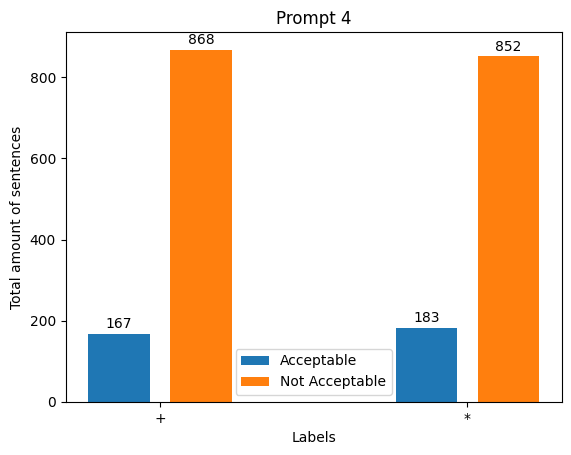

In [26]:
# Constructing the barplots to visualize the results of the GEITje model
import matplotlib.pyplot as plt
import numpy as np

labels = ['?', '??', '*?', '(?)']
labels_base = ['+', '*']

# Empty lists to store the total predictions for acceptable and unacceptable sentences
total_acceptable_predictions = []
total_unacceptable_predictions = []

# Iterate through each label and collect the predictions
for label, predictions in predictions_per_label.items():
    # Add the predictions to the total lists
    total_acceptable_predictions.append(np.sum(predictions))
    total_unacceptable_predictions.append(len(predictions) - np.sum(predictions))

# Width of the bars
bar_width = 0.2

# X positions for the barss
x = np.arange(len(labels_base))

# Plotting
fig, ax = plt.subplots()

# Bars for acceptable predictions
bars1 = ax.bar(x - bar_width/1.5, total_acceptable_predictions, bar_width, label='Acceptable')

# Bars for unacceptable predictions
bars2 = ax.bar(x + bar_width/1.5, total_unacceptable_predictions, bar_width, label='Not Acceptable')

# Function to place annotations above the bars
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 2),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Labels en titel
ax.set_xlabel('Labels')
ax.set_ylabel('Total amount of sentences')
ax.set_title('Prompt 4')
ax.set_xticks(x)
ax.set_xticklabels(labels_base)
ax.legend()

# Place annotations above the bars
annotate_bars(bars1)
annotate_bars(bars2)

# Save the barplot as a PNG file
plt.savefig('barplot_prompt_for_4_baseline.png')

plt.show()

In [28]:
print(total_acceptable_predictions)
print(total_unacceptable_predictions)
print(amount_per_label_baseline)
# Calculate the percentage of acceptable sentences and round it to two decimal places
percentage_acceptable = round((total_acceptable_predictions / amount_per_label_baseline) * 100, 2)

# Calculate the percentage of unacceptable sentences and round it to two decimal places
percentage_unacceptable = round((total_unacceptable_predictions / amount_per_label_baseline) * 100, 2)

print("Percentage acceptabele zinnen:", percentage_acceptable)
print("Percentage onacceptabele zinnen:", percentage_unacceptable)

[167, 183]
[868, 852]
Original_label
+    1035
*    1035
Name: count, dtype: int64
Percentage acceptabele zinnen: Original_label
+    16.14
*    17.68
Name: count, dtype: float64
Percentage onacceptabele zinnen: Original_label
+    83.86
*    82.32
Name: count, dtype: float64
